# To be used with gyst2D

## Initialization

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import argparse
from scipy import interpolate
import tqdm
import nmmn.lsd, nmmn.misc
import os.path
import pandas as pd
import astropy.visualization

In [3]:
# Constants, definitions and units

# many are related to grmonty, but we can set a black hole mass if we want to have a "feeling" for the physical values

global MP, ME, CL, GNEWT, KBOL, SIGMA_THOMSON, MSUN, LSUN, YEAR, MBH
global TPTE_DISK, TPTE_JET, THETAE_MAX
global M_unit, L_unit, T_unit, RHO_unit, U_unit, B_unit, Ne_unit

# all constants in cgs units
ME = 9.1093826e-28 # electron mass
MP = 1.67262171e-24 # proton mass
CL = 2.99792458e10 # speed of light
GNEWT = 6.6742e-8 # gravitational constant
KBOL = 1.3806505e-16 # Boltzmann constant
SIGMA_THOMSON = 0.665245873e-24 # Thomson cross-section
MSUN = 1.989e33 # solar mass
LSUN = 3.827e33 # solar luminosity
YEAR = 31536000 # seconds in a year

# temperature and beta-prescription (Mościbrodzka 2016)
TPTE_DISK = 20. # R_high
TPTE_JET = 1. # R_low
THETAE_MAX = 1000.
TP_OVER_TE = 100.0

sgra=1
m87=0
blazar=0
# grmonty units and BH mass
if (sgra):
    MBH = 4.5e6 * MSUN
    M_unit = 1.0e19
elif (m87):
    MBH = 6.2e9 * MSUN
    M_unit = 1.0e29

L_unit = GNEWT * MBH / (CL * CL)
T_unit = L_unit / CL
RHO_unit = M_unit / (L_unit*L_unit*L_unit)
U_unit = RHO_unit * CL * CL
B_unit = CL * np.sqrt(4. * np.pi * RHO_unit)
Ne_unit = RHO_unit / (MP + ME)

#MBH = 5.0e9 * MSUN
#M_unit = 2.0*10e11

## Read dump files

In [4]:
%run -i harm_script2.py

In [5]:
rg("gdump")

In [6]:
dumpnumber = 700
dumpnumperstr = str(dumpnumber)
dumpname = "dump"+str(dumpnumber)
runname = "Be104"

In [7]:
rd(dumpname)

harm_script2.py:738: RuntimeWarning: invalid value encountered in sqrt
  jcurr = np.sqrt(jsq)


In [8]:
N1, N2, N3 = nx, ny, nz

sigma = bsq/rho
sigmaphi = bu[3]*bd[3]/(rho)

betapl = 2.0*pg/bsq

bphi = bu[3]*B_unit
Bphi = B[3]*B_unit
#jcurr = np.nan_to_num(jcurr)
jdotu = mdot(ju,ud)
Jsq = jsq + jdotu*jdotu
gJsq = gdet*Jsq
JJJ = sqrt(Jsq)

EF = rho + gam*ug
EE = bsq + EF
va2 = bsq/EE
va = np.sqrt(va2)

enth=1+ug*gam/rho
unb=enth*ud[0]
isunbound=(-unb>1.02)

sigma2d = sigma[:,:,0]
r2d = (r*np.sin(h))[:,:,0]
z2d = (r*np.cos(h))[:,:,0]

In [9]:
"""
Jfile_j = "/work/gustavo/gyst/"+runname+"/jcs_files/"+dumpname+"_jcs"
Jfilechar_j = "/work/gustavo/gyst/"+runname+"/jcs_files/"+dumpname+"_jcs_char"
Jfile_d = "/work/gustavo/gyst/"+runname+"/jcs_files_disc/"+dumpname+"_jcs"
Jfilechar_d = "/work/gustavo/gyst/"+runname+"/jcs_files_disc/"+dumpname+"_jcs_char"
"""
Jfile_j = "/work/gustavo/gyst/jcs_files/"+dumpname+"_jcs"
Jfilechar_j = "/work/gustavo/gyst/jcs_files/"+dumpname+"_jcs_char"
Jfile_d = "/work/gustavo/gyst/jcs_files_disc/"+dumpname+"_jcs"
Jfilechar_d = "/work/gustavo/gyst/jcs_files_disc/"+dumpname+"_jcs_char"

f1_j = open(Jfile_j, "rb")
dtype = np.float64
body_j = np.fromfile(f1_j,dtype=dtype,count=-1)
JJ_cs_j = body_j.view().reshape((int(N1),int(N2),int(N3)), order='C')

f2_j = open(Jfilechar_j, "rb")
dtype = np.float64
body_j = np.fromfile(f2_j,dtype=dtype,count=-1)
JJ_cs_char_j = body_j.view().reshape((int(N1),int(N2),int(N3)), order='C')

f1_d = open(Jfile_d, "rb")
dtype = np.float64
body_d = np.fromfile(f1_d,dtype=dtype,count=-1)
JJ_cs_d = body_d.view().reshape((int(N1),int(N2),int(N3)), order='C')

f2_d = open(Jfilechar_d, "rb")
dtype = np.float64
body_d = np.fromfile(f2_d,dtype=dtype,count=-1)
JJ_cs_char_d = body_d.view().reshape((int(N1),int(N2),int(N3)), order='C')

JJ_cs_char_ind_j = numpy.zeros(shape=(N1,N2,N3))
JJ_cs_char_ind_d = numpy.zeros(shape=(N1,N2,N3))
for i in range(N1):
    for j in range(N2):
        for k in range(N3):
            if JJ_cs_char_j[i][j][k] > 0:
                JJ_cs_char_ind_j[i][j][k] = 1
            if JJ_cs_char_d[i][j][k] > 0:
                JJ_cs_char_ind_d[i][j][k] = 1
                
#Jdata = np.loadtxt(Jfile)
#JJ_cs = np.reshape(Jdata, (int(N1), int(N2), int(N3)))
vasites_j=[]
rx_j = []
ry_j = []
vasites_d=[]
rx_d = []
ry_d = []
for i in range(525):
    for j in range(N2):
        for k in range(N3):
            if (JJ_cs_char_ind_j[i][j][k] == 1):
                rx_j.append(r[i][j][k] * np.sin(h[i][j][k]))
                ry_j.append(r[i][j][k] * np.cos(h[i][j][k]))
                vasites_j.append(va[i][j][k])
            if (JJ_cs_char_ind_d[i][j][k] == 1):
                rx_d.append(r[i][j][k] * np.sin(h[i][j][k]))
                ry_d.append(r[i][j][k] * np.cos(h[i][j][k]))
                vasites_d.append(va[i][j][k])

## Make a few test plots

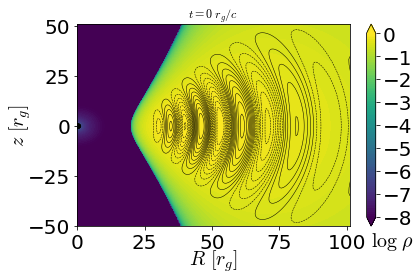

In [170]:
mirror = 1
if(mirror):
    xmax = 100
    ymax = xmax/2
    step = xmax/4
else:
    xmax = 125
    ymax = 250
    step = 25





hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(np.log10(rho),levels = np.linspace(-8, 0, 100),isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1)
#cs, cb = plco(bu[3]*B_unit, levels = np.linspace(-0.1, 0.1, 100), isfilled=1, k=0, xy=1, xmax=80, ymax=40, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$\log\;\rho$",fontsize=20,ha="left")
cb.set_ticks([-8,-7,-6,-5,-4,-3,-2,-1,0])
if(mirror):
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(-ymax,ymax+1)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(0,ymax+1)
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
plc(aphi,levels=np.linspace(-amax,amax,20)[1:-1],colors="black",linewidths=0.5,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("rho.png", dpi = 300)

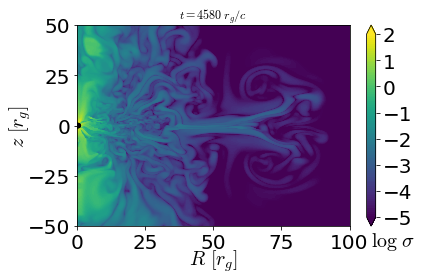

In [57]:
xmax = 100
ymax = xmax/2
step = xmax/4

hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(np.log10(sigma),levels = np.linspace(-5, 2, 100),isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1)
#cs, cb = plco(bu[3]*B_unit, levels = np.linspace(-0.1, 0.1, 100), isfilled=1, k=0, xy=1, xmax=80, ymax=40, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$\log\;\sigma$",fontsize=20,ha="left")
cb.set_ticks([-5,-4,-3,-2,-1,0,1,2])
plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,14)[1:-1],colors="black",linewidths=1,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("sigma_2D_"+str(int(np.round(t)))+".png", dpi = 150)

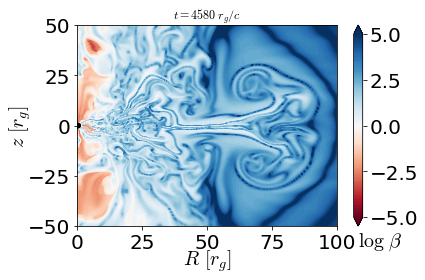

In [59]:
xmax = 100
ymax = xmax/2
step = xmax/4

hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(np.log10(betapl), levels = np.linspace(-5, 5, 100), isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1, cmap = 'RdBu')
#cs, cb = plco(betapl,isfilled=1,k=0,xy=1,xmax=80,ymax=40,dobh=1,cb=1,extend="both",pretty=1)
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$\log\;\beta$",fontsize=20,ha="left")
cb.set_ticks([-5,-2.5,0,2.5,5])
plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,14)[1:-1],colors="black",linewidths=1,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("beta_2D_"+str(int(np.round(t)))+".png", dpi = 150)

<Figure size 432x288 with 0 Axes>

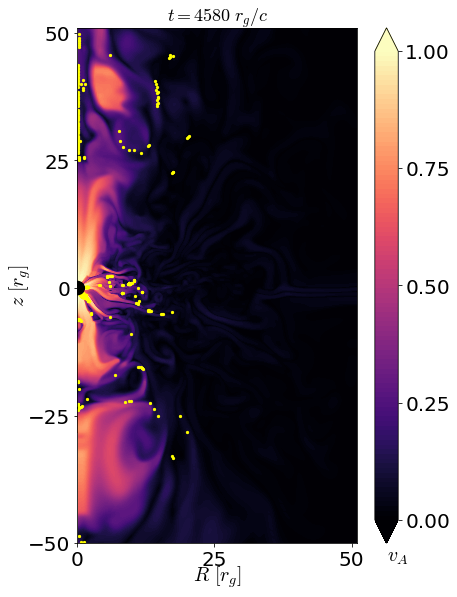

In [148]:
plt.clf()
mirror = 0
if(mirror):
    xmax = 50
    xmin = 0
    ymax = xmax/2
    ymin = -ymax
    step = xmax/4
else:
    ymin = -50
    xmin = 0
    xmax = 50
    ymax = 50
    step = 25
    
fig = plt.figure(figsize=[6.4, 8.4])
hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(va, levels = np.linspace(0, 1, 100), isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1, cmap='magma')
#cs, cb = plco(bu[3]*B_unit, levels = np.linspace(-0.1, 0.1, 100), isfilled=1, k=0, xy=1, xmax=80, ymax=40, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$v_A$",fontsize=20,ha="left")
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 5)#, markersize = 0.01)
cb.set_ticks([0,0.25,0.5,0.75,1])
if(mirror):
    plt.xticks(np.arange(xmin, xmax+1, step=step)) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step)) #GS
    plt.xlim(xmin,xmax+1)
    plt.ylim(ymin,ymax+1)
else:
    plt.xticks(np.arange(xmin, xmax+1, step=step)) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step)) #GS
    plt.xlim(xmin,xmax+1)
    plt.ylim(ymin,ymax+1)
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,14)[1:-1],colors="black",linewidths=1,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont,fontsize=18); 






plt.tight_layout() # GS
plt.draw()
#plt.savefig("va.png", dpi = 150)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


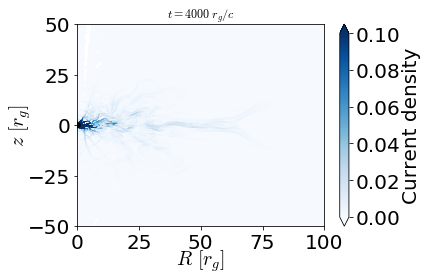

In [32]:
xmax = 100
ymax = xmax/2
step = xmax/4

#cs, cb = plco(jcurr/jcurr.max(), levels=np.linspace(0,1,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
cs, cb = plco(jcurr, levels=np.linspace(0,10e-2,100), isfilled=1, k=0, xy=1, xmax=xmax, ymax=ymax, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
#cs, cb = plco(np.log10(JJ_cs), levels=np.linspace(-2,7,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)
#cb.ax.set_xlabel(r"$j_{\mu}/j_{\mu}^{\mathrm{max}}$",fontsize=20,ha="left")
cb.set_ticks([0,0.02,0.04,0.06,0.08,0.1])
#cb.set_ticks([0,0.2,0.4,0.6,0.8,1])
cb.ax.set_ylabel("Current density",fontsize=20, labelpad=1, y=0.5)
plt.xticks(np.arange(0, xmax+1, step = step))
plt.yticks(np.arange(-ymax, ymax+1, step = step))
circle1 = plt.Circle((0, 0), Rin, color = 'black')

#plot(rgx[yc]-0.35, rgy[xc], color='orange', marker = 'o', markersize = 1.5)

fig = plt.gcf()
ax2 = fig.gca()
ax2.add_artist(circle1)
plt.title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()
#plt.savefig("sheets_4000.png", format = "png", dpi = 300)
#plt.clf

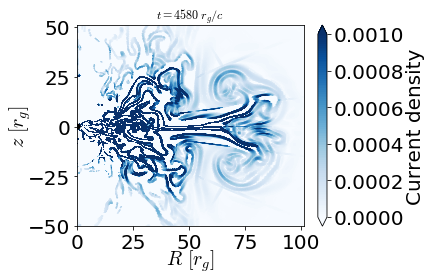

In [61]:
mirror = 1
if(mirror):
    xmax = 100
    xmin = 0
    ymax = xmax/2
    ymin = -ymax
    step = xmax/4
else:
    xmin = 0
    xmax = 150
    ymin = -250
    ymax = -100
    step = 50

#cs, cb = plco(JJ_cs/np.max(JJ_cs), levels=np.linspace(0,1,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
cs, cb = plco(JJ_cs, levels=np.linspace(0,10e-4,100), isfilled=1, k=0, xy=1, xmax=xmax, ymax=ymax, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
#cs, cb = plco(np.log10(JJ_cs), levels=np.linspace(-5,0,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)

#plot([rgx[yc]], [rgy[xc]], color='xkcd:aubergine', marker = 'o', markersize = 0.5)
#plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)

#cb.ax.set_xlabel(r"$\log\;J$",fontsize=20,ha="left")
#cb.ax.set_xlabel(r"$J$",fontsize=20,ha="left")
#cb.set_ticks([0,0.02,0.04,0.06,0.08,0.1])
cb.set_ticks([0,0.0002,0.0004,0.0006,0.0008,0.001])
cb.ax.set_ylabel("Current density",fontsize=20, labelpad=1, y=0.5)
if(mirror):
    plt.xticks(np.arange(xmin, xmax+1, step=step)) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step)) #GS
    plt.xlim(xmin,xmax+1)
    plt.ylim(ymin,ymax+1)
else:
    plt.xticks(np.arange(xmin, xmax+1, step=step)) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step)) #GS
    plt.xlim(xmin,xmax+1)
    plt.ylim(ymin,ymax+1)
circle1 = plt.Circle((0, 0), Rin, color = 'black')
fig = plt.gcf()
ax2 = fig.gca()
ax2.add_artist(circle1)
plt.title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()
#plt.savefig("sheets_2D_"+str(int(np.round(t)))+".png", dpi = 150)
#plt.clf

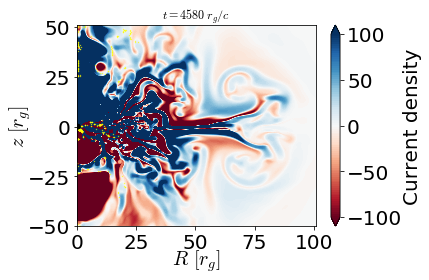

In [62]:
mirror = 1
if(mirror):
    xmax = 100
    xmin = 0
    ymax = xmax/2
    ymin = -ymax
    step = xmax/4
else:
    xmin = 0
    xmax = 150
    ymin = -250
    ymax = -100
    step = 50

#cs, cb = plco(JJ_cs/np.max(JJ_cs), levels=np.linspace(0,1,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
cs, cb = plco(Bphi*B_unit, levels = np.linspace(-100, 100, 100), isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1, cmap = 'RdBu')
#cs, cb = plco(np.log10(JJ_cs), levels=np.linspace(-5,0,100), isfilled=1, k=0, xy=1, xmax=10, ymax=5, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'Blues')
ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5)

#plot([rgx[yc]], [rgy[xc]], color='xkcd:aubergine', marker = 'o', markersize = 0.5)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)

#cb.ax.set_xlabel(r"$\log\;J$",fontsize=20,ha="left")
#cb.ax.set_xlabel(r"$J$",fontsize=20,ha="left")
#cb.set_ticks([0,0.02,0.04,0.06,0.08,0.1])
cb.set_ticks([-100,-50,0,50,100])
cb.ax.set_ylabel("Current density",fontsize=20, labelpad=1, y=0.5)
if(mirror):
    plt.xticks(np.arange(xmin, xmax+1, step=step)) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step)) #GS
    plt.xlim(xmin,xmax+1)
    plt.ylim(ymin,ymax+1)
else:
    plt.xticks(np.arange(xmin, xmax+1, step=step)) #GS
    plt.yticks(np.arange(ymin, ymax+1, step=step)) #GS
    plt.xlim(xmin,xmax+1)
    plt.ylim(ymin,ymax+1)
circle1 = plt.Circle((0, 0), Rin, color = 'black')
fig = plt.gcf()
ax2 = fig.gca()
ax2.add_artist(circle1)
plt.title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$")
plt.tight_layout()
#plt.savefig("Bphi_2D_sites_VA_jet_"+str(int(np.round(t)))+".png", dpi = 150)
#plt.clf

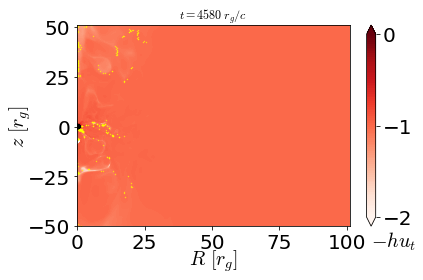

In [75]:
mirror = 1
if(mirror):
    xmax = 100
    ymax = xmax/2
    step = xmax/4
else:
    xmax = 125
    ymax = 250
    step = 25


hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(unb,levels = np.linspace(-2,0, 100),isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1, cmap = 'Reds')
#cs, cb = plco(bu[3]*B_unit, levels = np.linspace(-0.1, 0.1, 100), isfilled=1, k=0, xy=1, xmax=80, ymax=40, dobh=1, cb=1, extend = "both", pretty=1, cmap = 'RdBu')
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)

ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$-hu_t$",fontsize=20,ha="left")
cb.set_ticks([-2,-1,0])
if(mirror):
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(-ymax,ymax+1)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(0,ymax+1)
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,20)[1:-1],colors="black",linewidths=0.5,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("bernoulli_2D_VA_jet.png", dpi = 150)

In [ ]:
xmax = 20
ymax = xmax/2
step = xmax/4

hfont = {'fontname':'Helvetica'}
aphi=psicalc()
amax = aphi.max()
cs, cb = plco(Bphi, levels = np.linspace(-2., 2., 100), isfilled=1,k=0,xy=1,xmax=xmax,ymax=ymax,dobh=1,cb=1,extend="both",pretty=1, cmap = 'RdBu')
#cs, cb = plco(betapl,isfilled=1,k=0,xy=1,xmax=80,ymax=40,dobh=1,cb=1,extend="both",pretty=1)
#plt.contour(r2d, z2d, sigma2d, levels=[1], colors=('black'), linestyles=('-.'), linewidths=(2))

plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.5)#, markersize = 0.01)

ax = plt.gca()
ax.set_xlabel(r"$R\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
ax.set_ylabel(r"$z\ [r_g]$",fontsize=20,labelpad=-5, **hfont)
cb.ax.set_xlabel(r"$B_\phi$",fontsize=20,ha="left")
cb.set_ticks([-2.0,-1.,0,1.,2.0])
plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
plt.yticks(np.arange(-ymax, ymax+1, step=step), **hfont) #GS
circle1 = plt.Circle((0, 0), Rin, color='black') # GS
fig = plt.gcf() # GS
ax2 = fig.gca() # GS
ax2.add_artist(circle1) # GS
#plc(aphi,levels=np.linspace(-amax,amax,14)[1:-1],colors="black",linewidths=1,xy=-1)
plt.title(r"$t=%.4g$"%np.round(t)+r"$\;r_g/c$", **hfont); 
plt.tight_layout() # GS
plt.draw()
#plt.savefig("rho000_2ds9.png", dpi = 300)

## GET GUIDE FIELDS

In [14]:
disc = 0
jet = 1

In [15]:
sigmaext = []
betaext = []
BrBphiext = []
BthBphiext = []
#Vrecext = []
#Vrecstdevext = []
                
dumpmin, dumpmax = 225, 940
#imin = 800
#imax = imin+400
for dumpnumber in range(dumpmin, dumpmax+1):
    
    Vrec_avg = 0.
    Vrec_count = 0
    Vrec = []
    
    for i in range(0,N1):
        for j in range(0,N2):
            for k in range(0,N3):
                if (disc):
                    myfilename = "/work/gustavo/gyst/sheets_disc/dump%03d_%d_%d_%d_s" %(dumpnumber,i,j,k)
                elif (jet):
                    myfilename = "/work/gustavo/gyst/sheets/dump%03d_%d_%d_%d_s" %(dumpnumber,i,j,k)
                if (os.path.isfile(myfilename)):
                    #print(i, j, k)

                    myfile = open(myfilename, "rb")
                    dtype = np.float64
                    body = np.fromfile(myfile,dtype=dtype,count=-1)
                    ind2 = int((len(body))/10)
                    mydata = body.view().reshape((10,ind2), order='F')
                    
                    myBr       = mydata[0]
                    myBth      = mydata[1]
                    myBphi     = mydata[2]
                    myJ        = mydata[3]
                    mybeta     = mydata[4]
                    mysigma    = mydata[5]
                    mysigmaphi = mydata[6]
                    myi        = mydata[7]
                    myj        = mydata[8]
                    myk        = mydata[9]
                    myfile.close()

                    sigmaext.append(mysigma[0])
                    sigmaext.append(mysigma[-1])
                    betaext.append(mybeta[0])
                    betaext.append(mybeta[-1])
                    BrBphiext.append(abs(B[1][i][j][k]/B[3][i][j][k]))
                    BthBphiext.append(abs(B[2][i][j][k]/B[3][i][j][k]))
                    #Vrec.append(abs(myVrec[0]))
                    #Vrec_count += 1
                    
    #if (Vrec_count > 0):
    #    Vrec_avg = np.mean(Vrec)
    #    Vrec_stdev = np.std(Vrec)
    #    Vrecext.append(Vrec_avg)
    #    Vrecstdevext.append(Vrec_stdev)

In [16]:
BrBphiext = [x for x in BrBphiext if str(x) != 'nan']
BrBphiext = [x for x in BrBphiext if str(x) != 'inf']
BrBphiext = np.array(BrBphiext)

BthBphiext = [x for x in BthBphiext if str(x) != 'nan']
BthBphiext = [x for x in BthBphiext if str(x) != 'inf']
BthBphiext = np.array(BthBphiext)

betaext = [x for x in betaext if str(x) != 'nan']
betaext = [x for x in betaext if str(x) != 'inf']
betaext = np.array(betaext)

sigmaext = [x for x in sigmaext if str(x) != 'nan']
sigmaext = [x for x in sigmaext if str(x) != 'inf']
sigmaext = np.array(sigmaext)

#Vrecext = [x for x in Vrecext if str(x) != 'nan']
#Vrecext = [x for x in Vrecext if str(x) != 'inf']
#Vrecext = np.array(Vrecext)

#Vrecstdevext = [x for x in Vrecstdevext if str(x) != 'nan']
#Vrecstdevext = [x for x in Vrecstdevext if str(x) != 'inf']
#Vrecstdevext = np.array(Vrecstdevext)

In [17]:
# save quantities in files

if (jet):
    guidefield_r_file = open("guidefield_r_2D_jet.dat","w+")
elif (disc):
    guidefield_r_file = open("guidefield_r_2D_disc.dat","w+")
for line in range(len(BrBphiext)):
    guidefield_r_file.write(str(BrBphiext[line]))
    guidefield_r_file.write("\n")
guidefield_r_file.close()

if (jet):
    guidefield_th_file = open("guidefield_th_2D_jet.dat","w+")
elif (disc):
    guidefield_th_file = open("guidefield_th_2D_disc.dat","w+")
for line in range(len(BthBphiext)):
    guidefield_th_file.write(str(BthBphiext[line]))
    guidefield_th_file.write("\n")
guidefield_th_file.close()

if (jet):
    sigma_file = open("sigma_2D_jet.dat","w+")
elif (disc):
    sigma_file = open("sigma_2D_disc.dat","w+")
for line in range(len(sigmaext)):
    sigma_file.write(str(sigmaext[line]))
    sigma_file.write("\n")
sigma_file.close()

if (jet):
    beta_file = open("beta_2D_jet.dat","w+")
elif (disc):
    beta_file = open("beta_2D_disc.dat","w+")
for line in range(len(betaext)):
    beta_file.write(str(betaext[line]))
    beta_file.write("\n")
beta_file.close()
"""
if (jet):
    Vrec_file = open("Vrec_2D_jet.dat", "w+")
elif (disc):
    Vrec_file = open("Vrec_2D_disc.dat", "w+")
for line in range(len(Vrecext)):
    Vrec_file.write(str(Vrecext[line]))
    Vrec_file.write(",")
    Vrec_file.write(str(Vrecstdevext[line]))
    Vrec_file.write("\n")
Vrec_file.close()
"""

'\nif (jet):\n    Vrec_file = open("Vrec_2D_jet.dat", "w+")\nelif (disc):\n    Vrec_file = open("Vrec_2D_disc.dat", "w+")\nfor line in range(len(Vrecext)):\n    Vrec_file.write(str(Vrecext[line]))\n    Vrec_file.write(",")\n    Vrec_file.write(str(Vrecstdevext[line]))\n    Vrec_file.write("\n")\nVrec_file.close()\n'

# Plot guide fields, plasma beta, magnetisation etc

In [9]:
disc = 1
jet = 0
savef = 0

### Plot guide fields (Br)

In [10]:
if (disc):
    myfilename = "/work/gustavo/gyst/guidefield_r_2D_disc.dat"
    myfigname = "BrBphi_2D_disc.png"
    mylabel = "disc"
    mycolor = "blue"
elif (jet):
    myfilename = "/work/gustavo/gyst/guidefield_r_2D_jet.dat"
    myfigname = "BrBphi_2D_jet.png"
    mylabel = "jet"
    mycolor = "red"
    
myfile = open(myfilename, "r")
mydata = pd.read_csv(myfilename, header=None)
BrBphiext = mydata.values
BrBphiext_filt = BrBphiext[~is_outlier(BrBphiext)]
BrBphiext_filt = np.array(BrBphiext_filt)
myfile.close()

histmin = ((array(BrBphiext_filt)).min()).astype(float)
histmax = ((array(BrBphiext_filt)).max()).astype(float)

plt.hist(np.log10(BrBphiext_filt), bins=20, rwidth=0.9, range=[np.log10(histmin),np.log10(histmax)], label=mylabel, color = mycolor) # arguments are passed to np.histogram

_, max_ = plt.ylim()

plt.xlabel(r"$B_r/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
if (savef):
    plt.savefig(myfigname, dpi=150)

NameError: name 'is_outlier' is not defined

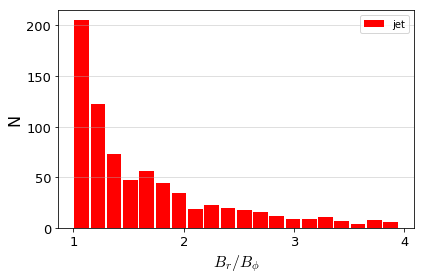

In [51]:
if (disc):
    myfilename = "/work/gustavo/gyst/guidefield_r_2D_disc.dat"
    myfigname = "BrBphi_2D_disc_large.png"
    mylabel = "disc"
    mycolor = "blue"
elif (jet):
    myfilename = "/work/gustavo/gyst/guidefield_r_2D_jet.dat"
    myfigname = "BrBphi_2D_jet_large.png"
    mylabel = "jet"
    mycolor = "red"

myfile = open(myfilename, "r")
mydata = pd.read_csv(myfilename, header=None)
BrBphiext = mydata.values
BrBphiext_filt = BrBphiext[~is_outlier(BrBphiext)]
BrBphiext_filt = np.array(BrBphiext_filt)
BrBphiext_large = BrBphiext[BrBphiext >= 1]
BrBphiext_large = BrBphiext_large[~is_outlier(BrBphiext_large)]
BrBphiext_large = np.array(BrBphiext_large)
myfile.close()

histmin = ((array(BrBphiext_large)).min()).astype(float)
histmax = ((array(BrBphiext_large)).max()).astype(float)

plt.hist(BrBphiext_large, bins=20, rwidth=0.9, range=[histmin,histmax], label=mylabel, color=mycolor) # arguments are passed to np.histogram

_, max_ = plt.ylim()

plt.xlabel(r"$B_r/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
if (savef):
    plt.savefig(myfigname, dpi=150)

### Plot guide fields (Bth)

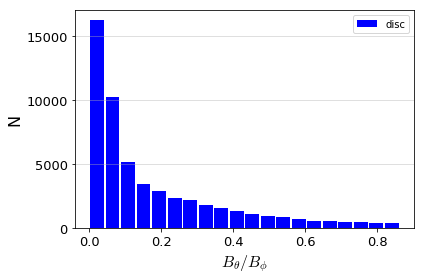

In [38]:
if (disc):
    myfilename = "/work/gustavo/gyst/guidefield_th_2D_disc.dat"
    myfigname = "BthBphi_2D_disc.png"
    mylabel = "disc"
    mycolor = "blue"
elif (jet):
    myfilename = "/work/gustavo/gyst/guidefield_th_2D_jet.dat"
    myfigname = "BthBphi_2D_jet.png"
    mylabel = "jet"
    mycolor = "red"

myfile = open(myfilename, "r")
mydata = pd.read_csv(myfilename, header=None)
BthBphiext = mydata.values
BthBphiext_filt = BthBphiext[~is_outlier(BthBphiext)]
BthBphiext_filt = np.array(BthBphiext_filt)
myfile.close()

histmin = ((array(BthBphiext_filt)).min()).astype(float)
histmax = ((array(BthBphiext_filt)).max()).astype(float)

plt.hist(BthBphiext_filt, bins=20, rwidth=0.9, range=[histmin,histmax], label=mylabel, color=mycolor) # arguments are passed to np.histogram

_, max_ = plt.ylim()

plt.xlabel(r"$B_\theta/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()
if (savef):
    plt.savefig(myfigname, dpi=150)

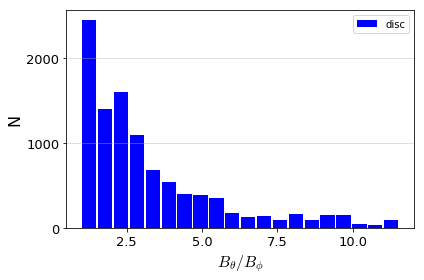

In [39]:
if (disc):
    myfilename = "/work/gustavo/gyst/guidefield_th_2D_disc.dat"
    myfigname = "BthBphi_2D_disc_large.png"
    mylabel = "disc"
    mycolor = "blue"
elif (jet):
    myfilename = "/work/gustavo/gyst/guidefield_th_2D_jet.dat"
    myfigname = "BthBphi_2D_jet_large.png"
    mylabel = "jet"
    mycolor = "red"

myfile = open(myfilename, "r")
mydata = pd.read_csv(myfilename, header=None)
BthBphiext = mydata.values
BthBphiext_filt = BthBphiext[~is_outlier(BthBphiext)]
BthBphiext_filt = np.array(BthBphiext_filt)
BthBphiext_large = BthBphiext[BthBphiext >= 1]
BthBphiext_large = BthBphiext_large[~is_outlier(BthBphiext_large)]
BthBphiext_large = np.array(BthBphiext_large)
myfile.close()

histmin = ((array(BthBphiext_large)).min()).astype(float)
histmax = ((array(BthBphiext_large)).max()).astype(float)

plt.hist(BthBphiext_large, bins=20, rwidth=0.9, range=[histmin,histmax], label=mylabel, color=mycolor) # arguments are passed to np.histogram

_, max_ = plt.ylim()

plt.xlabel(r"$B_\theta/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

if (savef):
    plt.savefig(myfigname, dpi=150)

### Plot magnetization

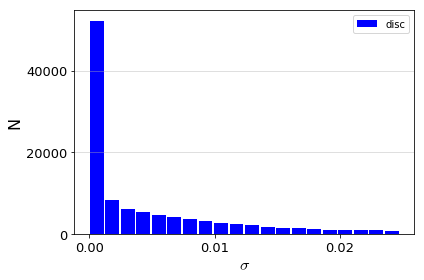

In [40]:
if (disc):
    myfilename = "/work/gustavo/gyst/sigma_2D_disc.dat"
    myfigname = "sigma_2D_disc.png"
    mylabel = "disc"
    mycolor = "blue"
elif (jet):
    myfilename = "/work/gustavo/gyst/sigma_2D_jet.dat"
    myfigname = "sigma_2D_jet.png"
    mylabel = "jet"
    mycolor = "red"

myfile = open(myfilename, "r")
mydata = pd.read_csv(myfilename, header=None)
sigmaext = mydata.values
sigmaext_filt = sigmaext[~is_outlier(sigmaext)]
sigmaext_filt = np.array(sigmaext_filt)
myfile.close()

histmin = ((array(sigmaext_filt)).min()).astype(float)
histmax = ((array(sigmaext_filt)).max()).astype(float)

plt.hist(sigmaext_filt, bins=20, rwidth=0.9, range=[histmin,histmax], label=mylabel, color=mycolor) # arguments are passed to np.histogram

_, max_ = plt.ylim()

plt.xlabel(r"$\sigma$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

if (savef):
    plt.savefig(myfigname, dpi=150)

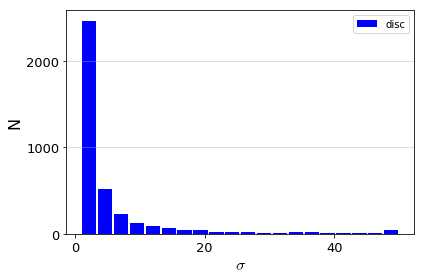

In [41]:
if (disc):
    myfilename = "/work/gustavo/gyst/sigma_2D_disc.dat"
    myfigname = "sigma_2D_disc_large.png"
    mylabel = "disc"
    mycolor = "blue"
elif (jet):
    myfilename = "/work/gustavo/gyst/sigma_2D_jet.dat"
    myfigname = "sigma_2D_jet_large.png"
    mylabel = "jet"
    mycolor = "red"

myfile = open(myfilename, "r")
mydata = pd.read_csv(myfilename, header=None)
sigmaext = mydata.values
sigmaext_filt = sigmaext[~is_outlier(sigmaext)]
sigmaext_filt = np.array(sigmaext_filt)
sigmaext_large = sigmaext[sigmaext >= 1]
#sigmaext_large = sigmaext_large[~is_outlier(sigmaext_large)]
sigmaext_large = np.array(sigmaext_large)
myfile.close()


histmin = ((array(sigmaext_large)).min()).astype(float)
histmax = ((array(sigmaext_large)).max()).astype(float)

plt.hist(sigmaext_large, bins=20, rwidth=0.9, range=[histmin,histmax], label=mylabel, color=mycolor) # arguments are passed to np.histogram

_, max_ = plt.ylim()

plt.xlabel(r"$\sigma$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

if (savef):
    plt.savefig(myfigname, dpi=150)

### Plot plasma beta

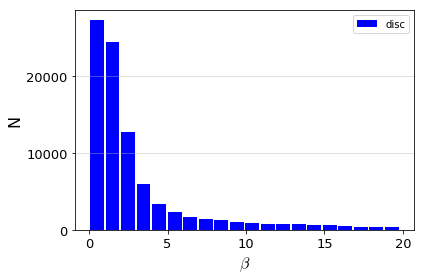

In [42]:
if (disc):
    myfilename = "/work/gustavo/gyst/beta_2D_disc.dat"
    myfigname = "beta_2D_disc.png"
    mylabel = "disc"
    mycolor = "blue"
elif (jet):
    myfilename = "/work/gustavo/gyst/beta_2D_jet.dat"
    myfigname = "beta_2D_jet.png"
    mylabel = "jet"
    mycolor = "red"

myfile = open(myfilename, "r")
mydata = pd.read_csv(myfilename, header=None)
betaext = mydata.values
betaext_filt = betaext[~is_outlier(betaext)]
betaext_filt = np.array(betaext_filt)
myfile.close()

histmin = ((array(betaext_filt)).min()).astype(float)
histmax = ((array(betaext_filt)).max()).astype(float)

plt.hist(betaext_filt, bins=20, rwidth=0.9, range=[histmin,histmax], label=mylabel, color=mycolor) # arguments are passed to np.histogram

_, max_ = plt.ylim()

plt.xlabel(r"$\beta$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

if (savef):
    plt.savefig(myfigname, dpi=150)

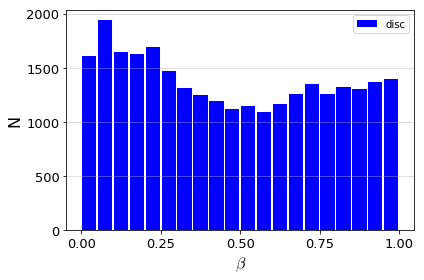

In [44]:
if (disc):
    myfilename = "/work/gustavo/gyst/beta_2D_disc.dat"
    myfigname = "beta_2D_disc_small.png"
    mylabel = "disc"
    mycolor = "blue"
elif (jet):
    myfilename = "/work/gustavo/gyst/beta_2D_jet.dat"
    myfigname = "beta_2D_jet_small.png"
    mylabel = "jet"
    mycolor = "red"
    
myfile = open(myfilename, "r")
mydata = pd.read_csv(myfilename, header=None)
betaext = mydata.values
betaext_filt = betaext[~is_outlier(betaext)]
betaext_filt = np.array(betaext_filt)
betaext_small = betaext[betaext < 1]
betaext_small = betaext_small[~is_outlier(betaext_small)]
betaext_small = np.array(betaext_small)
myfile.close()

histmin = ((array(betaext_small)).min()).astype(float)
histmax = ((array(betaext_small)).max()).astype(float)

plt.hist(betaext_small, bins=20, rwidth=0.9, range=[histmin,histmax], label=mylabel, color=mycolor) # arguments are passed to np.histogram

_, max_ = plt.ylim()

plt.xlabel(r"$\beta$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

if (savef):
    plt.savefig(myfigname, dpi=150)

### Plot reconnection sites per snapshot

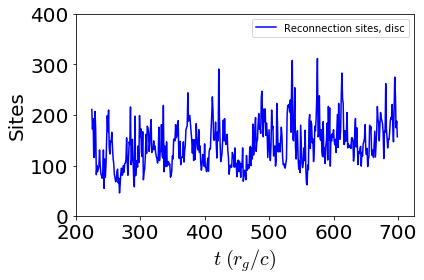

In [85]:
if (disc):
    myfilename = "/work/gustavo/gyst/sitecount_2D_disc.dat"
    mylabel = "Reconnection sites, disc"
    myfigname = "sitecount_disc.png"
    mycolor = "blue"
    ymin,ymax,ystep = 0,400,100
elif (jet):
    myfilename = "/work/gustavo/gyst/sitecount_2D_jet.dat"
    mylabel = "Reconnection sites, jet"
    myfigname = "sitecount_jet.png"
    mycolor = "red"
    ymin,ymax,ystep = 0,200,50

myfile = open(myfilename, "r")
mydata = pd.read_csv(myfilename, sep=',', header=None)
myfile.close()

dumpnumber = []
mydata = mydata.values
mydata = np.transpose(mydata)
sites = mydata[1]
for line in range(len(mydata[1])):
    dumpnumber.append(56+line)
    
dumpnumber = np.array(dumpnumber)
sites = np.array(sites)

plt.plot(dumpnumber[169:], sites[169:], alpha=1, label=mylabel, color=mycolor)
plt.xlabel(r"$t\;(r_g/c)$")
plt.ylabel("Sites")
xmin,xmax,xstep = 200,725,100
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.xticks(np.arange(xmin, xmax+1, step=xstep))
plt.yticks(np.arange(ymin, ymax+1, step=ystep))
plt.legend(loc="best")
plt.tight_layout()

if (savef):
    plt.savefig(myfigname, dpi=150)

## MULTIPLOTS

/home/gustavo/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


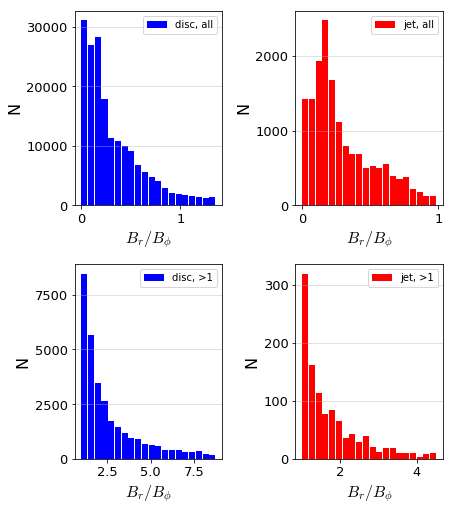

In [20]:
myfilename_d = "/work/gustavo/gyst/guidefield_r_2D_disc.dat"
mylabel_d = "disc"
mycolor_d = "blue"

myfilename_j = "/work/gustavo/gyst/guidefield_r_2D_jet.dat"
mylabel_j = "jet"
mycolor_j = "red"

myfile_d = open(myfilename_d, "r")
mydata_d = pd.read_csv(myfilename_d, header=None)
BrBphiext_d = mydata_d.values
BrBphiext_filt_d = BrBphiext_d[~is_outlier(BrBphiext_d)]
BrBphiext_filt_d = np.array(BrBphiext_filt_d)
BrBphiext_large_d = BrBphiext_d[BrBphiext_d >= 1]
BrBphiext_large_d = BrBphiext_large_d[~is_outlier(BrBphiext_large_d)]
BrBphiext_large_d = np.array(BrBphiext_large_d)
myfile_d.close()

myfile_j = open(myfilename_j, "r")
mydata_j = pd.read_csv(myfilename_j, header=None)
BrBphiext_j = mydata_j.values
BrBphiext_filt_j = BrBphiext_j[~is_outlier(BrBphiext_j)]
BrBphiext_filt_j = np.array(BrBphiext_filt_j)
BrBphiext_large_j = BrBphiext_j[BrBphiext_j >= 1]
BrBphiext_large_j = BrBphiext_large_j[~is_outlier(BrBphiext_large_j)]
BrBphiext_large_j = np.array(BrBphiext_large_j)
myfile_j.close()

histmin_d = ((array(BrBphiext_filt_d)).min()).astype(float)
histmax_d = ((array(BrBphiext_filt_d)).max()).astype(float)

histmin_j = ((array(BrBphiext_filt_j)).min()).astype(float)
histmax_j = ((array(BrBphiext_filt_j)).max()).astype(float)

histmin_large_d = ((array(BrBphiext_large_d)).min()).astype(float)
histmax_large_d = ((array(BrBphiext_large_d)).max()).astype(float)

histmin_large_j = ((array(BrBphiext_large_j)).min()).astype(float)
histmax_large_j = ((array(BrBphiext_large_j)).max()).astype(float)

hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])
plt.hist(BrBphiext_filt_d, bins=20, rwidth=0.9, range=[histmin_d,histmax_d], label="disc, all", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$B_r/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax2 = plt.subplot(gs[0,1])
plt.hist(BrBphiext_filt_j, bins=20, rwidth=0.9, range=[histmin_j,histmax_j], label="jet, all", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$B_r/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax3 = plt.subplot(gs[1,0])
plt.hist(BrBphiext_large_d, bins=20, rwidth=0.9, range=[histmin_large_d,histmax_large_d], label="disc, >1", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$B_r/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax4 = plt.subplot(gs[1,1])
plt.hist(BrBphiext_large_j, bins=20, rwidth=0.9, range=[histmin_large_j,histmax_large_j], label="jet, >1", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$B_r/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

savef=0
if (savef):
    plt.savefig("BrBphi_2D_multi", dpi=150)

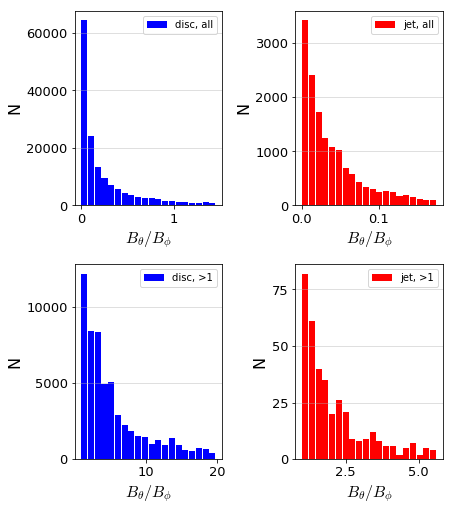

In [21]:
myfilename_d = "/work/gustavo/gyst/guidefield_th_2D_disc.dat"
mylabel_d = "disc"
mycolor_d = "blue"

myfilename_j = "/work/gustavo/gyst/guidefield_th_2D_jet.dat"
mylabel_j = "jet"
mycolor_j = "red"

myfile_d = open(myfilename_d, "r")
mydata_d = pd.read_csv(myfilename_d, header=None)
BthBphiext_d = mydata_d.values
BthBphiext_filt_d = BthBphiext_d[~is_outlier(BthBphiext_d)]
BthBphiext_filt_d = np.array(BthBphiext_filt_d)
BthBphiext_large_d = BthBphiext_d[BthBphiext_d >= 1]
BthBphiext_large_d = BthBphiext_large_d[~is_outlier(BthBphiext_large_d)]
BthBphiext_large_d = np.array(BthBphiext_large_d)
myfile_d.close()

myfile_j = open(myfilename_j, "r")
mydata_j = pd.read_csv(myfilename_j, header=None)
BthBphiext_j = mydata_j.values
BthBphiext_filt_j = BthBphiext_j[~is_outlier(BthBphiext_j)]
BthBphiext_filt_j = np.array(BthBphiext_filt_j)
BthBphiext_large_j = BthBphiext_j[BthBphiext_j >= 1]
BthBphiext_large_j = BthBphiext_large_j[~is_outlier(BthBphiext_large_j)]
BthBphiext_large_j = np.array(BthBphiext_large_j)
myfile_j.close()

histmin_d = ((array(BthBphiext_filt_d)).min()).astype(float)
histmax_d = ((array(BthBphiext_filt_d)).max()).astype(float)

histmin_j = ((array(BthBphiext_filt_j)).min()).astype(float)
histmax_j = ((array(BthBphiext_filt_j)).max()).astype(float)

histmin_large_d = ((array(BthBphiext_large_d)).min()).astype(float)
histmax_large_d = ((array(BthBphiext_large_d)).max()).astype(float)

histmin_large_j = ((array(BthBphiext_large_j)).min()).astype(float)
histmax_large_j = ((array(BthBphiext_large_j)).max()).astype(float)

hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])
plt.hist(BthBphiext_filt_d, bins=20, rwidth=0.9, range=[histmin_d,histmax_d], label="disc, all", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$B_\theta/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax2 = plt.subplot(gs[0,1])
plt.hist(BthBphiext_filt_j, bins=20, rwidth=0.9, range=[histmin_j,histmax_j], label="jet, all", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$B_\theta/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax3 = plt.subplot(gs[1,0])
plt.hist(BthBphiext_large_d, bins=20, rwidth=0.9, range=[histmin_large_d,histmax_large_d], label="disc, >1", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$B_\theta/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax4 = plt.subplot(gs[1,1])
plt.hist(BthBphiext_large_j, bins=20, rwidth=0.9, range=[histmin_large_j,histmax_large_j], label="jet, >1", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$B_\theta/B_\phi$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

savef=0
if (savef):
    plt.savefig("BthBphi_2D_multi", dpi=150)

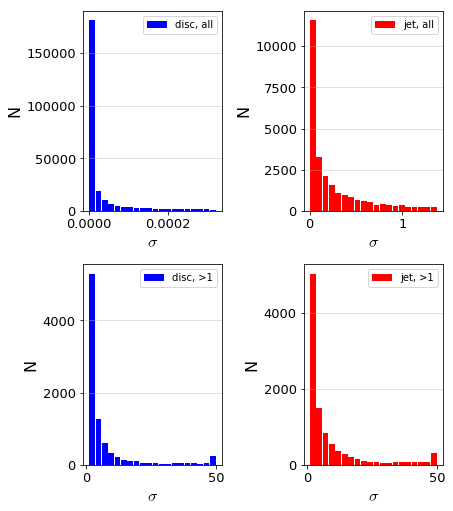

In [22]:
myfilename_d = "/work/gustavo/gyst/sigma_2D_disc.dat"
#myfigname_d = "sigma_2D_disc_multi.png"
mylabel_d = "disc"
mycolor_d = "blue"

myfilename_j = "/work/gustavo/gyst/sigma_2D_jet.dat"
#myfigname_j = "sigma_2D_jet_multi.png"
mylabel_j = "jet"
mycolor_j = "red"

myfile_d = open(myfilename_d, "r")
mydata_d = pd.read_csv(myfilename_d, header=None)
sigmaext_d = mydata_d.values
sigmaext_filt_d = sigmaext_d[~is_outlier(sigmaext_d)]
sigmaext_filt_d = np.array(sigmaext_filt_d)
sigmaext_large_d = sigmaext_d[sigmaext_d >= 1]
sigmaext_large_d = np.array(sigmaext_large_d)
myfile_d.close()

myfile_j = open(myfilename_j, "r")
mydata_j = pd.read_csv(myfilename_j, header=None)
sigmaext_j = mydata_j.values
sigmaext_filt_j = sigmaext_j[~is_outlier(sigmaext_j)]
sigmaext_filt_j = np.array(sigmaext_filt_j)
sigmaext_large_j = sigmaext_j[sigmaext_j >= 1]
sigmaext_large_j = np.array(sigmaext_large_j)
myfile_j.close()

histmin_d = ((array(sigmaext_filt_d)).min()).astype(float)
histmax_d = ((array(sigmaext_filt_d)).max()).astype(float)

histmin_j = ((array(sigmaext_filt_j)).min()).astype(float)
histmax_j = ((array(sigmaext_filt_j)).max()).astype(float)

histmin_large_d = ((array(sigmaext_large_d)).min()).astype(float)
histmax_large_d = ((array(sigmaext_large_d)).max()).astype(float)

histmin_large_j = ((array(sigmaext_large_j)).min()).astype(float)
histmax_large_j = ((array(sigmaext_large_j)).max()).astype(float)

hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])
plt.hist(sigmaext_filt_d, bins=20, rwidth=0.9, range=[histmin_d,histmax_d], label="disc, all", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\sigma$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax2 = plt.subplot(gs[0,1])
plt.hist(sigmaext_filt_j, bins=20, rwidth=0.9, range=[histmin_j,histmax_j], label="jet, all", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\sigma$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax3 = plt.subplot(gs[1,0])
plt.hist(sigmaext_large_d, bins=20, rwidth=0.9, range=[histmin_large_d,histmax_large_d], label="disc, >1", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\sigma$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax4 = plt.subplot(gs[1,1])
plt.hist(sigmaext_large_j, bins=20, rwidth=0.9, range=[histmin_large_j,histmax_large_j], label="jet, >1", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\sigma$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

savef=0
if (savef):
    plt.savefig("sigma_2D_multi", dpi=150)

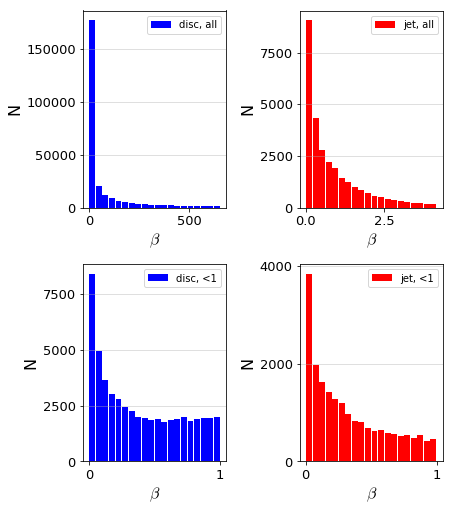

In [23]:
myfilename_d = "/work/gustavo/gyst/beta_2D_disc.dat"
mylabel_d = "disc"
mycolor_d = "blue"

myfilename_j = "/work/gustavo/gyst/beta_2D_jet.dat"
mylabel_j = "jet"
mycolor_j = "red"

myfile_d = open(myfilename_d, "r")
mydata_d = pd.read_csv(myfilename_d, header=None)
betaext_d = mydata_d.values
betaext_filt_d = betaext_d[~is_outlier(betaext_d)]
betaext_filt_d = np.array(betaext_filt_d)
betaext_small_d = betaext_d[betaext_d < 1]
betaext_small_d = np.array(betaext_small_d)
myfile_d.close()

myfile_j = open(myfilename_j, "r")
mydata_j = pd.read_csv(myfilename_j, header=None)
betaext_j = mydata_j.values
betaext_filt_j = betaext_j[~is_outlier(betaext_j)]
betaext_filt_j = np.array(betaext_filt_j)
betaext_small_j = betaext_j[betaext_j < 1]
betaext_small_j = np.array(betaext_small_j)
myfile_j.close()

histmin_d = ((array(betaext_filt_d)).min()).astype(float)
histmax_d = ((array(betaext_filt_d)).max()).astype(float)

histmin_j = ((array(betaext_filt_j)).min()).astype(float)
histmax_j = ((array(betaext_filt_j)).max()).astype(float)

histmin_small_d = ((array(betaext_small_d)).min()).astype(float)
histmax_small_d = ((array(betaext_small_d)).max()).astype(float)

histmin_small_j = ((array(betaext_small_j)).min()).astype(float)
histmax_small_j = ((array(betaext_small_j)).max()).astype(float)

hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])
plt.hist(betaext_filt_d, bins=20, rwidth=0.9, range=[histmin_d,histmax_d], label="disc, all", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\beta$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax2 = plt.subplot(gs[0,1])
plt.hist(betaext_filt_j, bins=20, rwidth=0.9, range=[histmin_j,histmax_j], label="jet, all", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\beta$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax3 = plt.subplot(gs[1,0])
plt.hist(betaext_small_d, bins=20, rwidth=0.9, range=[histmin_small_d,histmax_small_d], label="disc, <1", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\beta$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

ax4 = plt.subplot(gs[1,1])
plt.hist(betaext_small_j, bins=20, rwidth=0.9, range=[histmin_small_j,histmax_small_j], label="jet, <1", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\beta$", fontsize=16)
plt.ylabel("N", fontsize=16)
plt.grid(axis='y', alpha=0.5)
plt.legend(loc="best")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.tight_layout()

savef=0
if (savef):
    plt.savefig("beta_2D_multi", dpi=150)

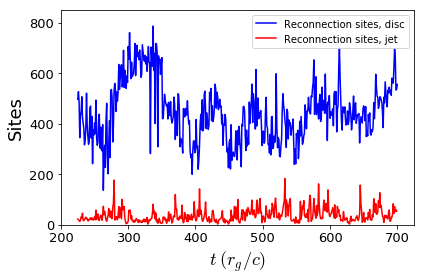

In [86]:
fontsize = 13
latexsize = 18

myfilename_d = "/work/gustavo/gyst/sitecount_2D_disc.dat"
mylabel_d = "Reconnection sites, disc"
mycolor_d = "blue"
    
myfilename_j = "/work/gustavo/gyst/sitecount_2D_jet.dat"
mylabel_j = "Reconnection sites, jet"
mycolor_j = "red"

myfile_d = open(myfilename_d, "r")
mydata_d = pd.read_csv(myfilename_d, sep=',', header=None)
myfile_d.close()

myfile_j = open(myfilename_j, "r")
mydata_j = pd.read_csv(myfilename_j, sep=',', header=None)
myfile_j.close()

dumpnumber_d = []
mydata_d = mydata_d.values
mydata_d = np.transpose(mydata_d)
sites_d = mydata_d[1]
for line in range(len(mydata_d[1])):
    dumpnumber_d.append(225+line)

dumpnumber_j = []
mydata_j = mydata_j.values
mydata_j = np.transpose(mydata_j)
sites_j = mydata_j[1]
for line in range(len(mydata_j[1])):
    dumpnumber_j.append(56+line)
    
dumpnumber_d = np.array(dumpnumber_d)
sites_d = np.array(sites_d)

dumpnumber_j = np.array(dumpnumber_j)
sites_j = np.array(sites_j)

plt.plot(dumpnumber_d, sites_d, alpha=1, label=mylabel_d, color=mycolor_d)
plt.plot(dumpnumber_j[169:], sites_j[169:], alpha=1, label=mylabel_j, color=mycolor_j)

plt.xlabel(r"$t\;(r_g/c)$", fontsize=latexsize)
plt.ylabel("Sites",fontsize=latexsize)
xmin,xmax,xstep = 200,725,100
ymin,ymax,ystep = 0,850,200
plt.xlim(xmin,xmax)
plt.ylim(ymin,ymax)
plt.xticks(np.arange(xmin, xmax+1, step=xstep), fontsize = fontsize)
plt.yticks(np.arange(ymin, ymax+1, step=ystep), fontsize = fontsize)
plt.legend(loc="best")
plt.tight_layout()

savef=0
if (savef):
    plt.savefig("sitecount.png", dpi=150)

<Figure size 460.8x518.4 with 0 Axes>

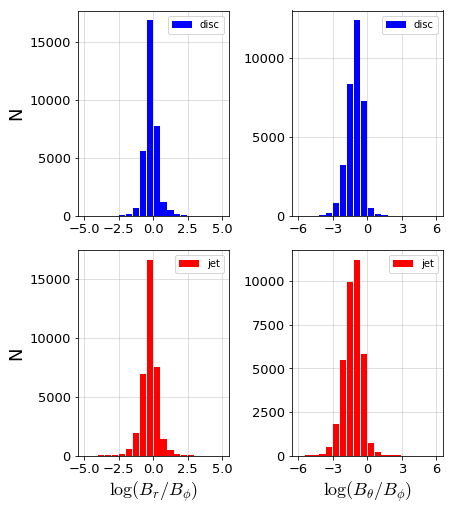

In [41]:
fontsize = 13
latexsize = 18

mylabel_d = "disc"
mycolor_d = "blue"
mylabel_j = "jet"
mycolor_j = "red"

myfilename_rd = "/work/gustavo/gyst/guidefield_r_2D_disc.dat"
myfilename_rj = "/work/gustavo/gyst/guidefield_r_2D_jet.dat"

myfile_rd = open(myfilename_rd, "r")
mydata_rd = pd.read_csv(myfilename_rd, header=None)
BrBphiext_d = mydata_rd.values
#BrBphiext_filt_d = BrBphiext_d[~is_outlier(BrBphiext_d)]
BrBphiext_filt_d = BrBphiext_d
BrBphiext_filt_d = np.array(BrBphiext_filt_d)
BrBphiext_large_d = BrBphiext_d[BrBphiext_d >= 1]
BrBphiext_large_d = BrBphiext_large_d[~is_outlier(BrBphiext_large_d)]
BrBphiext_large_d = np.array(BrBphiext_large_d)
myfile_rd.close()

myfile_rj = open(myfilename_rj, "r")
mydata_rj = pd.read_csv(myfilename_rj, header=None)
BrBphiext_j = mydata_rj.values
#BrBphiext_filt_j = BrBphiext_j[~is_outlier(BrBphiext_j)]
BrBphiext_filt_j = BrBphiext_j
BrBphiext_filt_j = np.array(BrBphiext_filt_j)
BrBphiext_large_j = BrBphiext_j[BrBphiext_j >= 1]
BrBphiext_large_j = BrBphiext_large_j[~is_outlier(BrBphiext_large_j)]
BrBphiext_large_j = np.array(BrBphiext_large_j)
myfile_rj.close()

histmin_rd = np.log10(((array(BrBphiext_filt_d)).min()).astype(float))
histmax_rd = np.log10(((array(BrBphiext_filt_d)).max()).astype(float))

histmin_rj = np.log10(((array(BrBphiext_filt_j)).min()).astype(float))
histmax_rj = np.log10(((array(BrBphiext_filt_j)).max()).astype(float))

histmin_large_rd = np.log10(((array(BrBphiext_large_d)).min()).astype(float))
histmax_large_rd = np.log10(((array(BrBphiext_large_d)).max()).astype(float))

histmin_large_rj = np.log10(((array(BrBphiext_large_j)).min()).astype(float))
histmax_large_rj = np.log10(((array(BrBphiext_large_j)).max()).astype(float))


################################



myfilename_thd = "/work/gustavo/gyst/guidefield_th_2D_disc.dat"
myfilename_thj = "/work/gustavo/gyst/guidefield_th_2D_jet.dat"

myfile_thd = open(myfilename_thd, "r")
mydata_thd = pd.read_csv(myfilename_thd, header=None)
BthBphiext_d = mydata_thd.values
#BthBphiext_filt_d = BthBphiext_d[~is_outlier(BthBphiext_d)]
BthBphiext_filt_d = BthBphiext_d
BthBphiext_filt_d = np.array(BthBphiext_filt_d)
BthBphiext_large_d = BthBphiext_d[BthBphiext_d >= 1]
BthBphiext_large_d = BthBphiext_large_d[~is_outlier(BthBphiext_large_d)]
BthBphiext_large_d = np.array(BthBphiext_large_d)
myfile_thd.close()

myfile_thj = open(myfilename_thj, "r")
mydata_thj = pd.read_csv(myfilename_thj, header=None)
BthBphiext_j = mydata_thj.values
#BthBphiext_filt_j = BthBphiext_j[~is_outlier(BthBphiext_j)]
BthBphiext_filt_j = BthBphiext_j
BthBphiext_filt_j = np.array(BthBphiext_filt_j)
BthBphiext_large_j = BthBphiext_j[BthBphiext_j >= 1]
BthBphiext_large_j = BthBphiext_large_j[~is_outlier(BthBphiext_large_j)]
BthBphiext_large_j = np.array(BthBphiext_large_j)
myfile_thj.close()

histmin_thd = np.log10(((array(BthBphiext_filt_d)).min()).astype(float))
histmax_thd = np.log10(((array(BthBphiext_filt_d)).max()).astype(float))

histmin_thj = np.log10(((array(BthBphiext_filt_j)).min()).astype(float))
histmax_thj = np.log10(((array(BthBphiext_filt_j)).max()).astype(float))

histmin_large_thd = np.log10(((array(BthBphiext_large_d)).min()).astype(float))
histmax_large_thd = np.log10(((array(BthBphiext_large_d)).max()).astype(float))

histmin_large_thj = np.log10(((array(BthBphiext_large_j)).min()).astype(float))
histmax_large_thj = np.log10(((array(BthBphiext_large_j)).max()).astype(float))

hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


#################################



hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])
plt.hist(np.log10(BrBphiext_filt_d), bins=20, rwidth=0.9, range=[-5,5], label="disc", color=mycolor_d, zorder=2)
_, max_ = plt.ylim()
#plt.xlabel(r"$\log(B_r/B_\phi)$", fontsize=latexsize)
plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-5,-2.5,0,2.5,5],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax2 = plt.subplot(gs[0,1])
plt.hist(np.log10(BthBphiext_filt_d), bins=20, rwidth=0.9, range=[-6,6], label="disc", color=mycolor_d, zorder=2)
_, max_ = plt.ylim()
#plt.xlabel(r"$\log(B_\theta/B_\phi)$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-6,-3,0,3,6],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax3 = plt.subplot(gs[1,0])
plt.hist(np.log10(BrBphiext_filt_j), bins=20, rwidth=0.9, range=[-5,5], label="jet", color=mycolor_j, zorder=2)
_, max_ = plt.ylim()
plt.xlabel(r"$\log(B_r/B_\phi)$", fontsize=latexsize)
plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-5,-2.5,0,2.5,5],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax4 = plt.subplot(gs[1,1])
plt.hist(np.log10(BthBphiext_filt_j), bins=20, rwidth=0.9, range=[-6,6], label="jet", color=mycolor_j, zorder=2)
_, max_ = plt.ylim()
plt.xlabel(r"$\log(B_\theta/B_\phi)$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-6,-3,0,3,6],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

savef=1
if (savef):
    plt.savefig("log_guidefield_2D_multi", dpi=150)

<Figure size 460.8x518.4 with 0 Axes>

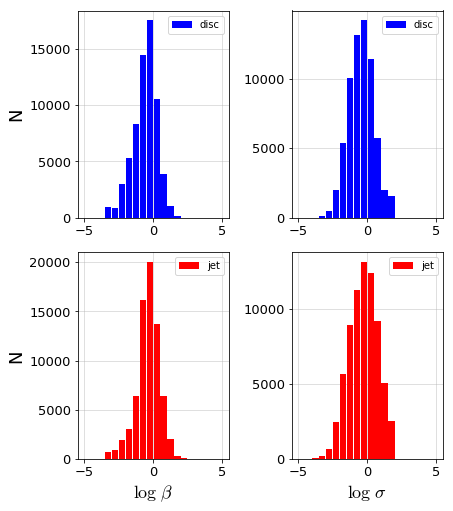

In [42]:
fontsize = 13
latexsize = 18

mylabel_d = "disc"
mycolor_d = "blue"
mylabel_j = "jet"
mycolor_j = "red"

myfilename_bd = "/work/gustavo/gyst/beta_2D_disc.dat"
myfilename_bj = "/work/gustavo/gyst/beta_2D_jet.dat"

myfile_bd = open(myfilename_bd, "r")
mydata_bd = pd.read_csv(myfilename_bd, header=None)
betaext_d = mydata_bd.values
#betaext_filt_d = betaext_d[~is_outlier(betaext_d)]
betaext_filt_d = betaext_d
betaext_filt_d = np.array(betaext_filt_d)
betaext_small_d = betaext_d[betaext_d < 1]
betaext_small_d = np.array(betaext_small_d)
myfile_bd.close()

myfile_bj = open(myfilename_bj, "r")
mydata_bj = pd.read_csv(myfilename_bj, header=None)
betaext_j = mydata_bj.values
#betaext_filt_j = betaext_j[~is_outlier(betaext_j)]
betaext_filt_j = betaext_j
betaext_filt_j = np.array(betaext_filt_j)
betaext_small_j = betaext_j[betaext_j < 1]
betaext_small_j = np.array(betaext_small_j)
myfile_bj.close()

histmin_bd = np.log10(((array(betaext_filt_d)).min()).astype(float))
histmax_bd = np.log10(((array(betaext_filt_d)).max()).astype(float))

histmin_bj = np.log10(((array(betaext_filt_j)).min()).astype(float))
histmax_bj = np.log10(((array(betaext_filt_j)).max()).astype(float))

histmin_small_bd = np.log10(((array(betaext_small_d)).min()).astype(float))
histmax_small_bd = np.log10(((array(betaext_small_d)).max()).astype(float))

histmin_small_bj = np.log10(((array(betaext_small_j)).min()).astype(float))
histmax_small_bj = np.log10(((array(betaext_small_j)).max()).astype(float))


################################

myfilename_sd = "/work/gustavo/gyst/sigma_2D_disc.dat"
myfilename_sj = "/work/gustavo/gyst/sigma_2D_jet.dat"

myfile_sd = open(myfilename_sd, "r")
mydata_sd = pd.read_csv(myfilename_sd, header=None)
sigmaext_d = mydata_sd.values
#sigmaext_filt_d = sigmaext_d[~is_outlier(sigmaext_d)]
sigmaext_filt_d = sigmaext_d
sigmaext_filt_d = np.array(sigmaext_filt_d)
sigmaext_large_d = sigmaext_d[sigmaext_d >= 1]
sigmaext_large_d = np.array(sigmaext_large_d)
myfile_sd.close()

myfile_sj = open(myfilename_sj, "r")
mydata_sj = pd.read_csv(myfilename_sj, header=None)
sigmaext_j = mydata_sj.values
#sigmaext_filt_j = sigmaext_j[~is_outlier(sigmaext_j)]
sigmaext_filt_j = sigmaext_j
sigmaext_filt_j = np.array(sigmaext_filt_j)
sigmaext_large_j = sigmaext_j[sigmaext_j >= 1]
sigmaext_large_j = np.array(sigmaext_large_j)
myfile_sj.close()

histmin_sd = np.log10(((array(sigmaext_filt_d)).min()).astype(float))
histmax_sd = np.log10(((array(sigmaext_filt_d)).max()).astype(float))

histmin_sj = np.log10(((array(sigmaext_filt_j)).min()).astype(float))
histmax_sj = np.log10(((array(sigmaext_filt_j)).max()).astype(float))

histmin_large_sd = np.log10(((array(sigmaext_large_d)).min()).astype(float))
histmax_large_sd = np.log10(((array(sigmaext_large_d)).max()).astype(float))

histmin_large_sj = np.log10(((array(sigmaext_large_j)).min()).astype(float))
histmax_large_sj = np.log10(((array(sigmaext_large_j)).max()).astype(float))


##################################


hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


#################################



hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])
plt.hist(np.log10(betaext_filt_d), bins=20, rwidth=0.9, range=[-5,5], label="disc", color=mycolor_d, zorder=2)
#plt.hist(np.log10(betaext_filt_d), bins=20, rwidth=0.9, range=[-5,10], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
#plt.xlabel(r"$\log\;\beta$", fontsize=latexsize)
plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-5,0,5],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax2 = plt.subplot(gs[0,1])
plt.hist(np.log10(sigmaext_filt_d), bins=20, rwidth=0.9, range=[-5,5], label="disc", color=mycolor_d, zorder=2)
#plt.hist(np.log10(sigmaext_filt_d), bins=20, rwidth=0.9, range=[-13,2], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
#plt.xlabel(r"$\log\;\sigma$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-5,0,5],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax3 = plt.subplot(gs[1,0])
plt.hist(np.log10(betaext_filt_j), bins=20, rwidth=0.9, range=[-5,5], label="jet", color=mycolor_j, zorder=2)
#plt.hist(np.log10(betaext_filt_j), bins=20, rwidth=0.9, range=[-4,4], label="jet", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\log\;\beta$", fontsize=latexsize)
plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-5,0,5],fontsize=fontsize)
#plt.xticks([-4,-2,0,2,4],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax4 = plt.subplot(gs[1,1])
plt.hist(np.log10(sigmaext_filt_j), bins=20, rwidth=0.9, range=[-5,5], label="jet", color=mycolor_j, zorder=2)
#plt.hist(np.log10(sigmaext_filt_j), bins=20, rwidth=0.9, range=[-10,2], label="jet", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\log\;\sigma$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
#plt.xticks([-10,-7,-4,-1,2],fontsize=fontsize)
plt.xticks([-5,0,5],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

savef=1
if (savef):
    plt.savefig("log_betasigma_2D_multi", dpi=150)

/home/gustavo/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 460.8x518.4 with 0 Axes>

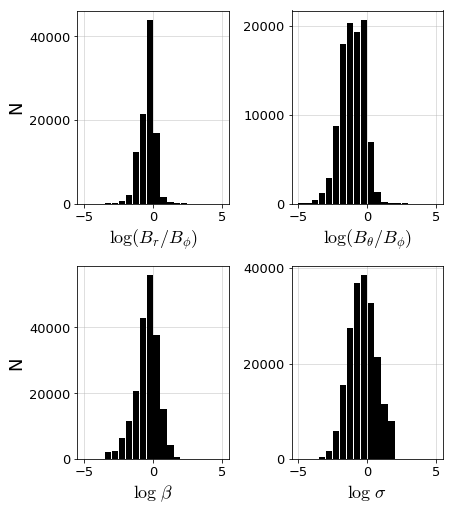

In [19]:
fontsize = 13
latexsize = 18

mylabel_d = "disc"
mycolor_d = "blue"
mylabel_j = "jet"
mycolor_j = "red"

#################################3

myfilename_rd = "/work/gustavo/gyst/guidefield_r_2D_disc.dat"
myfilename_rj = "/work/gustavo/gyst/guidefield_r_2D_jet.dat"

myfile_rd = open(myfilename_rd, "r")
mydata_rd = pd.read_csv(myfilename_rd, header=None)
BrBphiext_d = mydata_rd.values
#BrBphiext_filt_d = BrBphiext_d[~is_outlier(BrBphiext_d)]
BrBphiext_filt_d = BrBphiext_d
BrBphiext_filt_d = np.array(BrBphiext_filt_d)
BrBphiext_large_d = BrBphiext_d[BrBphiext_d >= 1]
BrBphiext_large_d = BrBphiext_large_d[~is_outlier(BrBphiext_large_d)]
BrBphiext_large_d = np.array(BrBphiext_large_d)
myfile_rd.close()

myfile_rj = open(myfilename_rj, "r")
mydata_rj = pd.read_csv(myfilename_rj, header=None)
BrBphiext_j = mydata_rj.values
#BrBphiext_filt_j = BrBphiext_j[~is_outlier(BrBphiext_j)]
BrBphiext_filt_j = BrBphiext_j
BrBphiext_filt_j = np.array(BrBphiext_filt_j)
BrBphiext_large_j = BrBphiext_j[BrBphiext_j >= 1]
BrBphiext_large_j = BrBphiext_large_j[~is_outlier(BrBphiext_large_j)]
BrBphiext_large_j = np.array(BrBphiext_large_j)
myfile_rj.close()

histmin_rd = np.log10(((array(BrBphiext_filt_d)).min()).astype(float))
histmax_rd = np.log10(((array(BrBphiext_filt_d)).max()).astype(float))

histmin_rj = np.log10(((array(BrBphiext_filt_j)).min()).astype(float))
histmax_rj = np.log10(((array(BrBphiext_filt_j)).max()).astype(float))

histmin_large_rd = np.log10(((array(BrBphiext_large_d)).min()).astype(float))
histmax_large_rd = np.log10(((array(BrBphiext_large_d)).max()).astype(float))

histmin_large_rj = np.log10(((array(BrBphiext_large_j)).min()).astype(float))
histmax_large_rj = np.log10(((array(BrBphiext_large_j)).max()).astype(float))

BrBphiext_filt = np.concatenate((np.array(BrBphiext_filt_d), np.array(BrBphiext_filt_j)))
################################



myfilename_thd = "/work/gustavo/gyst/guidefield_th_2D_disc.dat"
myfilename_thj = "/work/gustavo/gyst/guidefield_th_2D_jet.dat"

myfile_thd = open(myfilename_thd, "r")
mydata_thd = pd.read_csv(myfilename_thd, header=None)
BthBphiext_d = mydata_thd.values
#BthBphiext_filt_d = BthBphiext_d[~is_outlier(BthBphiext_d)]
BthBphiext_filt_d = BthBphiext_d
BthBphiext_filt_d = np.array(BthBphiext_filt_d)
BthBphiext_large_d = BthBphiext_d[BthBphiext_d >= 1]
BthBphiext_large_d = BthBphiext_large_d[~is_outlier(BthBphiext_large_d)]
BthBphiext_large_d = np.array(BthBphiext_large_d)
myfile_thd.close()

myfile_thj = open(myfilename_thj, "r")
mydata_thj = pd.read_csv(myfilename_thj, header=None)
BthBphiext_j = mydata_thj.values
#BthBphiext_filt_j = BthBphiext_j[~is_outlier(BthBphiext_j)]
BthBphiext_filt_j = BthBphiext_j
BthBphiext_filt_j = np.array(BthBphiext_filt_j)
BthBphiext_large_j = BthBphiext_j[BthBphiext_j >= 1]
BthBphiext_large_j = BthBphiext_large_j[~is_outlier(BthBphiext_large_j)]
BthBphiext_large_j = np.array(BthBphiext_large_j)
myfile_thj.close()

histmin_thd = np.log10(((array(BthBphiext_filt_d)).min()).astype(float))
histmax_thd = np.log10(((array(BthBphiext_filt_d)).max()).astype(float))

histmin_thj = np.log10(((array(BthBphiext_filt_j)).min()).astype(float))
histmax_thj = np.log10(((array(BthBphiext_filt_j)).max()).astype(float))

histmin_large_thd = np.log10(((array(BthBphiext_large_d)).min()).astype(float))
histmax_large_thd = np.log10(((array(BthBphiext_large_d)).max()).astype(float))

histmin_large_thj = np.log10(((array(BthBphiext_large_j)).min()).astype(float))
histmax_large_thj = np.log10(((array(BthBphiext_large_j)).max()).astype(float))

BthBphiext_filt = np.concatenate((np.array(BthBphiext_filt_d), np.array(BthBphiext_filt_j)))


####################################

myfilename_bd = "/work/gustavo/gyst/beta_2D_disc.dat"
myfilename_bj = "/work/gustavo/gyst/beta_2D_jet.dat"

myfile_bd = open(myfilename_bd, "r")
mydata_bd = pd.read_csv(myfilename_bd, header=None)
betaext_d = mydata_bd.values
#betaext_filt_d = betaext_d[~is_outlier(betaext_d)]
betaext_filt_d = betaext_d
betaext_filt_d = np.array(betaext_filt_d)
betaext_small_d = betaext_d[betaext_d < 1]
betaext_small_d = np.array(betaext_small_d)
myfile_bd.close()

myfile_bj = open(myfilename_bj, "r")
mydata_bj = pd.read_csv(myfilename_bj, header=None)
betaext_j = mydata_bj.values
#betaext_filt_j = betaext_j[~is_outlier(betaext_j)]
betaext_filt_j = betaext_j
betaext_filt_j = np.array(betaext_filt_j)
betaext_small_j = betaext_j[betaext_j < 1]
betaext_small_j = np.array(betaext_small_j)
myfile_bj.close()

histmin_bd = np.log10(((array(betaext_filt_d)).min()).astype(float))
histmax_bd = np.log10(((array(betaext_filt_d)).max()).astype(float))

histmin_bj = np.log10(((array(betaext_filt_j)).min()).astype(float))
histmax_bj = np.log10(((array(betaext_filt_j)).max()).astype(float))

histmin_small_bd = np.log10(((array(betaext_small_d)).min()).astype(float))
histmax_small_bd = np.log10(((array(betaext_small_d)).max()).astype(float))

histmin_small_bj = np.log10(((array(betaext_small_j)).min()).astype(float))
histmax_small_bj = np.log10(((array(betaext_small_j)).max()).astype(float))

betaext_filt = np.concatenate((np.array(betaext_filt_d), np.array(betaext_filt_j)))

################################

myfilename_sd = "/work/gustavo/gyst/sigma_2D_disc.dat"
myfilename_sj = "/work/gustavo/gyst/sigma_2D_jet.dat"

myfile_sd = open(myfilename_sd, "r")
mydata_sd = pd.read_csv(myfilename_sd, header=None)
sigmaext_d = mydata_sd.values
#sigmaext_filt_d = sigmaext_d[~is_outlier(sigmaext_d)]
sigmaext_filt_d = sigmaext_d
sigmaext_filt_d = np.array(sigmaext_filt_d)
sigmaext_large_d = sigmaext_d[sigmaext_d >= 1]
sigmaext_large_d = np.array(sigmaext_large_d)
myfile_sd.close()

myfile_sj = open(myfilename_sj, "r")
mydata_sj = pd.read_csv(myfilename_sj, header=None)
sigmaext_j = mydata_sj.values
#sigmaext_filt_j = sigmaext_j[~is_outlier(sigmaext_j)]
sigmaext_filt_j = sigmaext_j
sigmaext_filt_j = np.array(sigmaext_filt_j)
sigmaext_large_j = sigmaext_j[sigmaext_j >= 1]
sigmaext_large_j = np.array(sigmaext_large_j)
myfile_sj.close()

histmin_sd = np.log10(((array(sigmaext_filt_d)).min()).astype(float))
histmax_sd = np.log10(((array(sigmaext_filt_d)).max()).astype(float))

histmin_sj = np.log10(((array(sigmaext_filt_j)).min()).astype(float))
histmax_sj = np.log10(((array(sigmaext_filt_j)).max()).astype(float))

histmin_large_sd = np.log10(((array(sigmaext_large_d)).min()).astype(float))
histmax_large_sd = np.log10(((array(sigmaext_large_d)).max()).astype(float))

histmin_large_sj = np.log10(((array(sigmaext_large_j)).min()).astype(float))
histmax_large_sj = np.log10(((array(sigmaext_large_j)).max()).astype(float))

sigmaext_filt = np.concatenate((np.array(sigmaext_filt_d), np.array(sigmaext_filt_j)))

##################################


hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


#################################



hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])
plt.hist(np.log10(BrBphiext_filt), bins=20, rwidth=0.9, range=[-5,5], color='black', zorder=2)
#plt.hist(np.log10(betaext_filt_d), bins=20, rwidth=0.9, range=[-5,10], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\log(B_r/B_\phi)$", fontsize=latexsize)
plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
#plt.legend(loc="best")
plt.xticks([-5,0,5],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax2 = plt.subplot(gs[0,1])
plt.hist(np.log10(BthBphiext_filt), bins=20, rwidth=0.9, range=[-5,5], color='black', zorder=2)
#plt.hist(np.log10(sigmaext_filt_d), bins=20, rwidth=0.9, range=[-13,2], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\log(B_\theta/B_\phi)$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
#plt.legend(loc="best")
plt.xticks([-5,0,5],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax3 = plt.subplot(gs[1,0])
plt.hist(np.log10(betaext_filt), bins=20, rwidth=0.9, range=[-5,5], color='black', zorder=2)
#plt.hist(np.log10(betaext_filt_j), bins=20, rwidth=0.9, range=[-4,4], label="jet", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\log\;\beta$", fontsize=latexsize)
plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
#plt.legend(loc="best")
plt.xticks([-5,0,5],fontsize=fontsize)
#plt.xticks([-4,-2,0,2,4],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax4 = plt.subplot(gs[1,1])
plt.hist(np.log10(sigmaext_filt), bins=20, rwidth=0.9, range=[-5,5], color='black', zorder=2)
#plt.hist(np.log10(sigmaext_filt_j), bins=20, rwidth=0.9, range=[-10,2], label="jet", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\log\;\sigma$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
#plt.legend(loc="best")
#plt.xticks([-10,-7,-4,-1,2],fontsize=fontsize)
plt.xticks([-5,0,5],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

savef=1
if (savef):
    plt.savefig("log_allquantities_2D", dpi=150)

In [38]:
mean_BrBphi_d = np.mean(BrBphiext_filt_d)
std_BrBphi_d = np.std(BrBphiext_filt_d)
median_BrBphi_d = np.median(BrBphiext_filt_d)

mean_BrBphi_j = np.mean(BrBphiext_filt_j)
std_BrBphi_j = np.std(BrBphiext_filt_j)
median_BrBphi_j = np.median(BrBphiext_filt_j)

mean_BthBphi_d = np.mean(BthBphiext_filt_d)
std_BthBphi_d = np.std(BthBphiext_filt_d)
median_BthBphi_d = np.median(BthBphiext_filt_d)

mean_BthBphi_j = np.mean(BthBphiext_filt_j)
std_BthBphi_j = np.std(BthBphiext_filt_j)
median_BthBphi_j = np.median(BthBphiext_filt_j)

mean_beta_d = np.mean(betaext_filt_d)
std_beta_d = np.std(betaext_filt_d)
median_beta_d = np.median(betaext_filt_d)

mean_beta_j = np.mean(betaext_filt_j)
std_beta_j = np.std(betaext_filt_j)
median_beta_j = np.median(betaext_filt_j)

mean_sigma_d = np.mean(sigmaext_filt_d)
std_sigma_d = np.std(sigmaext_filt_d)
median_sigma_d = np.median(sigmaext_filt_d)

mean_sigma_j = np.mean(sigmaext_filt_j)
std_sigma_j = np.std(sigmaext_filt_j)
median_sigma_j = np.median(sigmaext_filt_j)

mean_BrBphi = np.mean(BrBphiext_filt)
std_BrBphi = np.std(BrBphiext_filt)
median_BrBphi = np.median(BrBphiext_filt)

mean_BthBphi = np.mean(BthBphiext_filt)
std_BthBphi = np.std(BthBphiext_filt)
median_BthBphi = np.median(BthBphiext_filt)

mean_beta = np.mean(betaext_filt)
std_beta = np.std(betaext_filt)
median_beta = np.median(betaext_filt)

mean_sigma = np.mean(sigmaext_filt)
std_sigma = np.std(sigmaext_filt)
median_sigma = np.median(sigmaext_filt)

In [39]:
mean_BrBphi_d,std_BrBphi_d,median_BrBphi_d

(1.2548071287174316, 42.01198993905155, 0.5678991999999999)

In [40]:
mean_BrBphi_j,std_BrBphi_j,median_BrBphi_j

(55.60525906284895, 11719.960114752672, 0.46762974)

In [41]:
mean_BthBphi_d,std_BthBphi_d,median_BthBphi_d

(0.6696990535465749, 23.407358849918676, 0.11773826)

In [42]:
mean_BthBphi_j,std_BthBphi_j,median_BthBphi_j

(30.850149262582153, 6523.679549568984, 0.073907901)

In [43]:
mean_beta_d,std_beta_d,median_beta_d

(1.3306500295685344, 6.84101910942506, 0.3610842387420723)

In [44]:
mean_beta_j,std_beta_j,median_beta_j

(2.042919971169761, 17.15801299937015, 0.48191720723652587)

In [45]:
mean_sigma_d,std_sigma_d,median_sigma_d

(2.694539110463822, 7.977894670831702, 0.33198657349347205)

In [46]:
mean_sigma_j,std_sigma_j,median_sigma_j

(4.918755807207323, 10.587787899966797, 0.6153831535986505)

In [47]:
mean_BrBphi,std_BrBphi,median_BrBphi

(29.74028027601073, 8484.788644583874, 0.5204935)

In [48]:
mean_BthBphi,std_BthBphi,median_BthBphi

(16.487495841043398, 4722.886501059548, 0.09169938400000001)

In [49]:
mean_beta,std_beta,median_beta

(1.704050622089771, 13.293865184489723, 0.42295619219811664)

In [50]:
mean_sigma,std_sigma,median_sigma

(3.860563090912278, 9.501708026552548, 0.44060798720576644)

In [44]:
highBr_d = [element for element in BrBphiext_filt_d if element >= 1]
highBth_d = [element for element in BthBphiext_filt_d if element >= 1]
highbeta_d = [element for element in betaext_filt_d if element <= 1]
highsigma_d = [element for element in sigmaext_filt_d if element >= 1]
highBr_j = [element for element in BrBphiext_filt_j if element >= 1]
highBth_j = [element for element in BthBphiext_filt_j if element >= 1]
highbeta_j = [element for element in betaext_filt_j if element <= 1]
highsigma_j = [element for element in sigmaext_filt_j if element >= 1]

In [45]:
pBr_d = len(highBr_d)/len(BrBphiext_filt_d)*100
pBr_j = len(highBr_j)/len(BrBphiext_filt_j)*100
pBth_d = len(highBth_d)/len(BthBphiext_filt_d)*100
pBth_j = len(highBth_j)/len(BthBphiext_filt_j)*100
pbeta_d = len(highbeta_d)/len(betaext_filt_d)*100
pbeta_j = len(highbeta_j)/len(betaext_filt_j)*100
psigma_d = len(highsigma_d)/len(sigmaext_filt_d)*100
psigma_j = len(highsigma_j)/len(sigmaext_filt_j)*100

In [46]:
for index in [pBr_d,pBr_j,pBth_d,pBth_j,pbeta_d,pbeta_j,psigma_d,psigma_j]:
    print(index)

29.38773039556914
26.81189661408341
2.157925002269907
2.729321425590518
76.20229411942738
68.49734301532983
31.38222208770921
40.80766769607434


<Figure size 432x288 with 0 Axes>

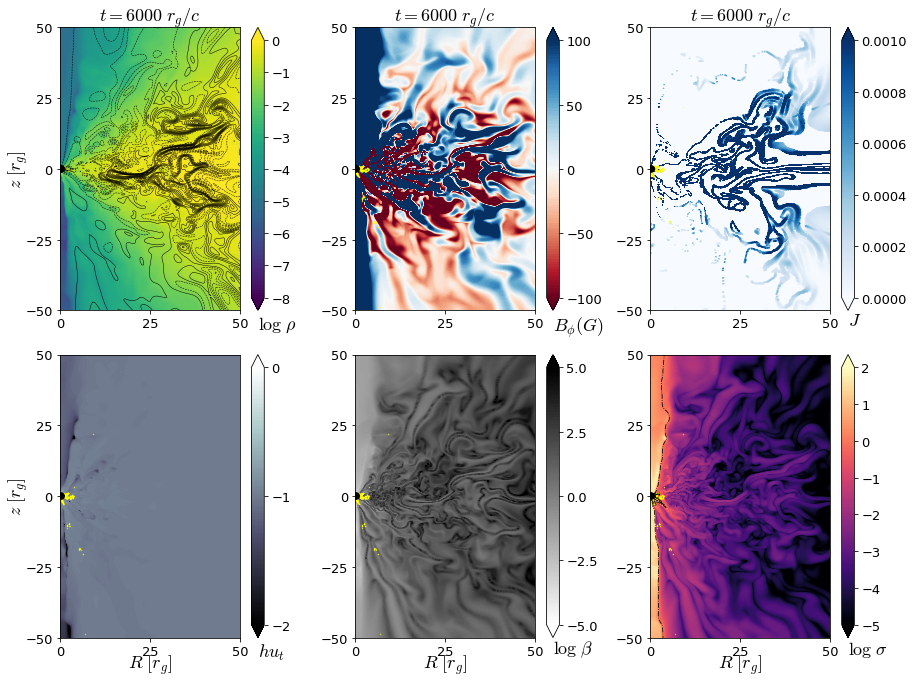

In [87]:
disc = 1
jet = 0

plt.clf()
if (disc):
    myfigname = dumpname+"_quantities_2D_disc.png"
    rx = rx_d
    ry = ry_d
elif (jet):
    myfigname = dumpname+"_quantities_2D_jet.png"
    rx = rx_j
    ry = ry_j

savef = 0
fontsize = 13
latexsize = 18

mirror = 1
if(mirror):
    xmin = 0
    xmax = 50
    ymin = -xmax
    ymax = xmax
    step = xmax/2
else:
    xmin = 0
    xmax = 10
    ymin = 0
    ymax = 20
    step = 5

hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[12.8, 9.6])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,3)


ax1 = plt.subplot(gs[0,0])
aphi=psicalc()
amax = aphi.max()
cs1,cb1 = plc(np.log10(rho),
              levels=np.linspace(-8, 0, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax,
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1,
              fntsize=fontsize)
ax1 = plt.gca()
#ax1.set_xlabel(r"$R\ [r_g]$",fontsize=latexsize,labelpad=-5, **hfont)
ax1.set_ylabel(r"$z\ [r_g]$",fontsize=latexsize,labelpad=-5, **hfont)
cb1.ax.set_xlabel(r"$\log\;\rho$",fontsize=latexsize,ha="left")
cb1.set_ticks([-8,-7,-6,-5,-4,-3,-2,-1,0])
if(mirror):
    ax1.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax1.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax1.tick_params(axis="x", labelsize=fontsize)
    ax1.tick_params(axis="y", labelsize=fontsize)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(0,ymax+1)
plc(aphi,levels=np.linspace(-amax,amax,20)[1:-1],colors="black",linewidths=0.5,xy=-1)
ax1.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=latexsize)

ax2 = plt.subplot(gs[0,1])
cs2,cb2 = plc(Bphi*B_unit, 
              levels=np.linspace(-100, 100, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax,
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='RdBu',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)
ax2 = plt.gca()
#ax2.set_xlabel(r"$R\ [r_g]$",fontsize=latexsize,labelpad=-5)
#ax2.set_ylabel(r"$z\ [r_g]$",fontsize=latexsize,labelpad=-5)
cb2.ax.set_xlabel(r"$B_\phi(G)$",fontsize=latexsize,ha="left")
cb2.set_ticks([-100,-50,0,50,100])
if(mirror):
    ax2.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax2.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax2.tick_params(axis="x", labelsize=fontsize)
    ax2.tick_params(axis="y", labelsize=fontsize)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(0,ymax+1)
ax2.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=latexsize)

ax3 = plt.subplot(gs[0,2])
cs3,cb3 = plc(JJ_cs, 
              levels=np.linspace(0,10e-4,100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax, 
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='Blues',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)
ax3 = plt.gca()
#ax3.set_xlabel(r"$R\ [r_g]$",fontsize=latexsize,labelpad=-5)
#ax3.set_ylabel(r"$z\ [r_g]$",fontsize=latexsize,labelpad=-5)
cb3.ax.set_xlabel(r"$J$",fontsize=latexsize, labelpad=1, ha="left")
cb3.set_ticks([0,0.0002,0.0004,0.0006,0.0008,0.001])
if(mirror):
    ax3.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax3.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax3.tick_params(axis="x", labelsize=fontsize)
    ax3.tick_params(axis="y", labelsize=fontsize)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(0,ymax+1)
ax3.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=latexsize)

ax4 = plt.subplot(gs[1,0])
cs4,cb4 = plc(unb,
              levels = np.linspace(-2,0, 100),
              isfilled=1,
              k=0,
              xy=1,
              xmax=xmax,
              ymax=ymax,
              dobh=1,
              cb=1,
              extend="both",
              pretty=1,
              cmap = 'bone',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)
ax4 = plt.gca()
ax4.set_xlabel(r"$R\ [r_g]$",fontsize=latexsize,labelpad=-5, **hfont)
ax4.set_ylabel(r"$z\ [r_g]$",fontsize=latexsize,labelpad=-5, **hfont)
cb4.ax.set_xlabel(r"$hu_t$",fontsize=latexsize,ha="left")
cb4.set_ticks([-2,-1,0])
if(mirror):
    ax4.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax4.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax4.tick_params(axis="x", labelsize=fontsize)
    ax4.tick_params(axis="y", labelsize=fontsize)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(0,ymax+1)
#ax4.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=latexsize)

ax5 = plt.subplot(gs[1,1])
cs5,cb5 = plc(np.log10(betapl), 
              levels=np.linspace(-5, 5, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax, 
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='binary',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)
ax5 = plt.gca()
ax5.set_xlabel(r"$R\ [r_g]$",fontsize=latexsize,labelpad=-5)
#ax5.set_ylabel(r"$z\ [r_g]$",fontsize=latexsize,labelpad=-5)
cb5.ax.set_xlabel(r"$\log\;\beta$",fontsize=latexsize, labelpad=1, ha="left")
cb5.set_ticks([-5,-2.5,0,2.5,5])
if(mirror):
    ax5.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax5.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax5.tick_params(axis="x", labelsize=fontsize)
    ax5.tick_params(axis="y", labelsize=fontsize)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(0,ymax+1)
#ax5.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=latexsize)

"""
ax6 = plt.subplot(gs[1,2])
cs6,cb6 = plc(np.log10(sigma), 
              levels=np.linspace(-5, 2, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax, 
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='magma',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)
ax6 = plt.gca()
ax6.set_xlabel(r"$R\ [r_g]$",fontsize=latexsize,labelpad=-5)
#ax6.set_ylabel(r"$z\ [r_g]$",fontsize=latexsize,labelpad=-5)
cb6.ax.set_xlabel(r"$\log\;\sigma$",fontsize=latexsize, labelpad=1, ha="left")
cb6.set_ticks([-5,-4,-3,-2,-1,0,1,2])
if(mirror):
    ax6.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax6.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax6.tick_params(axis="x", labelsize=fontsize)
    ax6.tick_params(axis="y", labelsize=fontsize)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(0,ymax+1)
#ax6.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=latexsize)
plt.tight_layout()
"""

ax6 = plt.subplot(gs[1,2])
cs6,cb6 = plc(np.log10(sigma), 
              levels=np.linspace(-5,2, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax, 
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='magma',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)
plt.contour(r2d, z2d, np.log10(sigma2d), levels=[0], colors=('black'), linestyles=('-.'), linewidths=(0.8))
ax6 = plt.gca()
ax6.set_xlabel(r"$R\ [r_g]$",fontsize=latexsize,labelpad=-5)
#ax6.set_ylabel(r"$z\ [r_g]$",fontsize=latexsize,labelpad=-5)
cb6.ax.set_xlabel(r"$\log\;\sigma$",fontsize=latexsize, labelpad=1, ha="left")
cb6.set_ticks([-5,-4,-3,-2,-1,0,1,2])
if(mirror):
    ax6.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax6.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax6.tick_params(axis="x", labelsize=fontsize)
    ax6.tick_params(axis="y", labelsize=fontsize)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(0,ymax+1)
#ax6.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=latexsize)
plt.tight_layout()


savef=1
if (savef):
    plt.savefig(myfigname, dpi = 150)


<Figure size 432x288 with 0 Axes>

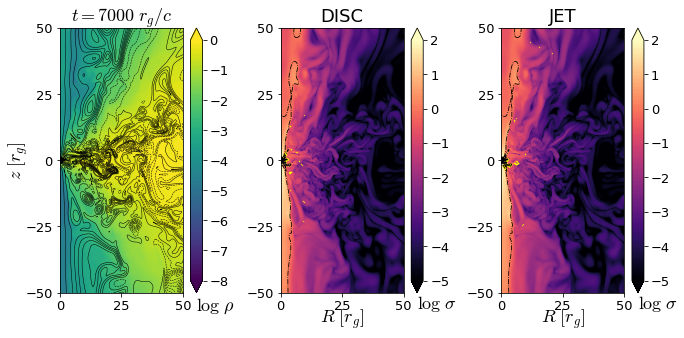

In [51]:
myfigname = dumpname+"_rho_sigma_2D.png"

plt.clf()

savef = 0
fontsize = 13
latexsize = 18

mirror = 1
if(mirror):
    xmin = 0
    xmax = 50
    ymin = -xmax
    ymax = xmax
    step = xmax/2
else:
    xmin = 0
    xmax = 10
    ymin = 0
    ymax = 20
    step = 5

hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4+3.2, 4.8])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(1,3)


ax1 = plt.subplot(gs[0,0])
aphi=psicalc()
amax = aphi.max()
cs1,cb1 = plc(np.log10(rho),
              levels=np.linspace(-8, 0, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax,
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1,
              fntsize=fontsize)
ax1 = plt.gca()
#ax1.set_xlabel(r"$R\ [r_g]$",fontsize=latexsize,labelpad=-5, **hfont)
ax1.set_ylabel(r"$z\ [r_g]$",fontsize=latexsize,labelpad=-5, **hfont)
cb1.ax.set_xlabel(r"$\log\;\rho$",fontsize=latexsize,ha="left")
cb1.set_ticks([-8,-7,-6,-5,-4,-3,-2,-1,0])
if(mirror):
    ax1.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax1.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax1.tick_params(axis="x", labelsize=fontsize)
    ax1.tick_params(axis="y", labelsize=fontsize)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(0,ymax+1)
plc(aphi,levels=np.linspace(-amax,amax,20)[1:-1],colors="black",linewidths=0.5,xy=-1)
ax1.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=latexsize)

ax2 = plt.subplot(gs[0,1])
cs2,cb2 = plc(np.log10(sigma), 
              levels=np.linspace(-5,2, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax, 
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='magma',
              fntsize=fontsize)
plt.scatter(rx_d, ry_d, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)
plt.contour(r2d, z2d, np.log10(sigma2d), levels=[0], colors=('black'), linestyles=('-.'), linewidths=(0.8))
ax2 = plt.gca()
ax2.set_xlabel(r"$R\ [r_g]$",fontsize=latexsize,labelpad=-5)
#ax6.set_ylabel(r"$z\ [r_g]$",fontsize=latexsize,labelpad=-5)
cb2.ax.set_xlabel(r"$\log\;\sigma$",fontsize=latexsize, labelpad=1, ha="left")
cb2.set_ticks([-5,-4,-3,-2,-1,0,1,2])
if(mirror):
    ax2.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax2.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax2.tick_params(axis="x", labelsize=fontsize)
    ax2.tick_params(axis="y", labelsize=fontsize)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(0,ymax+1)
#ax2.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=latexsize)
ax2.set_title("DISC", fontsize=latexsize)


ax3 = plt.subplot(gs[0,2])
cs3,cb3 = plc(np.log10(sigma), 
              levels=np.linspace(-5,2, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax, 
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='magma',
              fntsize=fontsize)
plt.scatter(rx_j, ry_j, c ='yellow', marker = 'o', s = 0.1)#, markersize = 0.01)
plt.contour(r2d, z2d, np.log10(sigma2d), levels=[0], colors=('black'), linestyles=('-.'), linewidths=(0.8))
ax3 = plt.gca()
ax3.set_xlabel(r"$R\ [r_g]$",fontsize=latexsize,labelpad=-5)
#ax6.set_ylabel(r"$z\ [r_g]$",fontsize=latexsize,labelpad=-5)
cb3.ax.set_xlabel(r"$\log\;\sigma$",fontsize=latexsize, labelpad=1, ha="left")
cb3.set_ticks([-5,-4,-3,-2,-1,0,1,2])
if(mirror):
    ax3.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax3.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax3.tick_params(axis="x", labelsize=fontsize)
    ax3.tick_params(axis="y", labelsize=fontsize)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax+1)
    plt.ylim(0,ymax+1)
#ax3.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=latexsize)
ax3.set_title("JET", fontsize=latexsize)

plt.tight_layout()


savef=1
if (savef):
    plt.savefig(myfigname, dpi = 150)


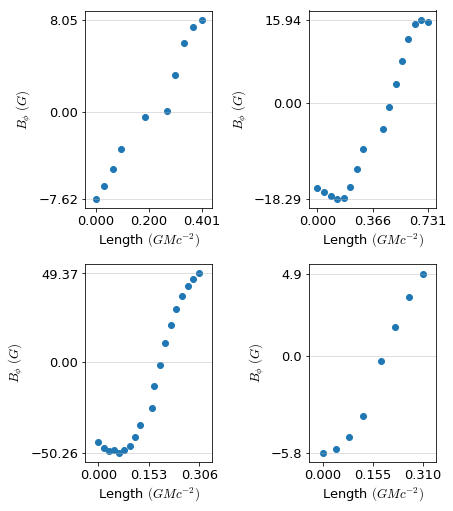

In [67]:
myfilename = ["/work/gustavo/gyst/sheets/dump506_187_443_0_s",
              "/work/gustavo/gyst/sheets/dump520_175_27_0_s",
              "/work/gustavo/gyst/sheets/dump532_90_186_0_s",
              "/work/gustavo/gyst/sheets/dump540_210_95_0_s",
              "/work/gustavo/gyst/sheets/dump547_79_433_0_s"]

icenter=[187,175,90,210,79]
jcenter=[443,27,186,95,433]

posno = []
xminl = []
xmidl = []
xmaxl = []
yminl = []
ymaxl = []
Bphisheet = []

for sheetno in range(len(myfilename)):
    
    myfile = open(myfilename[sheetno], "rb")
    dtype = np.float64
    body = np.fromfile(myfile,dtype=dtype,count=-1)
    ind2 = int((len(body))/10)
    mydata = body.view().reshape((10,ind2), order='F')

    myBr       = mydata[0]
    myBth      = mydata[1]
    myBphi     = mydata[2]
    myJ        = mydata[3]
    mybeta     = mydata[4]
    mysigma    = mydata[5]
    mysigmaphi = mydata[6]
    myi        = mydata[7]
    myj        = mydata[8]

    myfile.close()

    position = []
    for ii in range(len(myBr)):
        if ii == 0:
            distance = 0
            distanceold = 0
        else:
            r1 = r[int(myi[ii])][int(myj[ii])][0]
            r2 = r[int(myi[ii-1])][int(myj[ii-1])][0]
            th1 = h[int(myi[ii])][int(myj[ii])][0]
            th2 = h[int(myi[ii-1])][int(myj[ii-1])][0]
            distance = np.sqrt(r1*r1 + r2*r2 - 2*r1*r2*np.cos(th1 - th2)) + distanceold
            distanceold = distance
        position.append(distance)
    position = np.array(position)

    xmin = round(min(position), 3)
    xmax = round(max(position), 3)
    xmid = round((xmax-xmin)/2, 3)
    xmmin = round((xmid-xmin)/2, 3)
    xmmax = round(xmax-xmid/2, 3)
    ymin1 = round(min(myBphi)*B_unit, 3)
    ymax1 = round(max(myBphi)*B_unit, 3)
    ymid1 = round(0.5*(ymax1+ymin1), 3)

    xminl.append(xmin)
    xmidl.append(xmid)
    xmaxl.append(xmax)
    yminl.append(ymin1)
    ymaxl.append(ymax1)
    Bphisheet.append(myBphi)
    
    #yticks[sheetno] = [ymin1,0,ymax1]
    posno.append(position)


color = 'tab:blue'
hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)

Bphisheet[0] = np.flip(Bphisheet[0])
Bphisheet[1] = np.flip(Bphisheet[1])
Bphisheet[2] = np.flip(Bphisheet[2])

Bphisheet[1] = np.delete(Bphisheet[1], 8)
Bphisheet[1] = np.delete(Bphisheet[1], 8)
posno[1] = np.delete(posno[1], 8)
posno[1] = np.delete(posno[1], 8)

Bphisheet[2] = np.delete(Bphisheet[2], 9)
posno[2] = np.delete(posno[2], 9)

ax1 = plt.subplot(gs[0,0])
ax1.scatter(posno[0], Bphisheet[0]*B_unit, color=color)
_, max_ = plt.ylim()
plt.xlabel(r'Length $(GMc^{-2})$', fontsize=13)
plt.ylabel(r'$B_\phi\;(G)$', fontsize=13)
plt.grid(axis='y', alpha=0.5)
xticks = [xminl[0],xmidl[0],xmaxl[0]]
yticks = [yminl[0],0,ymaxl[0]]
plt.xticks(xticks, fontsize=13)
plt.yticks(yticks, fontsize=13)
plt.tight_layout()

ax2 = plt.subplot(gs[0,1])
ax2.scatter(posno[1], Bphisheet[1]*B_unit, color=color)
_, max_ = plt.ylim()
plt.xlabel(r'Length $(GMc^{-2})$', fontsize=13)
plt.ylabel(r'$B_\phi\;(G)$', fontsize=13)
plt.grid(axis='y', alpha=0.5)
xticks = [xminl[1],xmidl[1],xmaxl[1]]
yticks = [yminl[1],0,ymaxl[1]]
plt.xticks(xticks, fontsize=13)
plt.yticks(yticks, fontsize=13)
plt.tight_layout()

ax3 = plt.subplot(gs[1,0])
ax3.scatter(posno[2], Bphisheet[2]*B_unit, color=color)
_, max_ = plt.ylim()
plt.xlabel(r'Length $(GMc^{-2})$', fontsize=13)
plt.ylabel(r'$B_\phi\;(G)$', fontsize=13)
plt.grid(axis='y', alpha=0.5)
xticks = [xminl[2],xmidl[2],xmaxl[2]]
yticks = [yminl[2],0,ymaxl[2]]
plt.xticks(xticks, fontsize=13)
plt.yticks(yticks, fontsize=13)
plt.tight_layout()

ax4 = plt.subplot(gs[1,1])
ax4.scatter(posno[3], Bphisheet[3]*B_unit, color=color)
_, max_ = plt.ylim()
plt.xlabel(r'Length $(GMc^{-2})$', fontsize=13)
plt.ylabel(r'$B_\phi\;(G)$', fontsize=13)
plt.grid(axis='y', alpha=0.5)
xticks = [xminl[3],xmidl[3],xmaxl[3]]
yticks = [yminl[3],0,ymaxl[3]]
plt.xticks(xticks, fontsize=13)
plt.yticks(yticks, fontsize=13)
plt.tight_layout()

savef=0
if (savef):
    plt.savefig("sheet_examples.png", dpi=150)

## GET FLUXES

In [56]:
ts = []
fs = []
md = []
#jem = []
#jtot = []

starti,endi=0,700
for dumpno in range(starti,endi+1):
    rd("dump%03d" % dumpno);

    rhor = 1+(1-a**2)**0.5
    ihor = iofr(rhor)
    #cvel()
    Tcalcud()
    ts.append(int(t)) #time
    fs.append(horfluxcalc(ihor)) #horizon flux
    md.append(mdotcalc(ihor)) #mass accretion rate
    #jem.append(jetpowcalc(0)[ihor]) #jet power (EM)
    #jtot.append(jetpowcalc(2)[ihor]) #jet power (total)

harm_script2.py:1019: RuntimeWarning: divide by zero encountered in true_divide
  mu = -Tud[1,0]/(rho*uu[1])
harm_script2.py:1019: RuntimeWarning: invalid value encountered in true_divide
  mu = -Tud[1,0]/(rho*uu[1])
harm_script2.py:1020: RuntimeWarning: divide by zero encountered in true_divide
  sigma = TudEM[1,0]/TudMA[1,0]
harm_script2.py:1020: RuntimeWarning: invalid value encountered in true_divide
  sigma = TudEM[1,0]/TudMA[1,0]
harm_script2.py:738: RuntimeWarning: invalid value encountered in sqrt
  jcurr = np.sqrt(jsq)


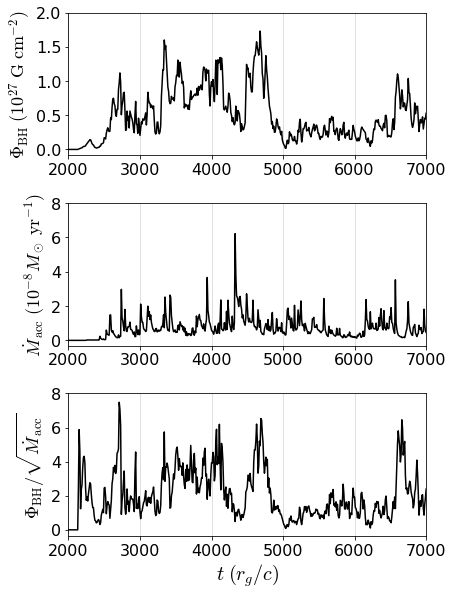

In [248]:
fs = np.array(fs)
fs_units = fs*B_unit*L_unit*L_unit
md = np.array(md)
md_units = md*M_unit/T_unit
phiflux = fs/np.sqrt(md)
phiflux = np.array(phiflux)

myfigname = "fluxes_2D.png"

hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 8.4])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(3,1)

ax1 = plt.subplot(gs[0,0])
ax1.plot(ts,fs_units*10**-27,color="black")
_, max_ = plt.ylim()
#plt.xlim(2000,7000)
plt.xticks([2000,3000,4000,5000,6000,7000],fontsize=fontsize)
plt.yticks([0,0.5,1.0,1.5,2.0],fontsize=fontsize)
plt.setp(ax1.get_xticklabels(), visible=True)
#plt.xlabel(r"$t\;(r_g/c)$")
plt.ylabel(r"$\Phi_\mathrm{BH}\;(10^{27}\;\mathrm{G}\;\mathrm{cm}^{-2})$", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5)

ax2 = plt.subplot(gs[1,0], sharex=ax1)
ax2.plot(ts,md_units*10**8/MSUN*YEAR,color="black")
_, max_ = plt.ylim()
#plt.xlim(2000,7000)
plt.xticks([2000,3000,4000,5000,6000,7000],fontsize=fontsize)
plt.yticks([0,2,4,6,8],fontsize=fontsize)
#plt.xlabel(r"$t\;(r_g/c)$")
plt.ylabel(r"$\dot M_\mathrm{acc}\;(10^{-8}M_\odot\;\mathrm{yr}^{-1})$", fontsize=latexsize)
plt.setp(ax2.get_xticklabels(), visible=True)
plt.grid(axis='x', alpha=0.5)

ax3 = plt.subplot(gs[2,0], sharex=ax1)
ax3.plot(ts,phiflux,color="black")
_, max_ = plt.ylim()
plt.xlim(2000,7000)
plt.xticks([2000,3000,4000,5000,6000,7000],fontsize=fontsize)
plt.yticks([0,2,4,6,8],fontsize=fontsize)
plt.xlabel(r"$t\;(r_g/c)$")
plt.ylabel(r"$\Phi_\mathrm{BH}/\sqrt{\dot M_\mathrm{acc}}$", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5)

plt.tight_layout()

savef = 1
if (savef):
    plt.savefig(myfigname, dpi=150)

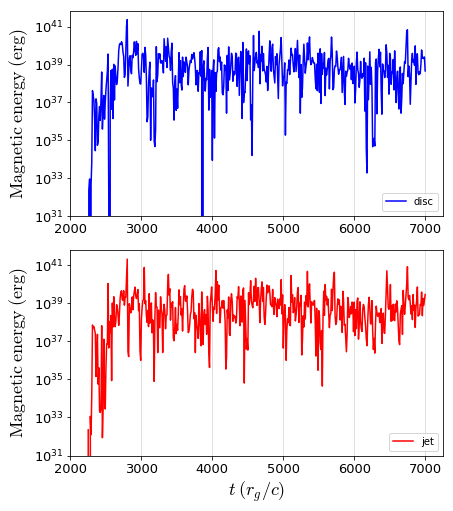

In [176]:
time = list(range(225, 701))
time = np.array(time)
time=10*time
myfigname = "magenergy_2D.png"
savef = 0

fontsize=13
latexsize=18

myfilename_d = "/work/gustavo/gyst/magenergy_2D_disc.dat"
mylabel_d = "disc"
mycolor_d = "blue"
myfilename_j = "/work/gustavo/gyst/magenergy_2D_jet.dat"
mylabel_j = "jet"
mycolor_j = "red"

myfile_d = open(myfilename_d, "r")
mydata_d = pd.read_csv(myfilename_d, header=None)
magenext_d = mydata_d.values
magenext_d = np.array(magenext_d)
myfile_d.close()

myfile_j = open(myfilename_j, "r")
mydata_j = pd.read_csv(myfilename_j, header=None)
magenext_j = mydata_j.values
magenext_j = np.array(magenext_j)
myfile_j.close()

hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,1)

ax1 = plt.subplot(gs[0,0])
ax1.plot(time,magenext_d*B_unit*B_unit*L_unit*L_unit*L_unit, color=mycolor_d, label=mylabel_d)
#ax1.plot(time,np.log10(magenext_d*B_unit*B_unit*L_unit*L_unit*L_unit), color=mycolor_d, label=mylabel_d)
ax1.set_yscale('log')
#_, max_ = plt.ylim()
#plt.ylim(0,4)
#plt.xlabel(r"$t\;(10r_g/c)$", fontsize=16)
plt.ylabel(r"$\mathrm{Magnetic\;energy}\;(\mathrm{erg})$", fontsize=latexsize)
#plt.ylabel(r"$B^2/8\pi\;(10^{38}\;\mathrm{erg})$", fontsize=18)
plt.xticks([2000,3000,4000,5000,6000,7000],fontsize=fontsize)
plt.setp(ax1.get_xticklabels(), visible=True)
plt.yticks([10**31,10**33,10**35,10**37,10**39,10**41],fontsize=fontsize)
plt.grid(axis='x', alpha=0.5)
plt.legend(loc='lower right')

ax2 = plt.subplot(gs[1,0], sharex=ax1)
ax2.plot(time,magenext_j*B_unit*B_unit*L_unit*L_unit*L_unit, color=mycolor_j, label=mylabel_j)
#ax2.plot(time,np.log10(magenext_j*B_unit*B_unit*L_unit*L_unit*L_unit), color=mycolor_j, label=mylabel_j)
ax2.set_yscale('log')
#_, max_ = plt.ylim()
#plt.ylim(0,4)
plt.xlim(2000,7250)
plt.xlabel(r"$t\;(r_g/c)$", fontsize=latexsize)
plt.ylabel(r"$\mathrm{Magnetic\;energy}\;(\mathrm{erg})$", fontsize=latexsize)
#plt.ylabel(r"$B^2/8\pi\;(10^{38}\;\mathrm{erg})$", fontsize=18)
plt.xticks([2000,3000,4000,5000,6000,7000],fontsize=fontsize)
plt.yticks([10**31,10**33,10**35,10**37,10**39,10**41],fontsize=fontsize)
plt.legend(loc='lower right')
plt.grid(axis='x', alpha=0.5)
plt.tight_layout()

savef=1
if (savef):
    plt.savefig(myfigname, dpi=150)

In [170]:
np.mean(magenext_j*B_unit*B_unit*L_unit*L_unit*L_unit)

2.662036517835333e+39

In [171]:
np.mean(magenext_d*B_unit*B_unit*L_unit*L_unit*L_unit)

3.1972729387325245e+39

## GET QUANTITIES ALL SNAPSHOTS

In [ ]:
disc=0
jet=1
savef=1

starti,endi=225,700
for dumpno in range(starti,endi+1):
    rd("dump%03d" % dumpno)
    N1, N2, N3 = nx, ny, nz
    sigma = bsq/rho
    sigmaphi = bu[3]*bd[3]/(rho)
    betapl = 2.0*pg/bsq
    bphi = bu[3]*B_unit
    Bphi = B[3]*B_unit
    #jcurr = np.nan_to_num(jcurr)
    jdotu = mdot(ju,ud)
    Jsq = jsq + jdotu*jdotu
    gJsq = gdet*Jsq
    JJJ = np.sqrt(Jsq)
    EF = rho + gam*ug
    EE = bsq + EF
    va2 = bsq/EE
    va = np.sqrt(va2)
    enth=1+ug*gam/rho
    unb=enth*ud[0]
    isunbound=(-unb>1.02)
    
    Jfile = "/work/gustavo/gyst/jcs_files/dump%03d_jcs" %dumpno
    Jfilechar = "/work/gustavo/gyst/jcs_files/dump%03d_jcs_char" %dumpno

    f1 = open(Jfile, "rb")
    dtype = np.float64
    body = np.fromfile(f1,dtype=dtype,count=-1)
    JJ_cs = body.view().reshape((int(N1),int(N2),int(N3)), order='C')
    f1.close()
    
    f3 = open(Jfilechar, "rb")
    dtype = np.float64
    body = np.fromfile(f3,dtype=dtype,count=-1)
    JJ_cs_char = body.view().reshape((int(N1),int(N2),int(N3)), order='C')
    f3.close()

    JJ_cs_char_ind = np.zeros(shape=(N1,N2,N3))
    for i in range(N1):
        for j in range(N2):
            for k in range(N3):
                if JJ_cs_char[i][j][k] > 0:
                    JJ_cs_char_ind[i][j][k] = 1

    rx = []
    ry = []
    for i in range(525):
        for j in range(N2):
            for k in range(N3):
                if (JJ_cs_char_ind[i][j][k] == 1):
                    rx.append(r[i][j][k] * np.sin(h[i][j][k]))
                    ry.append(r[i][j][k] * np.cos(h[i][j][k]))

    if (disc):
        myfigname = "/work/gustavo/gyst/quant/quantities_2D_disc_"+str(int(np.round(t)))+".png"
    elif (jet):
        myfigname = "/work/gustavo/gyst/quant/quantities_2D_jet_"+str(int(np.round(t)))+".png"

    fontsize = 16

    mirror = 0
    if(mirror):
        xmin = 0
        xmax = 50
        ymin = -xmax
        ymax = xmax
        step = xmax/2
    else:
        xmin = 0
        xmax = 10
        ymin = 0
        ymax = 20
        step = 5

    hfont = {'fontname':'Helvetica'}
    fig = plt.figure(figsize=[12.8, 9.6])
    #fig = plt.figure(figsize=[12.8, 14.4])
    gs = GridSpec(2,3)


    ax1 = plt.subplot(gs[0,0])
    aphi=psicalc()
    amax = aphi.max()
    cs1,cb1 = plc(np.log10(rho),
                  levels=np.linspace(-8, 0, 100),
                  isfilled=1, 
                  k=0, 
                  xy=1, 
                  xmax=xmax,
                  ymax=ymax, 
                  dobh=1, 
                  cb=True, 
                  extend = "both", 
                  pretty=1,
                  fntsize=fontsize)
    ax1 = plt.gca()
    ax1.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5, **hfont)
    ax1.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5, **hfont)
    cb1.ax.set_xlabel(r"$\log\;\rho$",fontsize=18,ha="left")
    cb1.set_ticks([-8,-7,-6,-5,-4,-3,-2,-1,0])
    if(mirror):
        ax1.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
        ax1.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
        ax1.tick_params(axis="x", labelsize=fontsize)
        ax1.tick_params(axis="y", labelsize=fontsize)
    else:
        plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
        plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
        plt.xlim(0,xmax)
        plt.ylim(0,ymax)
    plc(aphi,levels=np.linspace(-amax,amax,20)[1:-1],colors="black",linewidths=0.5,xy=-1)
    ax1.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)

    ax2 = plt.subplot(gs[0,1])
    cs2,cb2 = plc(Bphi*B_unit, 
                  levels=np.linspace(-100, 100, 100),
                  isfilled=1, 
                  k=0, 
                  xy=1, 
                  xmax=xmax,
                  ymax=ymax, 
                  dobh=1, 
                  cb=True, 
                  extend = "both", 
                  pretty=1, 
                  cmap='RdBu',
                  fntsize=fontsize)
    plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 5)#, markersize = 0.01)
    ax2 = plt.gca()
    ax2.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5)
    ax2.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5)
    cb2.ax.set_xlabel(r"$B_\phi(G)$",fontsize=18,ha="left")
    cb2.set_ticks([-100,-50,0,50,100])
    if(mirror):
        ax2.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
        ax2.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
        ax2.tick_params(axis="x", labelsize=fontsize)
        ax2.tick_params(axis="y", labelsize=fontsize)
    else:
        plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
        plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
        plt.xlim(0,xmax)
        plt.ylim(0,ymax)
    ax2.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)

    ax3 = plt.subplot(gs[0,2])
    cs3,cb3 = plc(JJ_cs, 
                  levels=np.linspace(0,10e-4,100),
                  isfilled=1, 
                  k=0, 
                  xy=1, 
                  xmax=xmax, 
                  ymax=ymax, 
                  dobh=1, 
                  cb=True, 
                  extend = "both", 
                  pretty=1, 
                  cmap='Blues',
                  fntsize=fontsize)
    plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 5)#, markersize = 0.01)
    ax3 = plt.gca()
    ax3.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5)
    ax3.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5)
    cb3.ax.set_xlabel(r"$J$",fontsize=18, labelpad=1, ha="left")
    cb3.set_ticks([0,0.0002,0.0004,0.0006,0.0008,0.001])
    if(mirror):
        ax3.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
        ax3.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
        ax3.tick_params(axis="x", labelsize=fontsize)
        ax3.tick_params(axis="y", labelsize=fontsize)
    else:
        plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
        plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
        plt.xlim(0,xmax)
        plt.ylim(0,ymax)
    ax3.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)

    ax4 = plt.subplot(gs[1,0])
    cs4,cb4 = plc(unb,
                  levels = np.linspace(-2,0, 100),
                  isfilled=1,
                  k=0,
                  xy=1,
                  xmax=xmax,
                  ymax=ymax,
                  dobh=1,
                  cb=1,
                  extend="both",
                  pretty=1,
                  cmap = 'bone',
                  fntsize=fontsize)
    plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 5)#, markersize = 0.01)
    ax4 = plt.gca()
    ax4.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5, **hfont)
    ax4.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5, **hfont)
    cb4.ax.set_xlabel(r"$hu_t$",fontsize=18,ha="left")
    cb4.set_ticks([-2,-1,0])
    if(mirror):
        ax4.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
        ax4.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
        ax4.tick_params(axis="x", labelsize=fontsize)
        ax4.tick_params(axis="y", labelsize=fontsize)
    else:
        plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
        plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
        plt.xlim(0,xmax)
        plt.ylim(0,ymax)
    ax4.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)

    ax5 = plt.subplot(gs[1,1])
    cs5,cb5 = plc(np.log10(betapl), 
                  levels=np.linspace(-5, 5, 100),
                  isfilled=1, 
                  k=0, 
                  xy=1, 
                  xmax=xmax, 
                  ymax=ymax, 
                  dobh=1, 
                  cb=True, 
                  extend = "both", 
                  pretty=1, 
                  cmap='binary',
                  fntsize=fontsize)
    plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 5)#, markersize = 0.01)
    ax5 = plt.gca()
    ax5.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5)
    ax5.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5)
    cb5.ax.set_xlabel(r"$\log\;\beta$",fontsize=18, labelpad=1, ha="left")
    cb5.set_ticks([-5,-2.5,0,2.5,5])
    if(mirror):
        ax5.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
        ax5.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
        ax5.tick_params(axis="x", labelsize=fontsize)
        ax5.tick_params(axis="y", labelsize=fontsize)
    else:
        plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
        plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
        plt.xlim(0,xmax)
        plt.ylim(0,ymax)
    ax5.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)

    ax6 = plt.subplot(gs[1,2])
    cs6,cb6 = plc(np.log10(sigma), 
                  levels=np.linspace(-5, 2, 100),
                  isfilled=1, 
                  k=0, 
                  xy=1, 
                  xmax=xmax, 
                  ymax=ymax, 
                  dobh=1, 
                  cb=True, 
                  extend = "both", 
                  pretty=1, 
                  cmap='magma',
                  fntsize=fontsize)
    plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 5)#, markersize = 0.01)
    ax6 = plt.gca()
    ax6.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5)
    ax6.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5)
    cb6.ax.set_xlabel(r"$\log\;\sigma$",fontsize=18, labelpad=1, ha="left")
    cb6.set_ticks([-5,-4,-3,-2,-1,0,1,2])
    if(mirror):
        ax6.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
        ax6.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
        ax6.tick_params(axis="x", labelsize=fontsize)
        ax6.tick_params(axis="y", labelsize=fontsize)
    else:
        plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
        plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
        plt.xlim(0,xmax)
        plt.ylim(0,ymax)
    ax6.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)
    plt.tight_layout()

    if (savef):
        plt.savefig(myfigname, dpi = 100)
    plt.clf()

harm_script2.py:738: RuntimeWarning: invalid value encountered in sqrt
  jcurr = np.sqrt(jsq)
/home/gustavo/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


## SINGLE SNAPSHOT GETQUANTITIES

harm_script2.py:738: RuntimeWarning: invalid value encountered in sqrt
  jcurr = np.sqrt(jsq)


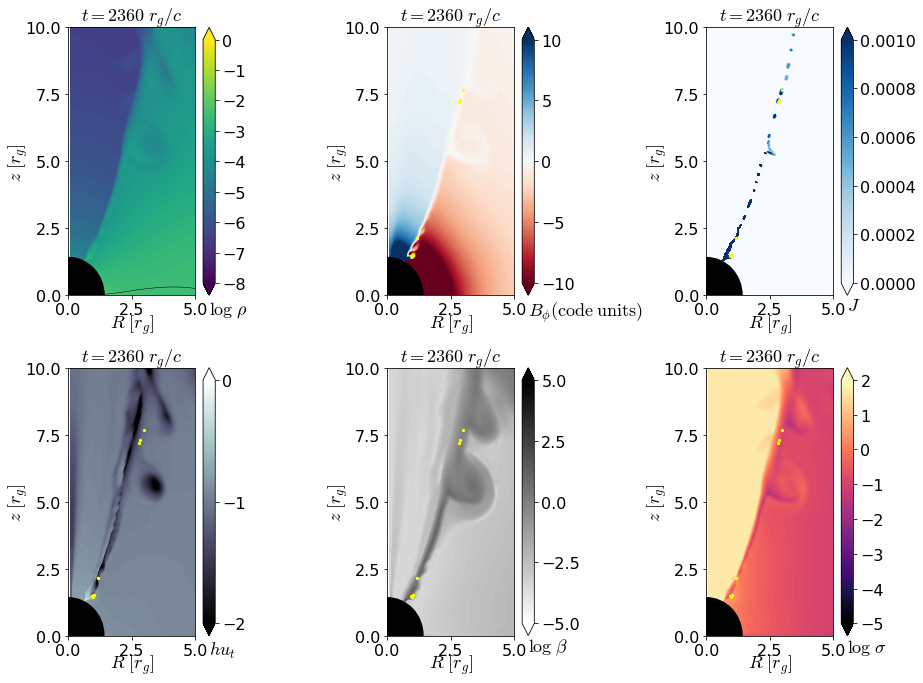

In [63]:
dumpno = 236

rd("dump%03d" % dumpno)

N1, N2, N3 = nx, ny, nz
sigma = bsq/rho
sigmaphi = bu[3]*bd[3]/(rho)
betapl = 2.0*pg/bsq
bphi = bu[3]*B_unit
Bphi = B[3]*B_unit
#jcurr = np.nan_to_num(jcurr)
jdotu = mdot(ju,ud)
Jsq = jsq + jdotu*jdotu
gJsq = gdet*Jsq
JJJ = np.sqrt(Jsq)
EF = rho + gam*ug
EE = bsq + EF
va2 = bsq/EE
va = np.sqrt(va2)
enth=1+ug*gam/rho
unb=enth*ud[0]
isunbound=(-unb>1.02)
    
Jfile = "/work/gustavo/gyst/jcs_files/dump%03d_jcs" %dumpno
Jfilechar = "/work/gustavo/gyst/jcs_files/dump%03d_jcs_char" %dumpno

f1 = open(Jfile, "rb")
dtype = np.float64
body = np.fromfile(f1,dtype=dtype,count=-1)
JJ_cs = body.view().reshape((int(N1),int(N2),int(N3)), order='C')
f1.close()
    
f3 = open(Jfilechar, "rb")
dtype = np.float64
body = np.fromfile(f3,dtype=dtype,count=-1)
JJ_cs_char = body.view().reshape((int(N1),int(N2),int(N3)), order='C')
f3.close()

JJ_cs_char_ind = np.zeros(shape=(N1,N2,N3))
for i in range(N1):
    for j in range(N2):
        for k in range(N3):
            if JJ_cs_char[i][j][k] > 0:
                JJ_cs_char_ind[i][j][k] = 1

rx = []
ry = []
for i in range(525):
    for j in range(N2):
        for k in range(N3):
            if (JJ_cs_char_ind[i][j][k] == 1):
                rx.append(r[i][j][k] * np.sin(h[i][j][k]))
                ry.append(r[i][j][k] * np.cos(h[i][j][k]))
disc=0
jet=1
if (disc):
    myfigname = "/work/gustavo/gyst/quant/quantities_2D_disc_"+str(int(np.round(t)))+".png"
elif (jet):
    myfigname = "/work/gustavo/gyst/quant/quantities_2D_jet_"+str(int(np.round(t)))+".png"

fontsize = 16

mirror = 0
if(mirror):
    xmin = 0
    xmax = 50
    ymin = -xmax
    ymax = xmax
    step = xmax/2
else:
    xmin = 0
    xmax = 5
    ymin = 0
    ymax = 10
    step = 2.5

hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[12.8, 9.6])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,3)

ax1 = plt.subplot(gs[0,0])
aphi = psicalc()
amax = aphi.max()
cs1,cb1 = plc(np.log10(rho),
              levels=np.linspace(-8, 0, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax,
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1,
              fntsize=fontsize)
ax1 = plt.gca()
ax1.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5, **hfont)
ax1.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5, **hfont)
cb1.ax.set_xlabel(r"$\log\;\rho$",fontsize=18,ha="left")
cb1.set_ticks([-8,-7,-6,-5,-4,-3,-2,-1,0])
if(mirror):
    ax1.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax1.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax1.tick_params(axis="x", labelsize=fontsize)
    ax1.tick_params(axis="y", labelsize=fontsize)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax)
    plt.ylim(0,ymax)
plc(aphi,levels=np.linspace(-amax,amax,20)[1:-1],colors="black",linewidths=0.5,xy=-1)
ax1.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)

ax2 = plt.subplot(gs[0,1])
cs2,cb2 = plc(Bphi, 
              levels=np.linspace(-10, 10, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax,
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='RdBu',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 5)#, markersize = 0.01)
ax2 = plt.gca()
ax2.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5)
ax2.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5)
cb2.ax.set_xlabel(r"$B_\phi(\mathrm{code\;units})$",fontsize=18,ha="left")
cb2.set_ticks([-10,-5,0,5,10])
if(mirror):
    ax2.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax2.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax2.tick_params(axis="x", labelsize=fontsize)
    ax2.tick_params(axis="y", labelsize=fontsize)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax)
    plt.ylim(0,ymax)
ax2.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)
"""
ax2 = plt.subplot(gs[0,1])
cs2,cb2 = plc(Bphi*B_unit, 
              levels=np.linspace(-2000, 2000, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax,
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='RdBu',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 5)#, markersize = 0.01)
ax2 = plt.gca()
ax2.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5)
ax2.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5)
cb2.ax.set_xlabel(r"$B_\phi(G)$",fontsize=18,ha="left")
cb2.set_ticks([-2000,-1000,0,1000,2000])
if(mirror):
    ax2.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax2.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax2.tick_params(axis="x", labelsize=fontsize)
    ax2.tick_params(axis="y", labelsize=fontsize)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax)
    plt.ylim(0,ymax)
ax2.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)
"""
ax3 = plt.subplot(gs[0,2])
cs3,cb3 = plc(JJ_cs, 
              levels=np.linspace(0,10e-4,100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax, 
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='Blues',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 5)#, markersize = 0.01)
ax3 = plt.gca()
ax3.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5)
ax3.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5)
cb3.ax.set_xlabel(r"$J$",fontsize=18, labelpad=1, ha="left")
cb3.set_ticks([0,0.0002,0.0004,0.0006,0.0008,0.001])
if(mirror):
    ax3.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax3.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax3.tick_params(axis="x", labelsize=fontsize)
    ax3.tick_params(axis="y", labelsize=fontsize)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax)
    plt.ylim(0,ymax)
ax3.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)

ax4 = plt.subplot(gs[1,0])
cs4,cb4 = plc(unb,
              levels = np.linspace(-2,0, 100),
              isfilled=1,
              k=0,
              xy=1,
              xmax=xmax,
              ymax=ymax,
              dobh=1,
              cb=1,
              extend="both",
              pretty=1,
              cmap = 'bone',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 5)#, markersize = 0.01)
ax4 = plt.gca()
ax4.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5, **hfont)
ax4.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5, **hfont)
cb4.ax.set_xlabel(r"$hu_t$",fontsize=18,ha="left")
cb4.set_ticks([-2,-1,0])
if(mirror):
    ax4.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax4.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax4.tick_params(axis="x", labelsize=fontsize)
    ax4.tick_params(axis="y", labelsize=fontsize)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax)
    plt.ylim(0,ymax)
ax4.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)

ax5 = plt.subplot(gs[1,1])
cs5,cb5 = plc(np.log10(betapl), 
              levels=np.linspace(-5, 5, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax, 
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='binary',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 5)#, markersize = 0.01)
ax5 = plt.gca()
ax5.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5)
ax5.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5)
cb5.ax.set_xlabel(r"$\log\;\beta$",fontsize=18, labelpad=1, ha="left")
cb5.set_ticks([-5,-2.5,0,2.5,5])
if(mirror):
    ax5.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax5.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax5.tick_params(axis="x", labelsize=fontsize)
    ax5.tick_params(axis="y", labelsize=fontsize)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax)
    plt.ylim(0,ymax)
ax5.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)

ax6 = plt.subplot(gs[1,2])
cs6,cb6 = plc(np.log10(sigma), 
              levels=np.linspace(-5, 2, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax, 
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='magma',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 5)#, markersize = 0.01)
ax6 = plt.gca()
ax6.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5)
ax6.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5)
cb6.ax.set_xlabel(r"$\log\;\sigma$",fontsize=18, labelpad=1, ha="left")
cb6.set_ticks([-5,-4,-3,-2,-1,0,1,2])
if(mirror):
    ax6.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax6.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax6.tick_params(axis="x", labelsize=fontsize)
    ax6.tick_params(axis="y", labelsize=fontsize)
else:
    plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    plt.xlim(0,xmax)
    plt.ylim(0,ymax)
ax6.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)
plt.tight_layout()

savef=0
if (savef):
    plt.savefig(myfigname, dpi = 100)
plt.show()

harm_script2.py:738: RuntimeWarning: invalid value encountered in sqrt
  jcurr = np.sqrt(jsq)


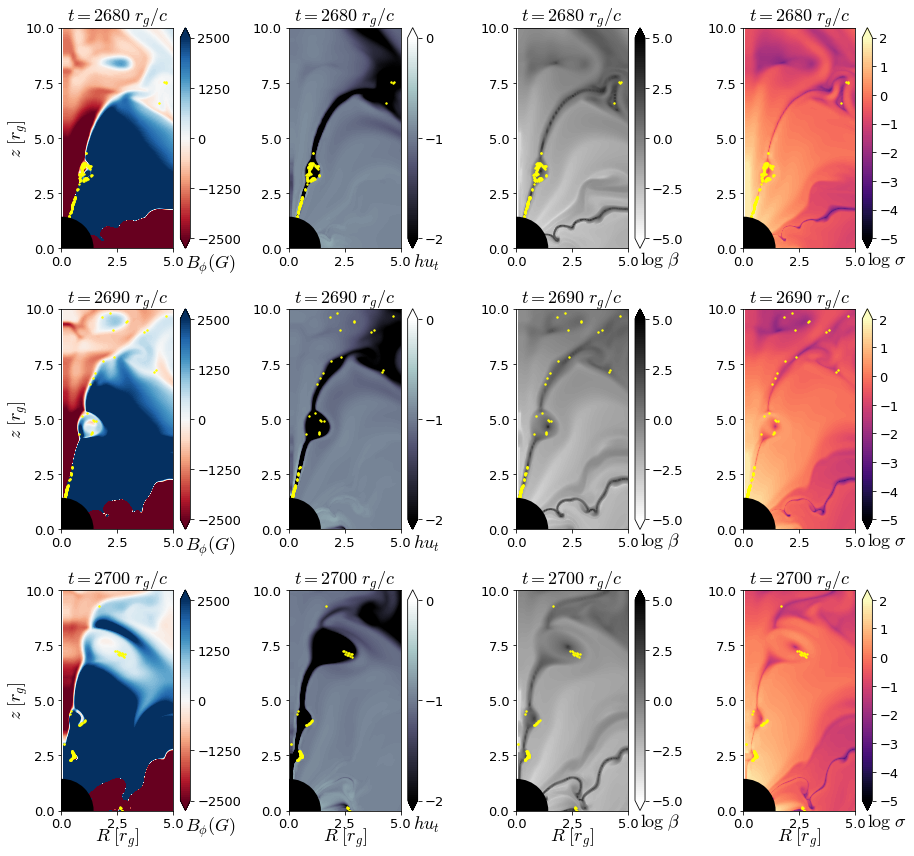

In [40]:
disc=0
jet=1

fontsize = 13

mirror = 0
if(mirror):
    xmin = 0
    xmax = 50
    ymin = -xmax
    ymax = xmax
    step = xmax/2
else:
    xmin = 0
    xmax = 5
    ymin = 0
    ymax = 10
    step = 2.5

hfont = {'fontname':'Helvetica'}
#fig = plt.figure(figsize=[12.8, 4.8])
fig = plt.figure(figsize=[12.8, 12.0])
gs = GridSpec(3,4)


dumpno = 270

rd("dump%03d" % dumpno)

N1, N2, N3 = nx, ny, nz
sigma = bsq/rho
sigmaphi = bu[3]*bd[3]/(rho)
betapl = 2.0*pg/bsq
bphi = bu[3]*B_unit
Bphi = B[3]*B_unit
#jcurr = np.nan_to_num(jcurr)
jdotu = mdot(ju,ud)
Jsq = jsq + jdotu*jdotu
gJsq = gdet*Jsq
JJJ = np.sqrt(Jsq)
EF = rho + gam*ug
EE = bsq + EF
va2 = bsq/EE
va = np.sqrt(va2)
enth=1+ug*gam/rho
unb=enth*ud[0]
isunbound=(-unb>1.02)
    
Jfile = "/work/gustavo/gyst/jcs_files/dump%03d_jcs" %dumpno
Jfilechar = "/work/gustavo/gyst/jcs_files/dump%03d_jcs_char" %dumpno

f1 = open(Jfile, "rb")
dtype = np.float64
body = np.fromfile(f1,dtype=dtype,count=-1)
JJ_cs = body.view().reshape((int(N1),int(N2),int(N3)), order='C')
f1.close()
    
f3 = open(Jfilechar, "rb")
dtype = np.float64
body = np.fromfile(f3,dtype=dtype,count=-1)
JJ_cs_char = body.view().reshape((int(N1),int(N2),int(N3)), order='C')
f3.close()

JJ_cs_char_ind = np.zeros(shape=(N1,N2,N3))
for i in range(N1):
    for j in range(N2):
        for k in range(N3):
            if JJ_cs_char[i][j][k] > 0:
                JJ_cs_char_ind[i][j][k] = 1

rx = []
ry = []
for i in range(525):
    for j in range(N2):
        for k in range(N3):
            if (JJ_cs_char_ind[i][j][k] == 1):
                rx.append(r[i][j][k] * np.sin(h[i][j][k]))
                ry.append(r[i][j][k] * np.cos(h[i][j][k]))

"""                
ax9 = plt.subplot(gs[2,0])
cs9,cb9 = plc(Bphi, 
              levels=np.linspace(-10, 10, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax,
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='RdBu',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 5)#, markersize = 0.01)
ax9 = plt.gca()
ax9.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5)
ax9.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5)
cb9.ax.set_xlabel(r"$B_\phi$",fontsize=18,ha="left")#(\mathrm{code\;units})
cb9.set_ticks([-10,-5,0,5,10])
if(mirror):
    ax9.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax9.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax9.tick_params(axis="x", labelsize=fontsize)
    ax9.tick_params(axis="y", labelsize=fontsize)
else:
    ax9.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax9.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax9.tick_params(axis="x", labelsize=fontsize)
    ax9.tick_params(axis="y", labelsize=fontsize)
    ax9.set_xlim(xmin,xmax)
    ax9.set_ylim(ymin,ymax)
    
    #plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    #plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    #plt.xlim(0,xmax)
    #plt.ylim(0,ymax)
ax9.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)
"""
ax9 = plt.subplot(gs[2,0])
cs9,cb9 = plc(Bphi*B_unit, 
              levels=np.linspace(-2500, 2500, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax,
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='RdBu',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 2)#, markersize = 0.01)
ax9 = plt.gca()
ax9.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5)
ax9.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5)
cb9.ax.set_xlabel(r"$B_\phi(G)$",fontsize=18,ha="left")
cb9.set_ticks([-2500,-1250,0,1250,2500])
if(mirror):
    ax1.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax1.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax1.tick_params(axis="x", labelsize=fontsize)
    ax1.tick_params(axis="y", labelsize=fontsize)
else:
    ax9.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax9.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax9.tick_params(axis="x", labelsize=fontsize)
    ax9.tick_params(axis="y", labelsize=fontsize)
    ax9.set_xlim(xmin,xmax)
    ax9.set_ylim(ymin,ymax)
ax9.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)


ax10 = plt.subplot(gs[2,1], sharey=ax9)
cs10,cb10 = plc(unb,
              levels = np.linspace(-2,0, 100),
              isfilled=1,
              k=0,
              xy=1,
              xmax=xmax,
              ymax=ymax,
              dobh=1,
              cb=1,
              extend="both",
              pretty=1,
              cmap = 'bone',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 2)#, markersize = 0.01)
ax10 = plt.gca()
ax10.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5, **hfont)
#ax2.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5, **hfont)
cb10.ax.set_xlabel(r"$hu_t$",fontsize=18,ha="left")
cb10.set_ticks([-2,-1,0])
if(mirror):
    ax10.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    #ax2.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax10.tick_params(axis="x", labelsize=fontsize)
    #ax2.tick_params(axis="y", labelsize=fontsize)
else:
    #plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    #plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    #plt.xlim(0,xmax)
    #plt.ylim(0,ymax)
    
    ax10.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax10.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax10.tick_params(axis="x", labelsize=fontsize)
    ax10.tick_params(axis="y", labelsize=fontsize)
    ax10.set_xlim(xmin,xmax)
    ax10.set_ylim(ymin,ymax)
ax10.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)

ax11 = plt.subplot(gs[2,2], sharey=ax9)
cs11,cb11 = plc(np.log10(betapl), 
              levels=np.linspace(-5, 5, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax, 
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='binary',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 2)#, markersize = 0.01)
ax11 = plt.gca()
ax11.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5)
#ax3.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5)
cb11.ax.set_xlabel(r"$\log\;\beta$",fontsize=18, labelpad=1, ha="left")
cb11.set_ticks([-5,-2.5,0,2.5,5])
if(mirror):
    ax11.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax11.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax11.tick_params(axis="x", labelsize=fontsize)
    ax11.tick_params(axis="y", labelsize=fontsize)
else:
    #plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    #plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    #plt.xlim(0,xmax)
    #plt.ylim(0,ymax)
    ax11.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax11.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax11.tick_params(axis="x", labelsize=fontsize)
    ax11.tick_params(axis="y", labelsize=fontsize)
    ax11.set_xlim(xmin,xmax)
    ax11.set_ylim(ymin,ymax)
ax11.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)

ax12 = plt.subplot(gs[2,3], sharey=ax9)
cs12,cb12 = plc(np.log10(sigma), 
              levels=np.linspace(-5, 2, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax, 
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='magma',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 2)#, markersize = 0.01)
ax12 = plt.gca()
ax12.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5)
#ax4.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5)
cb12.ax.set_xlabel(r"$\log\;\sigma$",fontsize=18, labelpad=1, ha="left")
cb12.set_ticks([-5,-4,-3,-2,-1,0,1,2])
if(mirror):
    ax12.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax12.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax12.tick_params(axis="x", labelsize=fontsize)
    ax12.tick_params(axis="y", labelsize=fontsize)
else:
    #plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    #plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    #plt.xlim(0,xmax)
    #plt.ylim(0,ymax)
    ax12.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax12.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax12.tick_params(axis="x", labelsize=fontsize)
    ax12.tick_params(axis="y", labelsize=fontsize)
    ax12.set_xlim(xmin,xmax)
    ax12.set_ylim(ymin,ymax)
ax12.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)
plt.tight_layout()



##########




dumpno = 268

rd("dump%03d" % dumpno)

N1, N2, N3 = nx, ny, nz
sigma = bsq/rho
sigmaphi = bu[3]*bd[3]/(rho)
betapl = 2.0*pg/bsq
bphi = bu[3]*B_unit
Bphi = B[3]*B_unit
#jcurr = np.nan_to_num(jcurr)
jdotu = mdot(ju,ud)
Jsq = jsq + jdotu*jdotu
gJsq = gdet*Jsq
JJJ = np.sqrt(Jsq)
EF = rho + gam*ug
EE = bsq + EF
va2 = bsq/EE
va = np.sqrt(va2)
enth=1+ug*gam/rho
unb=enth*ud[0]
isunbound=(-unb>1.02)
    
Jfile = "/work/gustavo/gyst/jcs_files/dump%03d_jcs" %dumpno
Jfilechar = "/work/gustavo/gyst/jcs_files/dump%03d_jcs_char" %dumpno

f1 = open(Jfile, "rb")
dtype = np.float64
body = np.fromfile(f1,dtype=dtype,count=-1)
JJ_cs = body.view().reshape((int(N1),int(N2),int(N3)), order='C')
f1.close()
    
f3 = open(Jfilechar, "rb")
dtype = np.float64
body = np.fromfile(f3,dtype=dtype,count=-1)
JJ_cs_char = body.view().reshape((int(N1),int(N2),int(N3)), order='C')
f3.close()

JJ_cs_char_ind = np.zeros(shape=(N1,N2,N3))
for i in range(N1):
    for j in range(N2):
        for k in range(N3):
            if JJ_cs_char[i][j][k] > 0:
                JJ_cs_char_ind[i][j][k] = 1

rx = []
ry = []
for i in range(525):
    for j in range(N2):
        for k in range(N3):
            if (JJ_cs_char_ind[i][j][k] == 1):
                rx.append(r[i][j][k] * np.sin(h[i][j][k]))
                ry.append(r[i][j][k] * np.cos(h[i][j][k]))


"""
ax1 = plt.subplot(gs[0,0], sharex=ax9)
cs1,cb1 = plc(Bphi, 
              levels=np.linspace(-10, 10, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax,
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='RdBu',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 5)#, markersize = 0.01)
ax1 = plt.gca()
#ax1.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5)
ax1.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5)
cb1.ax.set_xlabel(r"$B_\phi$",fontsize=18,ha="left")#(\mathrm{code\;units})
cb1.set_ticks([-10,-5,0,5,10])
if(mirror):
    ax1.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax1.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax1.tick_params(axis="x", labelsize=fontsize)
    ax1.tick_params(axis="y", labelsize=fontsize)
else:
    ax1.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax1.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax1.tick_params(axis="x", labelsize=fontsize)
    ax1.tick_params(axis="y", labelsize=fontsize)
    ax1.set_xlim(xmin,xmax)
    ax1.set_ylim(ymin,ymax)
    
    #plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    #plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    #plt.xlim(0,xmax)
    #plt.ylim(0,ymax)
ax1.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)
"""
ax1 = plt.subplot(gs[0,0], sharex=ax9)
cs1,cb1 = plc(Bphi*B_unit, 
              levels=np.linspace(-2500, 2500, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax,
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='RdBu',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 2)#, markersize = 0.01)
ax1 = plt.gca()
#ax1.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5)
ax1.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5)
cb1.ax.set_xlabel(r"$B_\phi(G)$",fontsize=18,ha="left")
cb1.set_ticks([-2500,-1250,0,1250,2500])
if(mirror):
    ax1.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax1.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax1.tick_params(axis="x", labelsize=fontsize)
    ax1.tick_params(axis="y", labelsize=fontsize)
else:
    ax1.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax1.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax1.tick_params(axis="x", labelsize=fontsize)
    ax1.tick_params(axis="y", labelsize=fontsize)
    ax1.set_xlim(xmin,xmax)
    ax1.set_ylim(ymin,ymax)
ax1.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)


ax2 = plt.subplot(gs[0,1], sharex=ax10, sharey=ax1)
cs2,cb2 = plc(unb,
              levels = np.linspace(-2,0, 100),
              isfilled=1,
              k=0,
              xy=1,
              xmax=xmax,
              ymax=ymax,
              dobh=1,
              cb=1,
              extend="both",
              pretty=1,
              cmap = 'bone',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 2)#, markersize = 0.01)
ax2 = plt.gca()
#ax2.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5, **hfont)
#ax2.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5, **hfont)
cb2.ax.set_xlabel(r"$hu_t$",fontsize=18,ha="left")
cb2.set_ticks([-2,-1,0])
if(mirror):
    ax2.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    #ax2.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax2.tick_params(axis="x", labelsize=fontsize)
    #ax2.tick_params(axis="y", labelsize=fontsize)
else:
    #plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    #plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    #plt.xlim(0,xmax)
    #plt.ylim(0,ymax)
    
    ax2.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax2.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax2.tick_params(axis="x", labelsize=fontsize)
    ax2.tick_params(axis="y", labelsize=fontsize)
    ax2.set_xlim(xmin,xmax)
    ax2.set_ylim(ymin,ymax)
ax2.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)

ax3 = plt.subplot(gs[0,2], sharex=ax11, sharey=ax1)
cs3,cb3 = plc(np.log10(betapl), 
              levels=np.linspace(-5, 5, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax, 
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='binary',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 2)#, markersize = 0.01)
ax3 = plt.gca()
#ax3.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5)
#ax3.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5)
cb3.ax.set_xlabel(r"$\log\;\beta$",fontsize=18, labelpad=1, ha="left")
cb3.set_ticks([-5,-2.5,0,2.5,5])
if(mirror):
    ax3.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax3.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax3.tick_params(axis="x", labelsize=fontsize)
    ax3.tick_params(axis="y", labelsize=fontsize)
else:
    #plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    #plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    #plt.xlim(0,xmax)
    #plt.ylim(0,ymax)
    ax3.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax3.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax3.tick_params(axis="x", labelsize=fontsize)
    ax3.tick_params(axis="y", labelsize=fontsize)
    ax3.set_xlim(xmin,xmax)
    ax3.set_ylim(ymin,ymax)
ax3.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)

ax4 = plt.subplot(gs[0,3], sharex=ax12, sharey=ax1)
cs4,cb4 = plc(np.log10(sigma), 
              levels=np.linspace(-5, 2, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax, 
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='magma',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 2)#, markersize = 0.01)
ax4 = plt.gca()
#ax4.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5)
#ax4.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5)
cb4.ax.set_xlabel(r"$\log\;\sigma$",fontsize=18, labelpad=1, ha="left")
cb4.set_ticks([-5,-4,-3,-2,-1,0,1,2])
if(mirror):
    ax4.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax4.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax4.tick_params(axis="x", labelsize=fontsize)
    ax4.tick_params(axis="y", labelsize=fontsize)
else:
    #plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    #plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    #plt.xlim(0,xmax)
    #plt.ylim(0,ymax)
    ax4.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax4.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax4.tick_params(axis="x", labelsize=fontsize)
    ax4.tick_params(axis="y", labelsize=fontsize)
    ax4.set_xlim(xmin,xmax)
    ax4.set_ylim(ymin,ymax)
ax4.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)
plt.tight_layout()


######################################3

dumpno = 269

rd("dump%03d" % dumpno)

N1, N2, N3 = nx, ny, nz
sigma = bsq/rho
sigmaphi = bu[3]*bd[3]/(rho)
betapl = 2.0*pg/bsq
bphi = bu[3]*B_unit
Bphi = B[3]*B_unit
#jcurr = np.nan_to_num(jcurr)
jdotu = mdot(ju,ud)
Jsq = jsq + jdotu*jdotu
gJsq = gdet*Jsq
JJJ = np.sqrt(Jsq)
EF = rho + gam*ug
EE = bsq + EF
va2 = bsq/EE
va = np.sqrt(va2)
enth=1+ug*gam/rho
unb=enth*ud[0]
isunbound=(-unb>1.02)
    
Jfile = "/work/gustavo/gyst/jcs_files/dump%03d_jcs" %dumpno
Jfilechar = "/work/gustavo/gyst/jcs_files/dump%03d_jcs_char" %dumpno

f1 = open(Jfile, "rb")
dtype = np.float64
body = np.fromfile(f1,dtype=dtype,count=-1)
JJ_cs = body.view().reshape((int(N1),int(N2),int(N3)), order='C')
f1.close()
    
f3 = open(Jfilechar, "rb")
dtype = np.float64
body = np.fromfile(f3,dtype=dtype,count=-1)
JJ_cs_char = body.view().reshape((int(N1),int(N2),int(N3)), order='C')
f3.close()

JJ_cs_char_ind = np.zeros(shape=(N1,N2,N3))
for i in range(N1):
    for j in range(N2):
        for k in range(N3):
            if JJ_cs_char[i][j][k] > 0:
                JJ_cs_char_ind[i][j][k] = 1

rx = []
ry = []
for i in range(525):
    for j in range(N2):
        for k in range(N3):
            if (JJ_cs_char_ind[i][j][k] == 1):
                rx.append(r[i][j][k] * np.sin(h[i][j][k]))
                ry.append(r[i][j][k] * np.cos(h[i][j][k]))

"""
ax5 = plt.subplot(gs[1,0], sharex=ax9)
cs5,cb5 = plc(Bphi, 
              levels=np.linspace(-10, 10, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax,
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='RdBu',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 5)#, markersize = 0.01)
ax5 = plt.gca()
#ax5.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5)
ax5.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5)
cb5.ax.set_xlabel(r"$B_\phi$",fontsize=18,ha="left")#(\mathrm{code\;units})
cb5.set_ticks([-10,-5,0,5,10])
if(mirror):
    ax5.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax5.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax5.tick_params(axis="x", labelsize=fontsize)
    ax5.tick_params(axis="y", labelsize=fontsize)
else:
    ax5.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax5.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax5.tick_params(axis="x", labelsize=fontsize)
    ax5.tick_params(axis="y", labelsize=fontsize)
    ax5.set_xlim(xmin,xmax)
    ax5.set_ylim(ymin,ymax)
    
    #plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    #plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    #plt.xlim(0,xmax)
    #plt.ylim(0,ymax)
ax5.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)
"""
ax5 = plt.subplot(gs[1,0], sharex=ax9)
cs5,cb5 = plc(Bphi*B_unit, 
              levels=np.linspace(-2500, 2500, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax,
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='RdBu',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 2)#, markersize = 0.01)
ax5 = plt.gca()
#ax5.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5)
ax5.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5)
cb5.ax.set_xlabel(r"$B_\phi(G)$",fontsize=18,ha="left")
cb5.set_ticks([-2500,-1250,0,1250,2500])
if(mirror):
    ax1.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax1.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax1.tick_params(axis="x", labelsize=fontsize)
    ax1.tick_params(axis="y", labelsize=fontsize)
else:
    ax5.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax5.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax5.tick_params(axis="x", labelsize=fontsize)
    ax5.tick_params(axis="y", labelsize=fontsize)
    ax5.set_xlim(xmin,xmax)
    ax5.set_ylim(ymin,ymax)
ax5.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)


ax6 = plt.subplot(gs[1,1], sharex=ax10, sharey=ax5)
cs6,cb6 = plc(unb,
              levels = np.linspace(-2,0, 100),
              isfilled=1,
              k=0,
              xy=1,
              xmax=xmax,
              ymax=ymax,
              dobh=1,
              cb=1,
              extend="both",
              pretty=1,
              cmap = 'bone',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 2)#, markersize = 0.01)
ax6 = plt.gca()
#ax6.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5, **hfont)
#ax2.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5, **hfont)
cb6.ax.set_xlabel(r"$hu_t$",fontsize=18,ha="left")
cb6.set_ticks([-2,-1,0])
if(mirror):
    ax6.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    #ax2.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax6.tick_params(axis="x", labelsize=fontsize)
    #ax2.tick_params(axis="y", labelsize=fontsize)
else:
    #plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    #plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    #plt.xlim(0,xmax)
    #plt.ylim(0,ymax)
    
    ax6.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax6.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax6.tick_params(axis="x", labelsize=fontsize)
    ax6.tick_params(axis="y", labelsize=fontsize)
    ax6.set_xlim(xmin,xmax)
    ax6.set_ylim(ymin,ymax)
ax6.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)

ax7 = plt.subplot(gs[1,2], sharex=ax11, sharey=ax5)
cs7,cb7 = plc(np.log10(betapl), 
              levels=np.linspace(-5, 5, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax, 
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='binary',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 2)#, markersize = 0.01)
ax7 = plt.gca()
#ax7.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5)
#ax3.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5)
cb7.ax.set_xlabel(r"$\log\;\beta$",fontsize=18, labelpad=1, ha="left")
cb7.set_ticks([-5,-2.5,0,2.5,5])
if(mirror):
    ax7.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax7.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax7.tick_params(axis="x", labelsize=fontsize)
    ax7.tick_params(axis="y", labelsize=fontsize)
else:
    #plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    #plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    #plt.xlim(0,xmax)
    #plt.ylim(0,ymax)
    ax7.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax7.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax7.tick_params(axis="x", labelsize=fontsize)
    ax7.tick_params(axis="y", labelsize=fontsize)
    ax7.set_xlim(xmin,xmax)
    ax7.set_ylim(ymin,ymax)
ax7.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)

ax8 = plt.subplot(gs[1,3], sharex=ax12, sharey=ax5)
cs8,cb8 = plc(np.log10(sigma), 
              levels=np.linspace(-5, 2, 100),
              isfilled=1, 
              k=0, 
              xy=1, 
              xmax=xmax, 
              ymax=ymax, 
              dobh=1, 
              cb=True, 
              extend = "both", 
              pretty=1, 
              cmap='magma',
              fntsize=fontsize)
plt.scatter(rx, ry, c ='yellow', marker = 'o', s = 2)#, markersize = 0.01)
ax8 = plt.gca()
#ax8.set_xlabel(r"$R\ [r_g]$",fontsize=18,labelpad=-5)
#ax4.set_ylabel(r"$z\ [r_g]$",fontsize=18,labelpad=-5)
cb8.ax.set_xlabel(r"$\log\;\sigma$",fontsize=18, labelpad=1, ha="left")
cb8.set_ticks([-5,-4,-3,-2,-1,0,1,2])
if(mirror):
    ax8.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax8.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax8.tick_params(axis="x", labelsize=fontsize)
    ax8.tick_params(axis="y", labelsize=fontsize)
else:
    #plt.xticks(np.arange(0, xmax+1, step=step), **hfont) #GS
    #plt.yticks(np.arange(0, ymax+1, step=step), **hfont) #GS
    #plt.xlim(0,xmax)
    #plt.ylim(0,ymax)
    ax8.set_xticks(np.arange(xmin, xmax+1, step=step)) #GS
    ax8.set_yticks(np.arange(ymin, ymax+1, step=step)) #GS
    ax8.tick_params(axis="x", labelsize=fontsize)
    ax8.tick_params(axis="y", labelsize=fontsize)
    ax8.set_xlim(xmin,xmax)
    ax8.set_ylim(ymin,ymax)
ax8.set_title(r"$t=%.5g$"%np.round(t)+r"$\;r_g/c$", fontsize=18)
plt.tight_layout()



######################################3






savef=1
if (savef):
    plt.savefig("plasmoidevo_2D.png", dpi = 150)
plt.show()

DISC

mean energy [code units] 3.558443246995029e-05

mean energy [erg] = 4.0189380667004865e+36

std error energy [code units] 0.0004461038215557844

std error energy [erg] = 5.038337007805614e+37

max energy [code units] = 0.040172643653369956

max energy [erg] = 4.5371347977760175e+39

JET

mean energy [code units] 0.00040704090184489673

mean energy [erg] = 4.597156850850395e+37

std error energy [code units] 0.0016825913022583227

std error energy [erg] = 1.900333872418948e+38

max energy [code units] = 0.0397222269320424

max energy [erg] = 4.4862643248873357e+39



NEW METHOD (ALFVEN)

DISC

mean energy [code units] 0.00040783285703752434

mean energy [erg] = 4.606101264600592e+37

std error energy [code units] 0.0015340827086299756

std error energy [erg] = 1.7326069202835914e+38

max energy [code units] = 0.04017264365336996

max energy [erg] = 4.5371347977760175e+39

JET

mean energy [code units] 0.00031214427125694647

mean energy [erg] = 3.525385700942099e+37

std error energy [code units] 0.0013987608846143852

std error energy [erg] = 1.5797732253101331e+38

max energy [code units] = 0.0397222269320424

max energy [erg] = 4.4862643248873357e+39

No handles with labels found to put in legend.


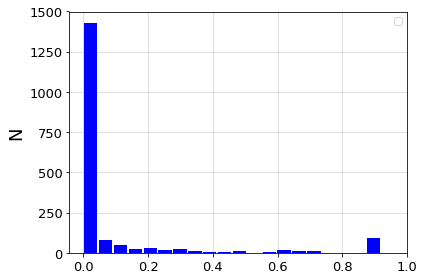

In [97]:
latexsize=18
fontsize=13

vaflat = va.flat

plt.hist(vasites, bins=20, rwidth=0.9, color='blue', zorder=2)
#plt.hist(np.log10(betaext_filt_d), bins=20, rwidth=0.9, range=[-5,10], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
#plt.xlabel(r"$\log\;\beta$", fontsize=latexsize)
plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([0,0.2,0.4,0.6,0.8,1.0],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

In [96]:
size(vasites)

1815

In [98]:
vasitessmall = [element for element in vasites if element < 0.01]

In [99]:
size(vasitessmall)

758

In [100]:
np.mean(va)

0.20890413

In [101]:
np.mean(vasites)

0.09663992

In [102]:
vasitesfast = [element for element in vasites if element > 0.5]

In [103]:
size(vasitesfast)

138

In [92]:
57/448*100

12.723214285714285

<Figure size 460.8x518.4 with 0 Axes>

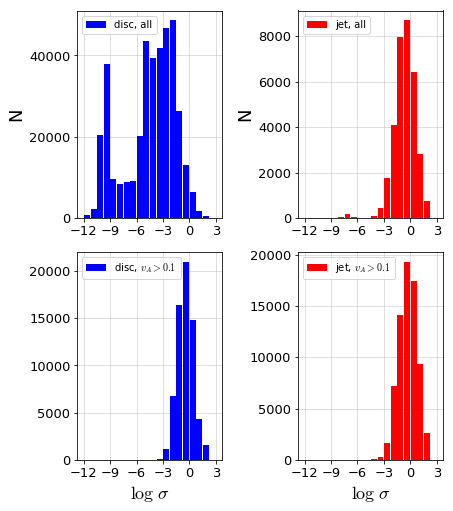

In [21]:
fontsize = 13
latexsize = 18

mylabel_d = "disc"
mycolor_d = "blue"
mylabel_j = "jet"
mycolor_j = "red"

myfilename_sdo = "/work/gustavo/gyst/sigma_2D_disc_old.dat"
myfilename_sjo = "/work/gustavo/gyst/sigma_2D_jet_old.dat"

myfile_sdo = open(myfilename_sdo, "r")
mydata_sdo = pd.read_csv(myfilename_sdo, header=None)
sigmaext_do = mydata_sdo.values
#betaext_filt_d = betaext_d[~is_outlier(betaext_d)]
sigmaext_filt_do = sigmaext_do
sigmaext_filt_do = np.array(sigmaext_filt_do)
sigmaext_small_do = sigmaext_do[sigmaext_do < 1]
sigmaext_small_do = np.array(sigmaext_small_do)
myfile_sdo.close()

myfile_sjo = open(myfilename_sjo, "r")
mydata_sjo = pd.read_csv(myfilename_sjo, header=None)
sigmaext_jo = mydata_sjo.values
#betaext_filt_j = betaext_j[~is_outlier(betaext_j)]
sigmaext_filt_jo = sigmaext_jo
sigmaext_filt_jo = np.array(sigmaext_filt_jo)
sigmaext_small_jo = sigmaext_jo[sigmaext_jo < 1]
sigmaext_small_jo = np.array(sigmaext_small_jo)
myfile_sjo.close()

"""
histmin_bd = np.log10(((array(betaext_filt_do)).min()).astype(float))
histmax_bd = np.log10(((array(betaext_filt_do)).max()).astype(float))

histmin_bj = np.log10(((array(betaext_filt_jo)).min()).astype(float))
histmax_bj = np.log10(((array(betaext_filt_jo)).max()).astype(float))

histmin_small_bd = np.log10(((array(sigmaext_small_do)).min()).astype(float))
histmax_small_bd = np.log10(((array(sigmaext_small_d)).max()).astype(float))

histmin_small_bj = np.log10(((array(sigmaext_small_jo)).min()).astype(float))
histmax_small_bj = np.log10(((array(sigmaext_small_jo)).max()).astype(float))
"""

################################

myfilename_sd = "/work/gustavo/gyst/sigma_2D_disc.dat"
myfilename_sj = "/work/gustavo/gyst/sigma_2D_jet.dat"

myfile_sd = open(myfilename_sd, "r")
mydata_sd = pd.read_csv(myfilename_sd, header=None)
sigmaext_d = mydata_sd.values
#sigmaext_filt_d = sigmaext_d[~is_outlier(sigmaext_d)]
sigmaext_filt_d = sigmaext_d
sigmaext_filt_d = np.array(sigmaext_filt_d)
sigmaext_large_d = sigmaext_d[sigmaext_d >= 1]
sigmaext_large_d = np.array(sigmaext_large_d)
myfile_sd.close()

myfile_sj = open(myfilename_sj, "r")
mydata_sj = pd.read_csv(myfilename_sj, header=None)
sigmaext_j = mydata_sj.values
#sigmaext_filt_j = sigmaext_j[~is_outlier(sigmaext_j)]
sigmaext_filt_j = sigmaext_j
sigmaext_filt_j = np.array(sigmaext_filt_j)
sigmaext_large_j = sigmaext_j[sigmaext_j >= 1]
sigmaext_large_j = np.array(sigmaext_large_j)
myfile_sj.close()

histmin_sd = np.log10(((array(sigmaext_filt_d)).min()).astype(float))
histmax_sd = np.log10(((array(sigmaext_filt_d)).max()).astype(float))

histmin_sj = np.log10(((array(sigmaext_filt_j)).min()).astype(float))
histmax_sj = np.log10(((array(sigmaext_filt_j)).max()).astype(float))

histmin_large_sd = np.log10(((array(sigmaext_large_d)).min()).astype(float))
histmax_large_sd = np.log10(((array(sigmaext_large_d)).max()).astype(float))

histmin_large_sj = np.log10(((array(sigmaext_large_j)).min()).astype(float))
histmax_large_sj = np.log10(((array(sigmaext_large_j)).max()).astype(float))


##################################


hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


#################################



hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])
plt.hist(np.log10(sigmaext_filt_do), bins=20, rwidth=0.9, range=[-12,3], label="disc, all", color=mycolor_d, zorder=2)
#plt.hist(np.log10(betaext_filt_d), bins=20, rwidth=0.9, range=[-5,10], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
#plt.xlabel(r"$\log\;\sigma$", fontsize=latexsize)
plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-12,-9,-6,-3,0,3],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax2 = plt.subplot(gs[0,1])
plt.hist(np.log10(sigmaext_filt_jo), bins=20, rwidth=0.9, range=[-12,3], label="jet, all", color=mycolor_j, zorder=2)
#plt.hist(np.log10(betaext_filt_j), bins=20, rwidth=0.9, range=[-4,4], label="jet", color=mycolor_j)
_, max_ = plt.ylim()
#
plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-12,-9,-6,-3,0,3],fontsize=fontsize)
#plt.xticks([-4,-2,0,2,4],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax3 = plt.subplot(gs[1,0])
plt.hist(np.log10(sigmaext_filt_d), bins=20, rwidth=0.9, range=[-12,3], label="disc, $v_A > 0.1$", color=mycolor_d, zorder=2)
#plt.hist(np.log10(sigmaext_filt_d), bins=20, rwidth=0.9, range=[-13,2], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\log\;\sigma$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-12,-9,-6,-3,0,3],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax4 = plt.subplot(gs[1,1])
plt.hist(np.log10(sigmaext_filt_j), bins=20, rwidth=0.9, range=[-12,3], label="jet, $v_A > 0.1$", color=mycolor_j, zorder=2)
#plt.hist(np.log10(sigmaext_filt_j), bins=20, rwidth=0.9, range=[-10,2], label="jet", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\log\;\sigma$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
#plt.xticks([-10,-7,-4,-1,2],fontsize=fontsize)
plt.xticks([-12,-9,-6,-3,0,3],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

savef=0
if (savef):
    plt.savefig("log_sigma_2D_discjet_all", dpi=150)

<Figure size 460.8x518.4 with 0 Axes>

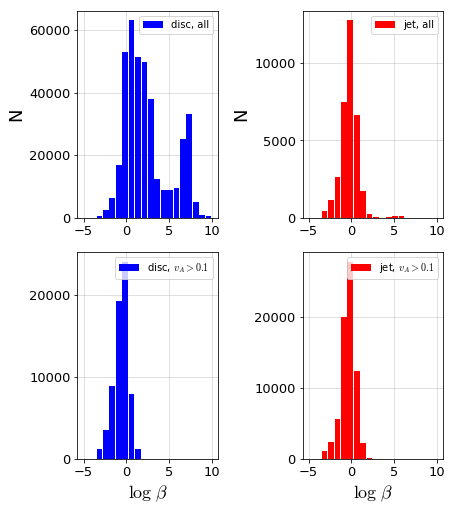

In [27]:
fontsize = 13
latexsize = 18

mylabel_d = "disc"
mycolor_d = "blue"
mylabel_j = "jet"
mycolor_j = "red"

myfilename_bdo = "/work/gustavo/gyst/beta_2D_disc_old.dat"
myfilename_bjo = "/work/gustavo/gyst/beta_2D_jet_old.dat"

myfile_bdo = open(myfilename_bdo, "r")
mydata_bdo = pd.read_csv(myfilename_bdo, header=None)
betaext_do = mydata_bdo.values
#betaext_filt_d = betaext_d[~is_outlier(betaext_d)]
betaext_filt_do = betaext_do
betaext_filt_do = np.array(betaext_filt_do)
betaext_small_do = betaext_do[betaext_do < 1]
betaext_small_do = np.array(betaext_small_do)
myfile_bdo.close()

myfile_bjo = open(myfilename_bjo, "r")
mydata_bjo = pd.read_csv(myfilename_bjo, header=None)
betaext_jo = mydata_bjo.values
#betaext_filt_j = betaext_j[~is_outlier(betaext_j)]
betaext_filt_jo = betaext_jo
betaext_filt_jo = np.array(betaext_filt_jo)
betaext_small_jo = betaext_jo[betaext_jo < 1]
betaext_small_jo = np.array(betaext_small_jo)
myfile_bjo.close()

################################

myfilename_bd = "/work/gustavo/gyst/beta_2D_disc.dat"
myfilename_bj = "/work/gustavo/gyst/beta_2D_jet.dat"

myfile_bd = open(myfilename_bd, "r")
mydata_bd = pd.read_csv(myfilename_bd, header=None)
betaext_d = mydata_bd.values
#betaext_filt_d = betaext_d[~is_outlier(betaext_d)]
betaext_filt_d = betaext_d
betaext_filt_d = np.array(betaext_filt_d)
betaext_large_d = betaext_d[betaext_d >= 1]
betaext_large_d = np.array(betaext_large_d)
myfile_bd.close()

myfile_bj = open(myfilename_bj, "r")
mydata_bj = pd.read_csv(myfilename_bj, header=None)
betaext_j = mydata_bj.values
#betaext_filt_j = betaext_j[~is_outlier(betaext_j)]
betaext_filt_j = betaext_j
betaext_filt_j = np.array(betaext_filt_j)
betaext_large_j = betaext_j[betaext_j >= 1]
betaext_large_j = np.array(betaext_large_j)
myfile_bj.close()

##################################


hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


#################################



hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])
plt.hist(np.log10(betaext_filt_do), bins=20, rwidth=0.9, range=[-5,10], label="disc, all", color=mycolor_d, zorder=2)
#plt.hist(np.log10(betaext_filt_d), bins=20, rwidth=0.9, range=[-5,10], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
#plt.xlabel(r"$\log\;\beta$", fontsize=latexsize)
plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-5,0,5,10],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax2 = plt.subplot(gs[0,1])
plt.hist(np.log10(betaext_filt_jo), bins=20, rwidth=0.9, range=[-5,10], label="jet, all", color=mycolor_j, zorder=2)
#plt.hist(np.log10(betaext_filt_j), bins=20, rwidth=0.9, range=[-4,4], label="jet", color=mycolor_j)
_, max_ = plt.ylim()
#
plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-5,0,5,10],fontsize=fontsize)
#plt.xticks([-4,-2,0,2,4],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax3 = plt.subplot(gs[1,0])
plt.hist(np.log10(betaext_filt_d), bins=20, rwidth=0.9, range=[-5,10], label="disc, $v_A > 0.1$", color=mycolor_d, zorder=2)
#plt.hist(np.log10(betaext_filt_d), bins=20, rwidth=0.9, range=[-13,2], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\log\;\beta$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-5,0,5,10],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax4 = plt.subplot(gs[1,1])
plt.hist(np.log10(betaext_filt_j), bins=20, rwidth=0.9, range=[-5,10], label="jet, $v_A > 0.1$", color=mycolor_j, zorder=2)
#plt.hist(np.log10(betaext_filt_j), bins=20, rwidth=0.9, range=[-10,2], label="jet", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\log\;\beta$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
#plt.xticks([-10,-7,-4,-1,2],fontsize=fontsize)
plt.xticks([-5,0,5,10],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

savef=0
if (savef):
    plt.savefig("log_beta_2D_discjet_all", dpi=150)

In [37]:
np.median(BthBphiext_filt_do)

0.24715957

<Figure size 460.8x518.4 with 0 Axes>

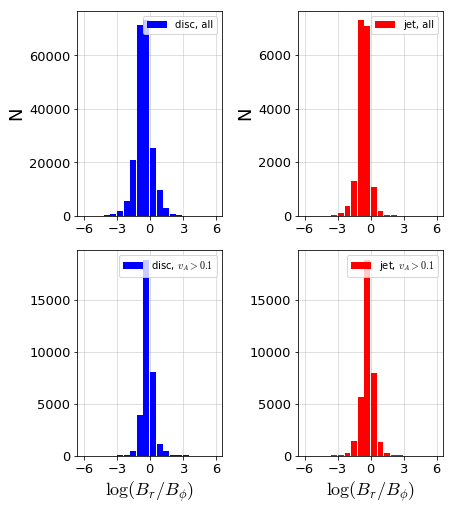

In [32]:
fontsize = 13
latexsize = 18

mylabel_d = "disc"
mycolor_d = "blue"
mylabel_j = "jet"
mycolor_j = "red"

myfilename_bdo = "/work/gustavo/gyst/guidefield_r_2D_disc_old.dat"
myfilename_bjo = "/work/gustavo/gyst/guidefield_r_2D_jet_old.dat"

myfile_bdo = open(myfilename_bdo, "r")
mydata_bdo = pd.read_csv(myfilename_bdo, header=None)
BrBphiext_do = mydata_bdo.values
#BrBphiext_filt_d = BrBphiext_d[~is_outlier(BrBphiext_d)]
BrBphiext_filt_do = BrBphiext_do
BrBphiext_filt_do = np.array(BrBphiext_filt_do)
BrBphiext_small_do = BrBphiext_do[BrBphiext_do < 1]
BrBphiext_small_do = np.array(BrBphiext_small_do)
myfile_bdo.close()

myfile_bjo = open(myfilename_bjo, "r")
mydata_bjo = pd.read_csv(myfilename_bjo, header=None)
BrBphiext_jo = mydata_bjo.values
#BrBphiext_filt_j = BrBphiext_j[~is_outlier(BrBphiext_j)]
BrBphiext_filt_jo = BrBphiext_jo
BrBphiext_filt_jo = np.array(BrBphiext_filt_jo)
BrBphiext_small_jo = BrBphiext_jo[BrBphiext_jo < 1]
BrBphiext_small_jo = np.array(BrBphiext_small_jo)
myfile_bjo.close()

################################

myfilename_bd = "/work/gustavo/gyst/guidefield_r_2D_disc.dat"
myfilename_bj = "/work/gustavo/gyst/guidefield_r_2D_jet.dat"

myfile_bd = open(myfilename_bd, "r")
mydata_bd = pd.read_csv(myfilename_bd, header=None)
BrBphiext_d = mydata_bd.values
#BrBphiext_filt_d = BrBphiext_d[~is_outlier(BrBphiext_d)]
BrBphiext_filt_d = BrBphiext_d
BrBphiext_filt_d = np.array(BrBphiext_filt_d)
BrBphiext_large_d = BrBphiext_d[BrBphiext_d >= 1]
BrBphiext_large_d = np.array(BrBphiext_large_d)
myfile_bd.close()

myfile_bj = open(myfilename_bj, "r")
mydata_bj = pd.read_csv(myfilename_bj, header=None)
BrBphiext_j = mydata_bj.values
#BrBphiext_filt_j = BrBphiext_j[~is_outlier(BrBphiext_j)]
BrBphiext_filt_j = BrBphiext_j
BrBphiext_filt_j = np.array(BrBphiext_filt_j)
BrBphiext_large_j = BrBphiext_j[BrBphiext_j >= 1]
BrBphiext_large_j = np.array(BrBphiext_large_j)
myfile_bj.close()

##################################


hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


#################################



hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])
plt.hist(np.log10(BrBphiext_filt_do), bins=20, rwidth=0.9, range=[-5,5], label="disc, all", color=mycolor_d, zorder=2)
#plt.hist(np.log10(BrBphiext_filt_d), bins=20, rwidth=0.9, range=[-5,10], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
#plt.xlabel(r"$\log\;\BrBphi$", fontsize=latexsize)
plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-5,-2.5,0,2.5,5],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax2 = plt.subplot(gs[0,1])
plt.hist(np.log10(BrBphiext_filt_jo), bins=20, rwidth=0.9, range=[-5,5], label="jet, all", color=mycolor_j, zorder=2)
#plt.hist(np.log10(BrBphiext_filt_j), bins=20, rwidth=0.9, range=[-4,4], label="jet", color=mycolor_j)
_, max_ = plt.ylim()
#
plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-5,-2.5,0,2.5,5],fontsize=fontsize)
#plt.xticks([-4,-2,0,2,4],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax3 = plt.subplot(gs[1,0])
plt.hist(np.log10(BrBphiext_filt_d), bins=20, rwidth=0.9, range=[-5,5], label="disc, $v_A > 0.1$", color=mycolor_d, zorder=2)
#plt.hist(np.log10(BrBphiext_filt_d), bins=20, rwidth=0.9, range=[-13,2], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\log(B_r/B_\phi)$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-5,-2.5,0,2.5,5],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax4 = plt.subplot(gs[1,1])
plt.hist(np.log10(BrBphiext_filt_j), bins=20, rwidth=0.9, range=[-5,5], label="jet, $v_A > 0.1$", color=mycolor_j, zorder=2)
#plt.hist(np.log10(BrBphiext_filt_j), bins=20, rwidth=0.9, range=[-10,2], label="jet", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\log(B_r/B_\phi)$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
#plt.xticks([-10,-7,-4,-1,2],fontsize=fontsize)
plt.xticks([-5,-2.5,0,2.5,5],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

savef=0
if (savef):
    plt.savefig("log_BrBphi_2D_discjet_all", dpi=150)

<Figure size 460.8x518.4 with 0 Axes>

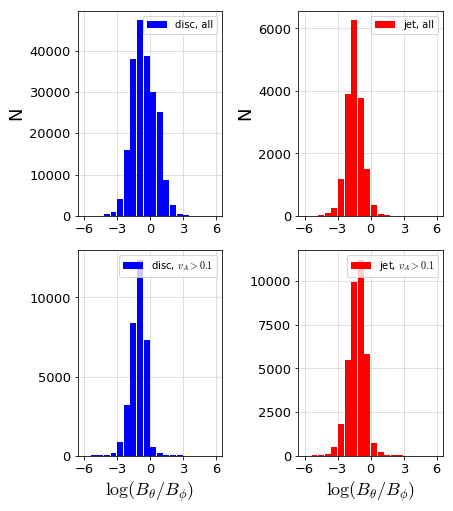

In [34]:
fontsize = 13
latexsize = 18

mylabel_d = "disc"
mycolor_d = "blue"
mylabel_j = "jet"
mycolor_j = "red"

myfilename_bdo = "/work/gustavo/gyst/guidefield_th_2D_disc_old.dat"
myfilename_bjo = "/work/gustavo/gyst/guidefield_th_2D_jet_old.dat"

myfile_bdo = open(myfilename_bdo, "r")
mydata_bdo = pd.read_csv(myfilename_bdo, header=None)
BthBphiext_do = mydata_bdo.values
#BthBphiext_filt_d = BthBphiext_d[~is_outlier(BthBphiext_d)]
BthBphiext_filt_do = BthBphiext_do
BthBphiext_filt_do = np.array(BthBphiext_filt_do)
BthBphiext_small_do = BthBphiext_do[BthBphiext_do < 1]
BthBphiext_small_do = np.array(BthBphiext_small_do)
myfile_bdo.close()

myfile_bjo = open(myfilename_bjo, "r")
mydata_bjo = pd.read_csv(myfilename_bjo, header=None)
BthBphiext_jo = mydata_bjo.values
#BthBphiext_filt_j = BthBphiext_j[~is_outlier(BthBphiext_j)]
BthBphiext_filt_jo = BthBphiext_jo
BthBphiext_filt_jo = np.array(BthBphiext_filt_jo)
BthBphiext_small_jo = BthBphiext_jo[BthBphiext_jo < 1]
BthBphiext_small_jo = np.array(BthBphiext_small_jo)
myfile_bjo.close()

################################

myfilename_bd = "/work/gustavo/gyst/guidefield_th_2D_disc.dat"
myfilename_bj = "/work/gustavo/gyst/guidefield_th_2D_jet.dat"

myfile_bd = open(myfilename_bd, "r")
mydata_bd = pd.read_csv(myfilename_bd, header=None)
BthBphiext_d = mydata_bd.values
#BthBphiext_filt_d = BthBphiext_d[~is_outlier(BthBphiext_d)]
BthBphiext_filt_d = BthBphiext_d
BthBphiext_filt_d = np.array(BthBphiext_filt_d)
BthBphiext_large_d = BthBphiext_d[BthBphiext_d >= 1]
BthBphiext_large_d = np.array(BthBphiext_large_d)
myfile_bd.close()

myfile_bj = open(myfilename_bj, "r")
mydata_bj = pd.read_csv(myfilename_bj, header=None)
BthBphiext_j = mydata_bj.values
#BthBphiext_filt_j = BthBphiext_j[~is_outlier(BthBphiext_j)]
BthBphiext_filt_j = BthBphiext_j
BthBphiext_filt_j = np.array(BthBphiext_filt_j)
BthBphiext_large_j = BthBphiext_j[BthBphiext_j >= 1]
BthBphiext_large_j = np.array(BthBphiext_large_j)
myfile_bj.close()

##################################


hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


#################################



hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)


ax1 = plt.subplot(gs[0,0])
plt.hist(np.log10(BthBphiext_filt_do), bins=20, rwidth=0.9, range=[-6,6], label="disc, all", color=mycolor_d, zorder=2)
#plt.hist(np.log10(BthBphiext_filt_d), bins=20, rwidth=0.9, range=[-5,10], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
#plt.xlabel(r"$\log\;\BthBphi$", fontsize=latexsize)
plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-6,-3,0,3,6],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax2 = plt.subplot(gs[0,1])
plt.hist(np.log10(BthBphiext_filt_jo), bins=20, rwidth=0.9, range=[-6,6], label="jet, all", color=mycolor_j, zorder=2)
#plt.hist(np.log10(BthBphiext_filt_j), bins=20, rwidth=0.9, range=[-4,4], label="jet", color=mycolor_j)
_, max_ = plt.ylim()
#
plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-6,-3,0,3,6],fontsize=fontsize)
#plt.xticks([-4,-2,0,2,4],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax3 = plt.subplot(gs[1,0])
plt.hist(np.log10(BthBphiext_filt_d), bins=20, rwidth=0.9, range=[-6,6], label="disc, $v_A > 0.1$", color=mycolor_d, zorder=2)
#plt.hist(np.log10(BthBphiext_filt_d), bins=20, rwidth=0.9, range=[-13,2], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\log(B_\theta/B_\phi)$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-6,-3,0,3,6],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax4 = plt.subplot(gs[1,1])
plt.hist(np.log10(BthBphiext_filt_j), bins=20, rwidth=0.9, range=[-6,6], label="jet, $v_A > 0.1$", color=mycolor_j, zorder=2)
#plt.hist(np.log10(BthBphiext_filt_j), bins=20, rwidth=0.9, range=[-10,2], label="jet", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\log(B_\theta/B_\phi)$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
#plt.xticks([-10,-7,-4,-1,2],fontsize=fontsize)
plt.xticks([-6,-3,0,3,6],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

savef=0
if (savef):
    plt.savefig("log_BthBphi_2D_discjet_all", dpi=150)

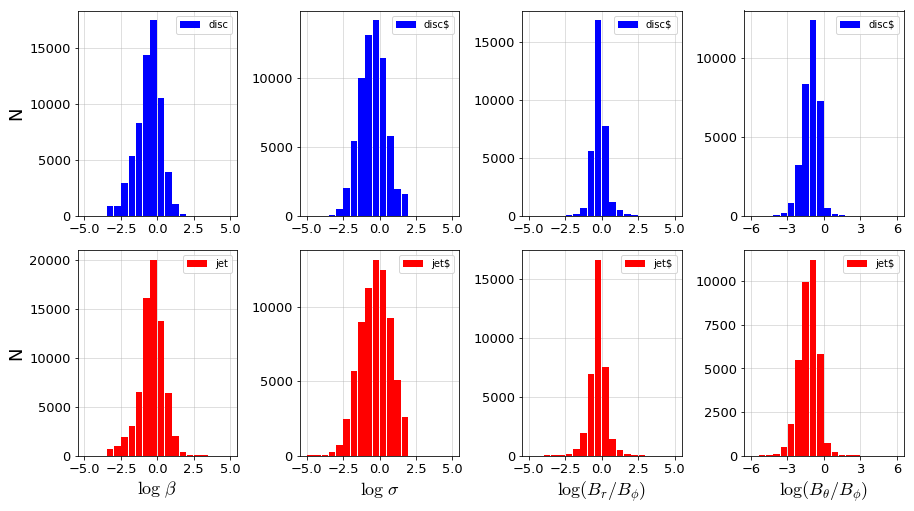

In [13]:
fontsize = 13
latexsize = 18

mylabel_d = "disc"
mycolor_d = "blue"
mylabel_j = "jet"
mycolor_j = "red"

#####################################################

myfilename_bd = "/work/gustavo/gyst/beta_2D_disc.dat"
myfilename_bj = "/work/gustavo/gyst/beta_2D_jet.dat"

myfile_bd = open(myfilename_bd, "r")
mydata_bd = pd.read_csv(myfilename_bd, header=None)
betaext_d = mydata_bd.values
#betaext_filt_d = betaext_d[~is_outlier(betaext_d)]
betaext_filt_d = betaext_d
betaext_filt_d = np.array(betaext_filt_d)
betaext_large_d = betaext_d[betaext_d >= 1]
betaext_large_d = np.array(betaext_large_d)
myfile_bd.close()

myfile_bj = open(myfilename_bj, "r")
mydata_bj = pd.read_csv(myfilename_bj, header=None)
betaext_j = mydata_bj.values
#betaext_filt_j = betaext_j[~is_outlier(betaext_j)]
betaext_filt_j = betaext_j
betaext_filt_j = np.array(betaext_filt_j)
betaext_large_j = betaext_j[betaext_j >= 1]
betaext_large_j = np.array(betaext_large_j)
myfile_bj.close()

#######################################################

myfilename_sd = "/work/gustavo/gyst/sigma_2D_disc.dat"
myfilename_sj = "/work/gustavo/gyst/sigma_2D_jet.dat"

myfile_sd = open(myfilename_sd, "r")
mydata_sd = pd.read_csv(myfilename_sd, header=None)
sigmaext_d = mydata_sd.values
#sigmaext_filt_d = sigmaext_d[~is_outlier(sigmaext_d)]
sigmaext_filt_d = sigmaext_d
sigmaext_filt_d = np.array(sigmaext_filt_d)
sigmaext_large_d = sigmaext_d[sigmaext_d >= 1]
sigmaext_large_d = np.array(sigmaext_large_d)
myfile_sd.close()

myfile_sj = open(myfilename_sj, "r")
mydata_sj = pd.read_csv(myfilename_sj, header=None)
sigmaext_j = mydata_sj.values
#sigmaext_filt_j = sigmaext_j[~is_outlier(sigmaext_j)]
sigmaext_filt_j = sigmaext_j
sigmaext_filt_j = np.array(sigmaext_filt_j)
sigmaext_large_j = sigmaext_j[sigmaext_j >= 1]
sigmaext_large_j = np.array(sigmaext_large_j)
myfile_sj.close()

##############################################################

myfilename_rd = "/work/gustavo/gyst/guidefield_r_2D_disc.dat"
myfilename_rj = "/work/gustavo/gyst/guidefield_r_2D_jet.dat"

myfile_rd = open(myfilename_rd, "r")
mydata_rd = pd.read_csv(myfilename_rd, header=None)
BrBphiext_d = mydata_rd.values
#BrBphiext_filt_d = BrBphiext_d[~is_outlier(BthBphiext_d)]
BrBphiext_filt_d = BrBphiext_d
BrBphiext_filt_d = np.array(BrBphiext_filt_d)
BrBphiext_small_d = BrBphiext_d[BrBphiext_d < 1]
BrBphiext_small_d = np.array(BrBphiext_small_d)
myfile_rd.close()

myfile_rj = open(myfilename_rj, "r")
mydata_rj = pd.read_csv(myfilename_rj, header=None)
BrBphiext_j = mydata_rj.values
#BrBphiext_filt_j = BBphiext_j[~is_outlier(BthBphiext_j)]
BrBphiext_filt_j = BrBphiext_j
BrBphiext_filt_j = np.array(BrBphiext_filt_j)
BrBphiext_small_j = BrBphiext_j[BrBphiext_j < 1]
BrBphiext_small_j = np.array(BrBphiext_small_j)
myfile_rj.close()

################################

myfilename_td = "/work/gustavo/gyst/guidefield_th_2D_disc.dat"
myfilename_tj = "/work/gustavo/gyst/guidefield_th_2D_jet.dat"

myfile_td = open(myfilename_td, "r")
mydata_td = pd.read_csv(myfilename_td, header=None)
BthBphiext_d = mydata_td.values
#BthBphiext_filt_d = BthBphiext_d[~is_outlier(BthBphiext_d)]
BthBphiext_filt_d = BthBphiext_d
BthBphiext_filt_d = np.array(BthBphiext_filt_d)
BthBphiext_large_d = BthBphiext_d[BthBphiext_d >= 1]
BthBphiext_large_d = np.array(BthBphiext_large_d)
myfile_td.close()

myfile_tj = open(myfilename_tj, "r")
mydata_tj = pd.read_csv(myfilename_tj, header=None)
BthBphiext_j = mydata_tj.values
#BthBphiext_filt_j = BthBphiext_j[~is_outlier(BthBphiext_j)]
BthBphiext_filt_j = BthBphiext_j
BthBphiext_filt_j = np.array(BthBphiext_filt_j)
BthBphiext_large_j = BthBphiext_j[BthBphiext_j >= 1]
BthBphiext_large_j = np.array(BthBphiext_large_j)
myfile_tj.close()

##################################



hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[12.8, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,4)

###########################################

ax1 = plt.subplot(gs[0,0])
plt.hist(np.log10(betaext_filt_d), bins=20, rwidth=0.9, range=[-5,5], label="disc", color=mycolor_d, zorder=2)
#plt.hist(np.log10(betaext_filt_d), bins=20, rwidth=0.9, range=[-5,10], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
#plt.xlabel(r"$\log\;\BthBphi$", fontsize=latexsize)
plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-5,-2.5,0,2.5,5],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax5 = plt.subplot(gs[1,0])
plt.hist(np.log10(betaext_filt_j), bins=20, rwidth=0.9, range=[-5,5], label="jet", color=mycolor_j, zorder=2)
#plt.hist(np.log10(BthBphiext_filt_j), bins=20, rwidth=0.9, range=[-4,4], label="jet", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\log\;\beta$", fontsize=latexsize)
plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-5,-2.5,0,2.5,5],fontsize=fontsize)
#plt.xticks([-4,-2,0,2,4],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

#############################################

ax2 = plt.subplot(gs[0,1])
plt.hist(np.log10(sigmaext_filt_d), bins=20, rwidth=0.9, range=[-5,5], label="disc", color=mycolor_d, zorder=2)
#plt.hist(np.log10(sigmaext_filt_d), bins=20, rwidth=0.9, range=[-13,2], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
#plt.xlabel(r"$\log\;\sigma$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-5,-2.5,0,2.5,5],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax6 = plt.subplot(gs[1,1])
plt.hist(np.log10(sigmaext_filt_j), bins=20, rwidth=0.9, range=[-5,5], label="jet", color=mycolor_j, zorder=2)
#plt.hist(np.log10(sigmaext_filt_j), bins=20, rwidth=0.9, range=[-10,2], label="jet", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\log\;\sigma$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
#plt.xticks([-10,-7,-4,-1,2],fontsize=fontsize)
plt.xticks([-5,-2.5,0,2.5,5],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

###############################################

ax3 = plt.subplot(gs[0,2])
plt.hist(np.log10(BrBphiext_filt_d), bins=20, rwidth=0.9, range=[-5,5], label="disc", color=mycolor_d, zorder=2)
#plt.hist(np.log10(BthBphiext_filt_d), bins=20, rwidth=0.9, range=[-13,2], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
#plt.xlabel(r"$\log(B_r/B_\phi)$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-5,-2.5,0,2.5,5],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax7 = plt.subplot(gs[1,2])
plt.hist(np.log10(BrBphiext_filt_j), bins=20, rwidth=0.9, range=[-5,5], label="jet", color=mycolor_j, zorder=2)
#plt.hist(np.log10(BthBphiext_filt_j), bins=20, rwidth=0.9, range=[-10,2], label="jet", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\log(B_r/B_\phi)$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
#plt.xticks([-10,-7,-4,-1,2],fontsize=fontsize)
plt.xticks([-5,-2.5,0,2.5,5],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

##################################################

ax4 = plt.subplot(gs[0,3])
plt.hist(np.log10(BthBphiext_filt_d), bins=20, rwidth=0.9, range=[-6,6], label="disc", color=mycolor_d, zorder=2)
#plt.hist(np.log10(BthBphiext_filt_d), bins=20, rwidth=0.9, range=[-13,2], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
#plt.xlabel(r"$\log(B_r/B_\phi)$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-6,-3,0,3,6],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

ax8 = plt.subplot(gs[1,3])
plt.hist(np.log10(BthBphiext_filt_j), bins=20, rwidth=0.9, range=[-6,6], label="jet", color=mycolor_j, zorder=2)
#plt.hist(np.log10(BthBphiext_filt_j), bins=20, rwidth=0.9, range=[-10,2], label="jet", color=mycolor_j)
_, max_ = plt.ylim()
plt.xlabel(r"$\log(B_\theta/B_\phi)$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
#plt.xticks([-10,-7,-4,-1,2],fontsize=fontsize)
plt.xticks([-6,-3,0,3,6],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

##################################################

savef=0
if (savef):
    plt.savefig("log_quantities_2D_discjet_all", dpi=150)

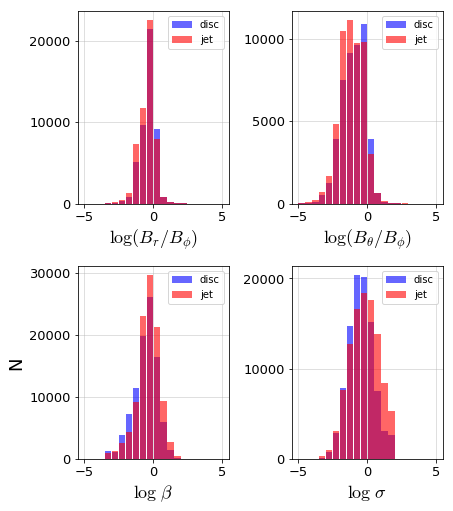

In [20]:
fontsize = 13
latexsize = 18

mylabel_d = "disc"
mycolor_d = "blue"
mylabel_j = "jet"
mycolor_j = "red"

#####################################################

myfilename_bd = "/work/gustavo/gyst/beta_2D_disc.dat"
myfilename_bj = "/work/gustavo/gyst/beta_2D_jet.dat"

myfile_bd = open(myfilename_bd, "r")
mydata_bd = pd.read_csv(myfilename_bd, header=None)
betaext_d = mydata_bd.values
#betaext_filt_d = betaext_d[~is_outlier(betaext_d)]
betaext_filt_d = betaext_d
betaext_filt_d = np.array(betaext_filt_d)
betaext_large_d = betaext_d[betaext_d >= 1]
betaext_large_d = np.array(betaext_large_d)
myfile_bd.close()

myfile_bj = open(myfilename_bj, "r")
mydata_bj = pd.read_csv(myfilename_bj, header=None)
betaext_j = mydata_bj.values
#betaext_filt_j = betaext_j[~is_outlier(betaext_j)]
betaext_filt_j = betaext_j
betaext_filt_j = np.array(betaext_filt_j)
betaext_large_j = betaext_j[betaext_j >= 1]
betaext_large_j = np.array(betaext_large_j)
myfile_bj.close()

#######################################################

myfilename_sd = "/work/gustavo/gyst/sigma_2D_disc.dat"
myfilename_sj = "/work/gustavo/gyst/sigma_2D_jet.dat"

myfile_sd = open(myfilename_sd, "r")
mydata_sd = pd.read_csv(myfilename_sd, header=None)
sigmaext_d = mydata_sd.values
#sigmaext_filt_d = sigmaext_d[~is_outlier(sigmaext_d)]
sigmaext_filt_d = sigmaext_d
sigmaext_filt_d = np.array(sigmaext_filt_d)
sigmaext_large_d = sigmaext_d[sigmaext_d >= 1]
sigmaext_large_d = np.array(sigmaext_large_d)
myfile_sd.close()

myfile_sj = open(myfilename_sj, "r")
mydata_sj = pd.read_csv(myfilename_sj, header=None)
sigmaext_j = mydata_sj.values
#sigmaext_filt_j = sigmaext_j[~is_outlier(sigmaext_j)]
sigmaext_filt_j = sigmaext_j
sigmaext_filt_j = np.array(sigmaext_filt_j)
sigmaext_large_j = sigmaext_j[sigmaext_j >= 1]
sigmaext_large_j = np.array(sigmaext_large_j)
myfile_sj.close()

##############################################################

myfilename_rd = "/work/gustavo/gyst/guidefield_r_2D_disc.dat"
myfilename_rj = "/work/gustavo/gyst/guidefield_r_2D_jet.dat"

myfile_rd = open(myfilename_rd, "r")
mydata_rd = pd.read_csv(myfilename_rd, header=None)
BrBphiext_d = mydata_rd.values
#BrBphiext_filt_d = BrBphiext_d[~is_outlier(BthBphiext_d)]
BrBphiext_filt_d = BrBphiext_d
BrBphiext_filt_d = np.array(BrBphiext_filt_d)
BrBphiext_small_d = BrBphiext_d[BrBphiext_d < 1]
BrBphiext_small_d = np.array(BrBphiext_small_d)
myfile_rd.close()

myfile_rj = open(myfilename_rj, "r")
mydata_rj = pd.read_csv(myfilename_rj, header=None)
BrBphiext_j = mydata_rj.values
#BrBphiext_filt_j = BBphiext_j[~is_outlier(BthBphiext_j)]
BrBphiext_filt_j = BrBphiext_j
BrBphiext_filt_j = np.array(BrBphiext_filt_j)
BrBphiext_small_j = BrBphiext_j[BrBphiext_j < 1]
BrBphiext_small_j = np.array(BrBphiext_small_j)
myfile_rj.close()

################################

myfilename_td = "/work/gustavo/gyst/guidefield_th_2D_disc.dat"
myfilename_tj = "/work/gustavo/gyst/guidefield_th_2D_jet.dat"

myfile_td = open(myfilename_td, "r")
mydata_td = pd.read_csv(myfilename_td, header=None)
BthBphiext_d = mydata_td.values
#BthBphiext_filt_d = BthBphiext_d[~is_outlier(BthBphiext_d)]
BthBphiext_filt_d = BthBphiext_d
BthBphiext_filt_d = np.array(BthBphiext_filt_d)
BthBphiext_large_d = BthBphiext_d[BthBphiext_d >= 1]
BthBphiext_large_d = np.array(BthBphiext_large_d)
myfile_td.close()

myfile_tj = open(myfilename_tj, "r")
mydata_tj = pd.read_csv(myfilename_tj, header=None)
BthBphiext_j = mydata_tj.values
#BthBphiext_filt_j = BthBphiext_j[~is_outlier(BthBphiext_j)]
BthBphiext_filt_j = BthBphiext_j
BthBphiext_filt_j = np.array(BthBphiext_filt_j)
BthBphiext_large_j = BthBphiext_j[BthBphiext_j >= 1]
BthBphiext_large_j = np.array(BthBphiext_large_j)
myfile_tj.close()

##################################



hfont = {'fontname':'Helvetica'}
fig = plt.figure(figsize=[6.4, 7.2])
#fig = plt.figure(figsize=[12.8, 14.4])
gs = GridSpec(2,2)

###########################################

ax1 = plt.subplot(gs[0,0])
plt.hist(np.log10(BrBphiext_filt_d), bins=20, rwidth=0.9, range=[-5,5], label="disc", color=mycolor_d, zorder=2, alpha=0.6)
plt.hist(np.log10(BrBphiext_filt_j), bins=20, rwidth=0.9, range=[-5,5], label="jet", color=mycolor_j, zorder=2, alpha=0.6)
#plt.hist(np.log10(BthBphiext_filt_d), bins=20, rwidth=0.9, range=[-13,2], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\log(B_r/B_\phi)$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-5,0,5],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

##################################################

ax2 = plt.subplot(gs[0,1])
plt.hist(np.log10(BthBphiext_filt_d), bins=20, rwidth=0.9, range=[-5,5], label="disc", color=mycolor_d, zorder=2, alpha=0.6)
plt.hist(np.log10(BthBphiext_filt_j), bins=20, rwidth=0.9, range=[-5,5], label="jet", color=mycolor_j, zorder=2, alpha=0.6)
#plt.hist(np.log10(BthBphiext_filt_d), bins=20, rwidth=0.9, range=[-13,2], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\log(B_\theta/B_\phi)$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-5,0,5],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

###############################################

ax3 = plt.subplot(gs[1,0])
plt.hist(np.log10(betaext_filt_d), bins=20, rwidth=0.9, range=[-5,5], label="disc", color=mycolor_d, zorder=2, alpha=0.6)
plt.hist(np.log10(betaext_filt_j), bins=20, rwidth=0.9, range=[-5,5], label="jet", color=mycolor_j, zorder=2, alpha=0.6)
#plt.hist(np.log10(betaext_filt_d), bins=20, rwidth=0.9, range=[-5,10], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\log\;\beta$", fontsize=latexsize)
plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-5,0,5],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

#############################################

ax4 = plt.subplot(gs[1,1])
plt.hist(np.log10(sigmaext_filt_d), bins=20, rwidth=0.9, range=[-5,5], label="disc", color=mycolor_d, zorder=2, alpha=0.6)
plt.hist(np.log10(sigmaext_filt_j), bins=20, rwidth=0.9, range=[-5,5], label="jet", color=mycolor_j, zorder=2, alpha=0.6)
#plt.hist(np.log10(sigmaext_filt_d), bins=20, rwidth=0.9, range=[-13,2], label="disc", color=mycolor_d)
_, max_ = plt.ylim()
plt.xlabel(r"$\log\;\sigma$", fontsize=latexsize)
#plt.ylabel("N", fontsize=latexsize)
plt.grid(axis='x', alpha=0.5, zorder=1)
plt.grid(axis='y', alpha=0.5, zorder=1)
plt.legend(loc="best")
plt.xticks([-5,0,5],fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()

##################################################

savef=1
if (savef):
    plt.savefig("log_quantities_2D_discjet_all", dpi=150)